# BTW 2025 Data Science Challenge

## Introduction 

Forecasting market influences, supply, demand, and ultimately prices is of paramount importance for any entity operating within a market. 
Buyers may anticipate opportune moments to purchase goods at affordable prices, while sellers aspire to strategize their production volume around demand and profitability.
This is particularly salient in the context of the electricity market, where the stability of the grid is contingent upon the precarious equilibrium of supply and demand, with any disruption to this balance having the potential to severely impact the grid's reliability and cause blackouts, as described by Horáček (2010).
Consequently, the field of electricity price forecasting stands as a subject of considerable relevance for both market participants and academic researchers.
Historically, these predictions have relied on statistical methods such as ARIMA, SARIMA and GARCH models with moving averages to predict next day's prices, as seen in Contreras et al. (2003) or Nunes et al. (2008).
In recent years, deep learning has become a prominent feature of these attempts, with researches surpassing the accuracy of those statistic approaches using deep learning, for example Lago et al. (2018).
Explainable AI (xAI) approaches have also enabled a greater understanding of the electricity market, with researches such as Tschora et al. (2022) being able to identify the importance and weight of individual influences on the prediciton of electricity prices.

This report details the approach taken by the Dresden Database Research Group to forecast the day ahead electricity price as part of the BTW 2025 Data Science Challenge, comparing and improving several popular time series forecasting methods.
To begin, several data sources containing data influencing the day ahead price were identified, such as finance, meteorology, and societal data.
These were analyzed in depth utilizing approaches such as explainable ML models like Temporal Fusion Transformers.
Based on this analysis data preparation was conducted in an iterative process.
Subsequently, a benchmark of several popular ML methods was conducted.
The most promising methods were then enhanced through the implementation of hyperparameter optimization, fine-tuning, and other techniques. A comprehensive second benchmark was conducted to identify the most optimal model from the resulting methods.
Nevertheless, it is imperative to acknowledge that no single approach can attain results that surpass the quality of the input data. The following work therefore also details the groups work in collecting, preparing and analyzing data relevant to the German electricity prices. 

## Utils


In [1]:
#Installs for real-time execution
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121


  Cloning https://github.com/amazon-science/chronos-forecasting.git to c:\users\hannes\appdata\local\temp\pip-req-build-jgpxyf5i
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 73d6c9aa1aba42612d99f13fc9365ff7f39c4335
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.0-py3-none-any.whl size=29256 sha256=81d49926a11c1e0564f233f2801a7503a9b4b72916d643c484eb8a8ca21df9ef
  Stored in directory: C:\Users\Hannes\AppData\Local\Temp\pip-ephem-wheel-cache-3eqr3793\wheels\ba\7f\47\c8e535215a6b02669af6db36392beef76752951c59bf8b5e74
Successfully built chronos-forecasting
  Attempting uninstall: chronos-forecasting
    Fo

  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git 'C:\Users\Hannes\AppData\Local\Temp\pip-req-build-jgpxyf5i'


Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
!pip install pandas
!pip install numpy


In [7]:
!pip install autogluon
!pip install statsmodels
!pip install python-dotenv
!pip install entsoe-py
!pip install newsapi-python
!pip install sentence-transformers
!pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
     ---------------------------------------- 0.0/48.6 kB ? eta -:--:--
     ---------------------------------------- 48.6/48.6 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/390.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/390.2 MB 2.0 MB/s eta 0:03:17
   ---------------------------------------- 0.2/390.2 MB 1.8 MB/s eta 0:03:33
   ---------------------------------------- 0.2/390.2 MB 1.8 MB/s eta 0:03:37
   ---------------------------------------- 0.3/390.2 MB 1.8 MB/s eta 0:03:39
   ---------------------------------------- 0.4/390.2 MB 1.8 MB/s eta 0:03:39
   ---------------------------------------- 0.5/390.2 MB 1.8 MB/s eta 0:03:40
   ---------------------------------------- 0.6/390.2 MB 1.8 MB/s eta 0:03:40
   ---------------------------------------- 0.6/390.2 MB 1.8 MB/s eta 0:03:41
   -------

In [8]:
import pandas as pd
from abc import ABC, abstractmethod
from typing import final
import pandas as pd
import pickle
import os
import torch
import numpy as np
import matplotlib.pyplot as plt


In [9]:
#Autogluon imports
import sys
import pandas as pd  
import numpy as np  
from autogluon.timeseries import TimeSeriesPredictor  
from autogluon.common import space  
from datetime import datetime, timedelta
import os
from matplotlib import pyplot as plt  
import seaborn as sns  
import time
import tensorflow as tf  
import csv
from dateutil.relativedelta import relativedelta
from sklearn.metrics import *

In [29]:
"""
Base model structure.
Every Forecasting model should inherit from this.

Note: override all abstract methods and keep the final methods unchanged
"""
import pandas as pd
from abc import ABC, abstractmethod
from typing import final
import pandas as pd
from autogluon.tabular import TabularPredictor
import pickle
import os
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from chronos import ChronosPipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


class BaseModel(ABC):

    def __init__(self, model_name: str, model_type: str):
        """Init and create model.

        :param model_name: Name of your model
        :param model_type: Type of your model e.g. LSTM
        """
        self.model_name = model_name
        self.model_type = model_type
        self.model = None  # this is a placeholder for your model
        self.create_model()

    @abstractmethod
    def create_model(self):
        """Define your own model under self.model.
        """
        ...

    @abstractmethod
    def train(self, X_train: pd.DataFrame, y_train: pd.DataFrame,
              X_val: pd.DataFrame = None, y_val: pd.DataFrame = None,
              X_test: pd.DataFrame = None, y_test: pd.DataFrame = None) -> pd.DataFrame | None:
        """train the model on the training data.
        test and validation data can be used only for evaluation (if available).

        :param X_train: training features dataset
        :param y_train: training target values
        :param X_val: validation features' dataset
        :param y_val: validation target values
        :param X_test: testing features' dataset
        :param y_test: testing target values
        :return: training history (losses while training, if available else None) [epoch | train_loss | test_loss]
        """
        # call the training loop/function of your model
        # and return a history (if available, otherwise None)
        ...

    @abstractmethod
    def run_prediction(self, X: pd.DataFrame) -> pd.DataFrame:
        """run prediction on your defined model

        :param X: features dataset
        :return: prediction output, [timestamp | value]
        """
        ...

    @final
    def predict(self, X: pd.DataFrame, exp_dir: str = None) -> pd.DataFrame:
        """call this to run prediction

        :param X: features dataset
        :param exp_dir: dir to store prediction result
        :return: prediction output, [timestamp | value]
        """
        # run your custom prediction
        prediction_results = self.run_prediction(X)

        # store if dir is provided
        if exp_dir is not None:
            prediction_results.to_csv(f'{exp_dir}\\{self.model_type}_{self.model_name}_prediction.csv')
        return prediction_results

    @abstractmethod
    def custom_save(self, model: object, filename: str):
        """Use your own dataformat to save your model here

        :param filename: filename or path
        """
        ...

    @abstractmethod
    def custom_load(self, filename: str) -> object:
        """Use your own dataformat to load your model here

        :param filename: filename or path
        :return: your loaded model
        """
        # return model
        ...

    @final
    def save(self, exp_dir: str):
        """call this to save self.model.

        :param exp_dir: dir name or path to dir
        """
        self.__custom_save(model=self.model, filename=f'{exp_dir}\\{self.model_type}_{self.model_name}')

    @final
    def load(self, exp_dir: str):
        """call this to load a retrained model

        :param exp_dir: dir name or path to dir
        """
        self.model = self.__custom_load(filename=f'{exp_dir}\\{self.model_type}_{self.model_name}')


In [3]:
from chronos import ChronosPipeline

class ChronosModel(BaseModel):
    def __init__(self, model_name: str, model_type: str):
        """Call the BaseModel constructor with the required arguments."""
        
        # Define the missing method to prevent AttributeError
        self._BaseModel__create_model = self.create_model  # Redirect it to the correct method
        
        super().__init__(model_name, model_type)

    def create_model(self):
        self.model = None


    
    def run_prediction(self, X):

        #define which column to be forecasted and forecast legth
        target_column = "day_ahead_prices_EURO"
        prediction_length = 24

        
        context = torch.tensor(X[target_column].values)[-512:]  # Limit context to last 512 samples
        forecast = self.model.predict(context, prediction_length)
        low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

        context_dates = X.index[-512:]
        last_date = context_dates[-1]
        forecast_index = pd.date_range(last_date + pd.Timedelta(hours=1), periods=prediction_length, freq="h")

        prediction_results = pd.DataFrame({
            "timestamp": forecast_index,
            "forecasted_values": median
        })
        
        return prediction_results

    
    def custom_load(self, model_dir):
        
        # Load the model pipeline
        pipeline = ChronosPipeline.from_pretrained(
            model_dir,
            device_map=("cuda" if torch.cuda.is_available() else "cpu"),
            torch_dtype=torch.bfloat16,
        )
        self.model = pipeline  # Set the model to the loaded pipeline

        return pipeline
    
    
                
    def custom_save(self, model = None, filename = None):
        return

    def train(self, X_train = None, y_train = None, X_val = None, y_val = None, X_test = None, y_test = None):
        return None

In [35]:
from autogluon.tabular import TabularPredictor
from statsmodels.tsa.holtwinters import ExponentialSmoothing

class ETSModel(BaseModel):
    def create_model(self):
        self.model = None

    def train(self, X_train, y_train, X_val = None, y_val = None, X_test = None, y_test = None):
        #time_series = X_train
        if y_train.isnull().any():
            print("Warning: Missing values in y_train are being automatically filled by the ETSModel.")
            y_train = y_train.ffill()
        model = ExponentialSmoothing(y_train, seasonal_periods=24, trend="add", seasonal="add")
        self.model = model.fit()
        return None
    
    def run_prediction(self, X):
        if self.model is None:
            raise ValueError("The model is not trained. Call `train` before prediction.")
        forecast = self.model.forecast(len(X))
        #print(forecast)
        #print(X)
        prediction_results = pd.DataFrame({
            'timestamp': X['Date'],  # Use the 'Date' column in X for timestamps
            'value': forecast.values
        })
        return prediction_results

    def custom_save(self, model, filename):
         with open(f"{filename}.pkl", "wb") as file:
            pickle.dump(model, file)
    
    def custom_load(self, filename):
        with open(f"{filename}.pkl", "rb") as file:
            loaded_model = pickle.load(file)
        return loaded_model
    

class MultivarLSTM(nn.Module):
    def __init__(self, num_layers, hidden_size, input_size, output_size):
        super().__init__()
        self.num_layers = num_layers  # number of recurrent layers in the lstm
        self.input_size = input_size  # number of input features
        self.output_size = output_size  # output sequence length
        self.hidden_size = hidden_size  # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2,
                            bidirectional=True)
        self.linear = nn.Linear(hidden_size * 24 * 2, output_size)

        self.activation = nn.Sigmoid()

    def forward(self, x):
        device = x.device
        # hidden state init
        h_0 = Variable(torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=device))
        # cell state init
        c_0 = Variable(torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=device))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # (input, hidden, and internal state)
        # reduce dimension to the required output sequence length
        predictions = self.linear(output.reshape(output.size(0), output.size(1) * output.size(2)))
        pred_out = self.activation(predictions)

        return pred_out


class MultivariateBiLSTM(BaseModel):
    def __init__(self, features, target):
        self.features = features
        self.target = target
        self.input_length = 24
        self.hidden_layer_size = 256
        self.num_layers = 12
        self.output_length = 24
        # Check For GPU -> If available send model and data to it
        self.device = ("cuda" if torch.cuda.is_available() else "cpu")
        super(MultivariateBiLSTM, self).__init__(model_name='MultivarLSTM',
                                                 model_type='MultivariateBidirectionalLSTM')

    def create_model(self):
        self.model = MultivarLSTM(num_layers=self.num_layers, hidden_size=self.hidden_layer_size,
                                  input_size=len(self.features), output_size=self.output_length)
        self.model = self.model.to(self.device)

    def train(self, X_train: pd.DataFrame, y_train: pd.DataFrame,
              X_val: pd.DataFrame = None, y_val: pd.DataFrame = None,
              X_test: pd.DataFrame = None, y_test: pd.DataFrame = None,
              n_epochs=500, batch_size=1024, learning_rate=0.001) -> pd.DataFrame | None:
        self.target_scaler = MinMaxScaler()
        self.feature_scaler = StandardScaler()

        # select features and target columns
        if len(self.features) > 0:
            # use only selected features (of self.features not defined: use all columns as features)
            X_train = X_train[self.features]
            X_test = X_test[self.features]
            X_val = X_val[self.features]
        y_train = y_train[self.target].values
        y_test = y_test[self.target].values
        y_val = y_val[self.target].values

        # fit scalar on training data
        self.feature_scaler.fit(X_train)
        self.target_scaler.fit(y_train.reshape(-1, 1))

        X_train = self.feature_scaler.transform(X_train)
        y_train = self.target_scaler.transform(y_train.reshape(-1, 1))
        X_test = self.feature_scaler.transform(X_test)
        y_test = self.target_scaler.transform(y_test.reshape(-1, 1))
        X_val = self.feature_scaler.transform(X_val)
        y_val = self.target_scaler.transform(y_val.reshape(-1, 1))

        # convert dataset to tensors suitable for training the model
        X_train_tensors = self.__prepare_feature_dataset(X_train)
        y_train_tensors = self.__prepare_target_dataset(y_train)
        X_test_tensors = self.__prepare_feature_dataset(X_test)
        y_test_tensors = self.__prepare_target_dataset(y_test)
        X_val_tensors = self.__prepare_feature_dataset(X_val)
        y_val_tensors = self.__prepare_target_dataset(y_val)

        history = self.__training_loop(n_epochs=n_epochs,
                                       X_train=X_train_tensors,
                                       y_train=y_train_tensors,
                                       X_test=X_test_tensors,
                                       y_test=y_test_tensors,
                                       batch_size=batch_size,
                                       learning_rate=learning_rate)

    def __training_loop(self, n_epochs, X_train, y_train, X_test, y_test, batch_size, learning_rate):
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        loss_fn = torch.nn.MSELoss()  # mean-squared error for regression
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        train_history = {'epoch': [], 'train loss': [], 'test loss': []}

        for epoch in range(n_epochs):
            train_losses = []
            self.model.train()
            for seq, labels in train_loader:
                outputs = self.model(seq)
                optimizer.zero_grad()

                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.to('cpu').item())
            # test loss
            test_losses = []
            self.model.eval()
            for seq, labels in test_loader:
                test_preds = self.model(seq)
                test_loss = loss_fn(test_preds, labels)
                test_losses.append(test_loss.to('cpu').item())
            if epoch % 1 == 0:
                print(
                    f'Epoch {epoch + 1}:\t|\tTrain_Loss: {round(sum(train_losses) / len(train_losses), 5)}\t|\t'
                    f'Test_Loss: {round(sum(test_losses) / len(test_losses), 5)}')
                train_history['epoch'].append(epoch + 1)
                train_history['train loss'].append((sum(train_losses) / len(train_losses)))
                train_history['test loss'].append((sum(test_losses) / len(test_losses)))
        train_history = pd.DataFrame(train_history).set_index('epoch')

        return train_history

    def run_prediction(self, X: pd.DataFrame, batch_size=1024) -> pd.DataFrame:
        """run prediction on your defined model.

        :param X: features dataset
        :return: prediction output, [timestamp | value]
        """
        X = X.reset_index(names='timestamp')
        timestamps = X['timestamp']
        X = X.drop(['timestamp'], axis=1)

        # scale features using the training scaler
        X = self.feature_scaler.transform(X[self.features])
        # prepare dataset
        X_pred_tensors = self.__prepare_feature_dataset(X)
        dataset = TensorDataset(X_pred_tensors)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        pred_list = []
        # predict each batch
        for seq in data_loader:
            X_batch = seq[0]
            predictions = self.model.forward(X_batch)
            pred_list.append(predictions.to('cpu').detach().numpy())

        sequences = np.concatenate(pred_list)

        total_length = len(sequences) + self.target_length - 1  # total number of positions covered
        sum_values = np.zeros(total_length)
        count_values = np.zeros(total_length)
        min_values = np.full(total_length, np.inf)  # init with infinity
        max_values = np.full(total_length, -np.inf)  # init with negative infinity

        for i, seq in enumerate(sequences):
            for j in range(24):
                index = i + j  # global index in the expanded array
                value = seq[j]

                sum_values[index] += value
                count_values[index] += 1
                min_values[index] = min(min_values[index], value)
                max_values[index] = max(max_values[index], value)

        mean_values = sum_values / count_values

        pred_sequence = self.target_scaler.inverse_transform(mean_values.reshape(-1, 1)).reshape(-1)
        mins = self.target_scaler.inverse_transform(min_values.reshape(-1, 1)).reshape(-1)
        maxs = self.target_scaler.inverse_transform(max_values.reshape(-1, 1)).reshape(-1)

        df_result = pd.DataFrame({'timestamp': timestamps[:pred_sequence.shape[0]],
                                  'day_ahead_price_predicted': pred_sequence,
                                  'pred_min': mins,
                                  'pred_max': maxs})
        return df_result

    def __prepare_feature_dataset(self, X):
        X_seq = self.__split_feature_sequences(features_seq=X)

        X_tensor = Variable(torch.Tensor(X_seq))
        X_tensor_format = torch.reshape(X_tensor, (X_tensor.shape[0], self.input_length, X_tensor.shape[2]))
        X_tensor_format = X_tensor_format.to(self.device)

        return X_tensor_format

    def __prepare_target_dataset(self, y):
        y_seq = self.__split_target_sequences(y)

        y_tensor = Variable(torch.Tensor(y_seq))
        y_tensor = y_tensor.to(self.device)

        return y_tensor

    def __split_feature_sequences(self, features_seq):
        X = []  # instantiate X and y
        for i in range(len(features_seq)):
            # find the end of the sequence
            end_ix = i + self.input_length
            # check if we are beyond the dataset
            if end_ix > len(features_seq):
                break
            # gather input and output of the pattern
            seq_x = features_seq[i:end_ix]
            X.append(seq_x)
        return np.array(X)

    def __split_target_sequences(self, target_seq):
        y = []  # instantiate y
        for i in range(len(target_seq)):
            # find the end of the sequence
            end_ix = i + self.input_length
            # check if we are beyond the dataset
            if end_ix > len(target_seq):
                break
            # gather input and output of the pattern
            seq_y = target_seq[i:end_ix, -1]
            y.append(seq_y)
        return np.array(y)

    def create_scalers(self, X_train, y_train):
        self.target_scaler = MinMaxScaler()
        self.feature_scaler = StandardScaler()

        # select features and target columns
        if len(self.features) > 0:
            # use only selected features (of self.features not defined: use all columns as features)
            X_train = X_train[self.features]
        y_train = y_train[self.target].values

        # fit scalar on training data
        self.feature_scaler.fit(X_train)
        self.target_scaler.fit(y_train.reshape(-1, 1))

    def custom_load(self, filename: str) -> object:
        """Use your own dataformat to load your model here

        :param filename: filename or path
        :return: your loaded model
        """
        self.model.load_state_dict(torch.load(filename))
        self.model.eval()
        return self.model

    def custom_save(self, model: object, filename: str):
        """Use your own dataformat to save your model here

        :param filename: filename or path
        """
        torch.save(self.model.state_dict(), filename)
        
        
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 3, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        """forward calculating the attention context and weights
        :param hidden: (batch_size, 1, hidden_dim)
        :param encoder_outputs: (batch_size, seq_len, hidden_dim)
        :return: attention context and weights
        """
        # Repeat decoder hidden state across sequence length
        hidden = hidden.repeat(1, encoder_outputs.size(1), 1)  # (batch_size, seq_len, hidden_dim)

        # concatenate hidden and encoder outputs
        combined = torch.cat((hidden, encoder_outputs), dim=2)  # (batch_size, seq_len, hidden_dim * 2)

        # calculate attention scores
        energy = torch.tanh(self.attn(combined))  # (batch_size, seq_len, hidden_dim)
        scores = self.v(energy).squeeze(2)  # (batch_size, seq_len)

        # apply softmax to get attention weights
        attn_weights = torch.softmax(scores, dim=1)  # (batch_size, seq_len)

        # Compute context vector as weighted sum of encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # (batch_size, 1, hidden_dim)

        return context, attn_weights


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidir=False):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidir)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)    # if bidir
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)

        # output: (batch_size, seq_len, num_layer*hidden_dim)
        # hidden: (num_layers*2, batch_size, hidden_dim)        -> *2 for num_layers if bidirectional=True
        # cell: (num_layers*2, batch_size, hidden_dim)
        output, (hidden, cell) = self.lstm(x, (h0, c0))
        return output, hidden, cell


class Decoder(nn.Module):
    def __init__(self, hidden_dim=16, num_layers=1, num_heads=4, bidir=False, use_attention=True):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.use_attention = use_attention
        self.lstm = nn.LSTM(10 + (2 * hidden_dim), hidden_dim, self.num_layers, batch_first=True, bidirectional=bidir)
        self.fc = nn.Linear(hidden_dim*2, 1)
        self.attention = Attention(hidden_dim)

    def forward(self, x, hidden, cell, encoder_out):
        """Calculate decoder output using attention.

        :param x: decoder input, shape: (batch_size, 1, encoder_out_dim)
        :param hidden: encoder hidden state, shape: (num_layers*num_directions, batch_size, hidden_dim)
        :param cell: encoder cell state, shape: (num_layers*num_directions, batch_size, hidden_dim)
        :param encoder_out: encoder output, shape: (batch_size, seq_len, hidden_dim*num_directions)
        :return: decoder output, shape: (batch_size, 1, 1)
        """
        if self.use_attention:
            # Compute attention
            # context: (batch_size, 1, hidden_dim*num_directions)
            # att_weights: (batch_size, seq_len)
            context, att_weights = self.attention(hidden[-1].unsqueeze(1), encoder_out)
        else:
            # use equal attention weights
            seq_len = encoder_out.shape[1]
            batch_size = x.shape[0]
            value = 1 / seq_len
            att_weights = torch.full((batch_size, seq_len), value, device=x.device)
            context = torch.bmm(att_weights.unsqueeze(1), encoder_out)

        # contatenate context with output from last timestamp
        x = x.repeat(1, 1, 10)
        # x: (batch_size, 1, hidden_dim*num_directions + enc_output_dim*10)
        x = torch.cat((x, context), dim=2)
            
        # output: (batch_size, seq_len, num_layer*hidden_dim)
        # hidden: (num_layers*2, batch_size, hidden_dim)        -> *2 for num_layers if bidirectional=True
        # cell: (num_layers*2, batch_size, hidden_dim)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))

        prediction = self.fc(output)
        return prediction, hidden, cell, att_weights


class EncDecLSTM(nn.Module):
    def __init__(self, encoder, decoder, target_length):
        super(EncDecLSTM, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.target_length = target_length
        self.activation = nn.Sigmoid()

    def forward(self, x: torch.Tensor, dec_init=None, teacher_forcing_ratio=0.5, target_values=None):
        """Forward pass the input sequences, containing feature space through the
        Encoder-Attention-Decoder model and output the predicted sequence

        :param x: input sequences tensor
        :param dec_init: target value for previous timestamp
        :param teacher_forcing_ratio: probibility if teacher forcing is used in each batch
        :param target_values: actual target values used for teacher forcing while training (when available)
        :return: predicted target sequence
        """
        batch_size, sequence_length, input_dim = x.size()
        encoder_output, hidden, cell = self.encoder(x)
        if dec_init is not None:
            decoder_input = dec_init
        else:
            decoder_input = torch.zeros(batch_size, 1, 1).to(x.device)

        # init empty target sequence
        out = torch.zeros(batch_size, self.target_length, 1).to(x.device)

        # step by step decoding
        for t in range(self.target_length):
            decoder_output, hidden, cell, attn_weights = self.decoder(decoder_input, hidden, cell, encoder_output)
            out[:, t, :] = decoder_output.squeeze(1)

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            if teacher_force and target_values is not None:
                decoder_input = target_values[:, t].unsqueeze(1).unsqueeze(1)
            else:
                decoder_input = decoder_output

        out = torch.reshape(out, (out.size(0), out.size(1)))
        out = self.activation(out)
        return out


class EncoderDecoderAttentionLSTM(BaseModel):
    def __init__(self, target_length, features, target, hidden_size=64, num_layers=3, use_attention=True):
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.target = target
        self.features = features
        self.target_length = target_length
        self.use_attention = use_attention
        # Check For GPU -> If available send model and data to it
        self.device = ("cuda" if torch.cuda.is_available() else "cpu")
        super(EncoderDecoderAttentionLSTM, self).__init__(model_name='EncDecAttLSTM',
                                                          model_type='EncoderDecoderAttentionLSTM')

    def create_model(self):
        """define model
        """
        num_heads = 1
        input_size = len(self.features)
        self.input_length = 24
        # case seq2seq decoder: use output_size = self.output_length
        # case autoregressive decoder: use output_size = 1
        output_size = self.target_length

        Enc = Encoder(input_dim=input_size, hidden_dim=self.hidden_size, num_layers=self.num_layers, bidir=True)
        Dec = Decoder(hidden_dim=self.hidden_size, num_layers=self.num_layers,
                      num_heads=num_heads, bidir=True, use_attention=self.use_attention)
        self.model = EncDecLSTM(encoder=Enc, decoder=Dec, target_length=self.target_length)

        self.model = self.model.to(self.device)

    def train(self, X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame = None,
              y_val: pd.DataFrame = None, X_test: pd.DataFrame = None,
              y_test: pd.DataFrame = None, n_epochs: int = 500, batch_size: int = 1024,
              learning_rate: float = 0.001) -> pd.DataFrame | None:
        """train the model on the training data.
        test and validation data can be used only for evaluation (if available).

        :param X_train: training features dataset
        :param y_train: training target values
        :param X_val: validation features' dataset
        :param y_val: validation target values
        :param X_test: testing features' dataset
        :param y_test: testing target values
        :param n_epochs: number of training iterations
        :param batch_size: size of each processed chunk of data in trainings loop
        :param learning_rate: learning rate
        :return: training history (losses while training, if available else None) [epoch | train_loss | test_loss]
        """

        self.target_scaler = MinMaxScaler()
        self.feature_scaler = StandardScaler()

        # select features and target columns
        if len(self.features) > 0:
            # use only selected features (of self.features not defined: use all columns as features)
            X_train = X_train[self.features]
            X_test = X_test[self.features]
            X_val = X_val[self.features]
        y_train = y_train[self.target].values
        y_test = y_test[self.target].values
        y_val = y_val[self.target].values

        # fit scalar on training data
        self.feature_scaler.fit(X_train)
        self.target_scaler.fit(y_train.reshape(-1, 1))

        X_train = self.feature_scaler.transform(X_train)
        y_train = self.target_scaler.transform(y_train.reshape(-1, 1))
        X_test = self.feature_scaler.transform(X_test)
        y_test = self.target_scaler.transform(y_test.reshape(-1, 1))
        X_val = self.feature_scaler.transform(X_val)
        y_val = self.target_scaler.transform(y_val.reshape(-1, 1))

        # convert dataset to tensors suitable for training the model
        X_train_tensors = self.__prepare_feature_dataset(X_train)
        y_train_tensors = self.__prepare_target_dataset(y_train)
        X_test_tensors = self.__prepare_feature_dataset(X_test)
        y_test_tensors = self.__prepare_target_dataset(y_test)
        X_val_tensors = self.__prepare_feature_dataset(X_val)
        y_val_tensors = self.__prepare_target_dataset(y_val)

        loss_fn = torch.nn.L1Loss()  # mean absolute error loss for regression
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        history = self.__training_loop(n_epochs=n_epochs,
                                       optimiser=optimizer,
                                       loss_fn=loss_fn,
                                       X_train=X_train_tensors,
                                       y_train=y_train_tensors,
                                       X_test=X_test_tensors,
                                       y_test=y_test_tensors,
                                       batch_size=batch_size)
        return history

    def __training_loop(self, n_epochs, optimiser, loss_fn, X_train, y_train,
                        X_test, y_test, batch_size):
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        train_history = {'epoch': [], 'train loss': [], 'test loss': []}

        # set teacher forcing probability to 0.5
        tr = 0.5
        
        min_loss = 1000
        model_state = self.model.state_dict()
        for epoch in range(n_epochs):
            train_losses = []
            self.model.train()
            timestep = 0
            for seq, labels in train_loader:
                decoder_input = seq[:, -1:, -1:]
                outputs = self.model.foreward(seq, decoder_input, 
                                              teacher_forcing_ratio=tr, target_values=labels)
                optimiser.zero_grad()

                loss = loss_fn(outputs, labels)
                loss.backward()
                optimiser.step()
                train_losses.append(loss.to('cpu').item())
                timestep += 1
            # test loss
            test_losses = []
            self.model.eval()
            # for seq, labels in tqdm(test_loader):
            for seq, labels in test_loader:
                decoder_input = seq[:, -1:, -1:]
                test_preds = self.model(seq, decoder_input)

                test_loss = loss_fn(test_preds, labels)
                test_losses.append(test_loss.to('cpu').item())
            if epoch % 1 == 0:
                print(
                    f'Epoch {epoch + 1}:\t|\tTrain_Loss: {round(sum(train_losses) / len(train_losses), 5)}\t|\t'
                    f'Test_Loss: {round(sum(test_losses) / len(test_losses), 5)}')
                train_history['epoch'].append(epoch + 1)
                train_history['train loss'].append((sum(train_losses) / len(train_losses)))
                train_history['test loss'].append((sum(test_losses) / len(test_losses)))
            if min_loss > (sum(test_losses) / len(test_losses)):
                model_state = self.model.state_dict()
                min_loss = (sum(test_losses) / len(test_losses))

        train_history = pd.DataFrame(train_history).set_index('epoch')

        return train_history

    def create_scalers(self, X_train, y_train):
        self.target_scaler = MinMaxScaler()
        self.feature_scaler = StandardScaler()

        # select features and target columns
        if len(self.features) > 0:
            # use only selected features (of self.features not defined: use all columns as features)
            X_train = X_train[self.features]
        y_train = y_train[self.target].values

        # fit scalar on training data
        self.feature_scaler.fit(X_train)
        self.target_scaler.fit(y_train.reshape(-1, 1))

    def run_prediction(self, X: pd.DataFrame, batch_size=1024) -> pd.DataFrame:
        """run prediction on your defined model.

        :param X: features dataset
        :return: prediction output, [timestamp | value]
        """
        pred_length = X.shape[0]
        X = X.reset_index(names='timestamp')
        timestamps = X['timestamp']
        X = X.drop(['timestamp'], axis=1)
        start_timestamp = timestamps[0]

        # scale features using the training scaler
        X = self.feature_scaler.transform(X[self.features])
        X_pred_tensors = self.__prepare_feature_dataset(X)
        dataset = TensorDataset(X_pred_tensors)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        pred_list = []
        for seq in data_loader:
            X_batch = seq[0]
            decoder_input = X_batch[:, -1:, -1:]
            predictions = self.model.forward(X_batch, decoder_input)
            pred_list.append(predictions.to('cpu').detach().numpy())
        sequences = np.concatenate(pred_list)

        total_length = len(sequences) + self.target_length - 1  # total number of positions covered
        sum_values = np.zeros(total_length)
        count_values = np.zeros(total_length)
        min_values = np.full(total_length, np.inf)  # init with infinity
        max_values = np.full(total_length, -np.inf)  # init with negative infinity

        for i, seq in enumerate(sequences):
            for j in range(self.target_length):
                index = i + j  # global index in the expanded array
                value = seq[j]

                sum_values[index] += value
                count_values[index] += 1
                min_values[index] = min(min_values[index], value)
                max_values[index] = max(max_values[index], value)

        mean_values = sum_values / count_values

        end_timestamp = start_timestamp + pd.Timedelta(hours=total_length - 1)
        timestamps = pd.date_range(start_timestamp, end_timestamp, freq='1H')

        pred_sequence = self.target_scaler.inverse_transform(mean_values.reshape(-1, 1)).reshape(-1)
        mins = self.target_scaler.inverse_transform(min_values.reshape(-1, 1)).reshape(-1)
        maxs = self.target_scaler.inverse_transform(max_values.reshape(-1, 1)).reshape(-1)

        df_result = pd.DataFrame({'timestamp': timestamps[:pred_sequence.shape[0]],
                                  'day_ahead_price_predicted': pred_sequence,
                                  'pred_min': mins,
                                  'pred_max': maxs})
        return df_result

    def __prepare_feature_dataset(self, X):

        X_seq = self.__split_feature_sequences(features_seq=X)

        X_tensor = Variable(torch.Tensor(X_seq))
        X_tensor_format = torch.reshape(X_tensor, (X_tensor.shape[0], self.input_length, X_tensor.shape[2]))
        X_tensor_format = X_tensor_format.to(self.device)

        return X_tensor_format

    def __prepare_target_dataset(self, y):

        y_seq = self.__split_target_sequences(y)

        y_tensor = Variable(torch.Tensor(y_seq))
        y_tensor = y_tensor.to(self.device)

        return y_tensor

    def __split_feature_sequences(self, features_seq):
        X = []  # instantiate X
        for i in range(len(features_seq)):
            # find the end of the input, output sequence
            end_ix = i + self.input_length
            if end_ix > len(features_seq):
                break
            # gather input and output of the pattern
            seq_x = features_seq[i:end_ix]
            X.append(seq_x)
        return np.asarray(X)

    def __split_target_sequences(self, target_seq):
        y = []  # instantiate y
        for i in range(len(target_seq)):
            # find the end of the input, output sequence
            end_ix = i + self.input_length
            if end_ix > len(target_seq):
                break
            # gather input and output of the pattern
            seq_y = target_seq[i:end_ix, -1]
            y.append(seq_y)
        return np.asarray(y)

    def custom_save(self, model: object, filename: str):
        """Use your own dataformat to save your model here

        :param filename: filename or path
        """
        torch.save(self.model.state_dict(), filename)
        pass

    def custom_load(self, filename: str) -> object:
        """Use your own dataformat to load your model here

        :param filename: filename or path
        :return: your loaded model
        """
        self.model.load_state_dict(torch.load(filename))
        self.model.eval()
        return self.model


In [ ]:
#TFT implementation
import numpy as np
import pandas as pd
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, NaNLabelEncoder
import torch
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")


def calc_metric(y_pred, y_actuals, metric, allow_zeros=True):
    epsilon = 1e-10
    if metric == 'mape':
        if not allow_zeros:
            idx_zeros = np.where((y_actuals <= -2) | (y_actuals >= 2))
            y_actuals = y_actuals[idx_zeros]
            y_pred = y_pred[idx_zeros]
        res = np.mean(np.abs((y_pred - y_actuals) / (y_actuals + epsilon))) * 100
    elif metric == 'mae':
        res = np.mean(np.abs(y_pred - y_actuals))
    elif metric == 'rmse':
        res = np.sqrt(np.mean(np.power(y_pred - y_actuals, 2)))
    elif metric == 'smape':
        if not allow_zeros:
            idx_zeros = np.where((y_actuals <= -2) | (y_actuals >= 2))
            y_actuals = y_actuals[idx_zeros]
            y_pred = y_pred[idx_zeros]
        res = np.mean(np.abs(y_pred - y_actuals) / ((np.abs(y_pred) + np.abs(y_actuals)) / 2)) * 100
    return res


class TftForecaster(BaseModel):
    def __init__(self, model_name: str, model_type: str):
        self.model = None
        self.data = None
        self.data_index = None
        self.data_predict = None
        self.y_pred = None
        self.y_actuals = None
        self._BaseModel__create_model = self.create_model
        super().__init__(model_name, model_type)

    def predict(self, X):

        raw_prediction = self.model.predict(X, return_y=True)
        self.y_pred = raw_prediction.output.cpu().numpy()
        self.y_actuals = raw_prediction.y[0].cpu().numpy()

    def get_current_data(self, data_path) -> pd.DataFrame:
        data = pd.read_csv(data_path, index_col=0)
        data.index = pd.to_datetime(data.index, utc=True)
        data.index = data.index.tz_convert('Europe/Brussels')

        data_index = pd.DataFrame(index=range(1, len(data) + 1), data=data.index)
        data_index.rename(columns={0: 'timestamp'}, inplace=True)
        data.reset_index(drop=True, inplace=True)
        data['country'] = 'DE_LU'
        data['time_idx'] = range(1, len(data) + 1)
        self.data = data
        self.data_index = data_index
        return data

    def get_data_predict(self, predict_date):
        max_prediction_length = 24
        max_encoder_length = 24 * 7
        date = pd.Timestamp(predict_date, tz='Europe/Brussels')
        last_encoder = date - pd.Timedelta(hours=1)
        first_encoder = last_encoder - pd.Timedelta(hours=max_encoder_length)
        last_decoder = last_encoder + pd.Timedelta(hours=max_prediction_length)

        last_encoder_idx = self.data_index[self.data_index['timestamp'] == last_encoder].index[0]
        first_encoder_idx = self.data_index[self.data_index['timestamp'] == first_encoder].index[0]
        last_decoder_idx = self.data_index[self.data_index['timestamp'] == last_decoder].index[0]

        encoder_data = self.data[lambda x: (x.time_idx > first_encoder_idx) & (x.time_idx <= last_encoder_idx)]
        decoder_data = self.data[lambda x: (x.time_idx > last_encoder_idx) & (x.time_idx <= last_decoder_idx)]

        self.data_predict = pd.concat([encoder_data, decoder_data], ignore_index=True)

    def custom_load(self, filename: str):

        self.model = TemporalFusionTransformer.load_from_checkpoint(filename)

    def custom_save(self, model: object, filename: str):

        torch.save(model.state_dict(), filename)

    def train(self, X_train: pd.DataFrame, y_train: pd.DataFrame,
              X_val: pd.DataFrame = None, y_val: pd.DataFrame = None,
              X_test: pd.DataFrame = None, y_test: pd.DataFrame = None) -> pd.DataFrame | None:
        pass

    def run_prediction(self, X: pd.DataFrame) -> pd.DataFrame:
        pass

    def create_model(self):
        pass

    def plot(self, date):
        text_mape = f"MAPE = {calc_metric(self.y_pred, self.y_actuals, metric='mape'):.2f} %"
        text_smape = f"SMAPE = {calc_metric(self.y_pred, self.y_actuals, metric='smape'):.2f} %"
        text_mae = f"MAE = {calc_metric(self.y_pred, self.y_actuals, metric='mae'):.2f} EUR/MWh"
        text_rmse = f"RMSE = {calc_metric(self.y_pred, self.y_actuals, metric='rmse'):.2f} EUR/MWh"

        plt.figure(figsize=(8, 5))
        plt.plot(self.y_pred[0], label='Forecast')
        plt.plot(self.y_actuals[0], label='Actuals')

        plt.title(f'forecast for {date.date()}')
        plt.xlabel('hour index')
        plt.ylabel('electricity price [EUR/MWh]')
        plt.xticks(range(0, 24))
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.legend()

        plt.text(0.75, 0.15, text_mape, transform=plt.gca().transAxes,
                 verticalalignment='bottom')
        plt.text(0.75, 0.1, text_mae, transform=plt.gca().transAxes,
                 verticalalignment='bottom')
        plt.text(0.75, 0.05, text_rmse, transform=plt.gca().transAxes,
                 verticalalignment='bottom')
        plt.text(0.75, 0.0, text_smape, transform=plt.gca().transAxes,
                 verticalalignment='bottom')

        plt.show()



In [ ]:

#TFT running script
'''
model_path_gpu = r"./models/tft_forecast/trained_models/GPU_model_epoch=33-step=3672.ckpt"
model_path_cpu = r"./models/tft_forecast/trained_models/CPU_model_epoch=14-step=6510.ckpt"

if torch.cuda.is_available():
    model_path = model_path_gpu
else:
    model_path = model_path_cpu


date = pd.to_datetime('2025-02-04 00:00')
model_name = 'Temporal Fusion Transformer',
model_type = 'TemporalFusionTransformer'
data_path = r"./models/tft_forecast/dataset/multivar_dataset_040225.csv"

if __name__ == "__main__":
    tft = TftForecaster(model_name=model_name, model_type=model_type)
    tft.custom_load(filename = model_path)
    tft.get_current_data(data_path = data_path)
    tft.get_data_predict(predict_date=date)
    tft.predict(X = tft.data_predict)
    tft.plot(date=date)
    print(f'Predicted day-ahead prices: {tft.y_pred}')
'''

In [ ]:
class BenchmarkMaker:
    def __init__(self, export_dir):
        self.export_dir = export_dir  # output for plots and benchmark .csv files

        if not os.path.exists(self.export_dir):
            # create the directory in case it does not already exist
            os.makedirs(self.export_dir)

        # load input data
        self.data = None
        self.model_names = []

    def load_dataframes(self, predictions: dict, prices: pd.DataFrame):
        """loading datasets of predictions from different models

        :param predictions: dict form: {model_name1: df1, model_name2: df2, ...}
        :param prices: ground truth prices dataframe
        """
        for k in predictions.keys():
            predictions[k] = predictions[k].set_axis([str(k)], axis='columns')
            self.model_names.append(str(k))
        prices = prices.set_axis(['day_ahead_prices'], axis='columns')
        self.align_dataframes(list(predictions.values()) + [prices])

    def align_dataframes(self, dataframes):
        """Align multiple DataFrames with timestamp indices by merging them on their index.
        """
        result_df = dataframes[0]
        for df in dataframes[1:]:
            result_df = result_df.join(df, how='outer')
        self.data = result_df

    def calc_errors(self):
        no_nan = self.data.copy(deep=True).dropna(how='any')
        gt_values = no_nan['day_ahead_prices'].values
        for pred_model in self.model_names:
            pred_values = no_nan[pred_model].values
            self.data[str(pred_model) + '_RMSE'] = self.calc_rmse(gt_values, pred_values)
            self.data[str(pred_model) + '_MAE'] = self.calc_mae(gt_values, pred_values)
            self.data[str(pred_model) + '_MAPE'] = self.calc_mape(gt_values, pred_values)
            self.data[str(pred_model) + '_SE'] = self.calc_squared_error(self.data['day_ahead_prices'].values,
                                                                         self.data[pred_model].values)
            self.data[str(pred_model) + '_AE'] = self.calc_absolute_error(self.data['day_ahead_prices'].values,
                                                                          self.data[pred_model].values)

    def calc_squared_error(self, actual_values, predicted_values):
        se = (actual_values - predicted_values)**2
        return se

    def calc_absolute_error(self, actual_values, predicted_values):
        ae = abs(actual_values - predicted_values)
        return ae

    def calc_rmse(self, actual_values, predicted_values):
        mse = mean_squared_error(actual_values, predicted_values)
        rmse = np.sqrt(mse)
        return rmse

    def calc_mae(self, actual_values, predicted_values):
        mae = mean_absolute_error(actual_values, predicted_values)
        return mae

    def calc_mape(self, actual_values: np.ndarray, predicted_values: np.ndarray) -> float:
        """calculate mean average percentage error.
        close to 0: good
        close to 1: bad

        :param actual_values: correct underlying values
        :param predicted_values: forecasted values
        :return: mape"""
        mape = mean_absolute_percentage_error(actual_values, predicted_values)
        return mape

    def plot_rmse_per_hour(self):
        for model in self.model_names:
            plt.plot(self.data.index.values, np.sqrt(self.data[model + '_SE'].values), label=model)
        plt.xticks(rotation=45)
        plt.title('RMSE per Hour')
        plt.xlabel('Timestamp')
        plt.ylabel('RMSE')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'hourly_rmse.png')
        plt.show(block=True)

    def plot_mae_per_hour(self):
        for model in self.model_names:
            plt.plot(self.data.index.values, self.data[model + '_AE'].values, label=model)
        plt.xticks(rotation=45)
        plt.title('Absolute Error per Hour')
        plt.xlabel('Timestamp')
        plt.ylabel('Absolute Error')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'hourly_mae.png')
        plt.show(block=True)

    def plot_rmse_per_day(self):
        copy_df = self.data.reset_index(names='timestamp')
        for model in self.model_names:
            days_df = copy_df.groupby(copy_df.timestamp.dt.date).mean().reset_index(names='date')
            plt.plot(days_df['timestamp'], np.sqrt(days_df[model + '_SE']), label=model)
        plt.xticks(rotation=45)
        plt.title('RMSE per Day')
        plt.xlabel('Timestamp')
        plt.ylabel('RMSE')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'daily_rmse.png')
        plt.show(block=True)

    def plot_mae_per_day(self):
        copy_df = self.data.reset_index(names='timestamp')
        for model in self.model_names:
            days_df = copy_df.groupby(copy_df.timestamp.dt.date).mean().reset_index(names='date')
            plt.plot(days_df['timestamp'], np.sqrt(days_df[model + '_AE']), label=model)
        plt.xticks(rotation=45)
        plt.title('MAE per Day')
        plt.xlabel('Timestamp')
        plt.ylabel('MAE')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'daily_mae.png')
        plt.show(block=True)

    def plot_compare_predictions_hourly(self):
        gt_values = self.data['day_ahead_prices'].values
        timestamps = self.data.index.values
        plt.plot(timestamps, gt_values, label='Actual Values')

        for model in self.model_names:
            pred_values = self.data[model].values
            plt.plot(timestamps, pred_values, label=model)

        plt.xticks(rotation=45)
        plt.title('Model Predictions per Hour')
        plt.ylabel('Day Ahead Price in €')
        plt.xlabel('Timestamp')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'hourly_compare_predictions.png')
        plt.show(block=True)

    def plot_compare_predictions_daily(self):
        copy_df = self.data.reset_index(names='timestamp')
        days_df = copy_df.groupby(copy_df.timestamp.dt.date).mean().reset_index(
            names='date')
        timestamps = days_df['timestamp'].values

        gt_values = days_df['day_ahead_prices'].values
        plt.plot(timestamps, gt_values, label='Actual Values')

        for model in self.model_names:
            pred_values = days_df[model].values
            plt.plot(timestamps, pred_values, label=model)

        plt.xticks(rotation=45)
        plt.title('Model Predictions per Day')
        plt.ylabel('Day Ahead Price in €')
        plt.xlabel('Timestamp')
        plt.legend(loc='upper right')
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'daily_compare_predictions.png')
        plt.show(block=True)

    def plot_compare_mae(self):
        no_nan = self.data.copy(deep=True).dropna(how='any')
        gt_values = no_nan['day_ahead_prices'].values

        mae_values = []
        for model in self.model_names:
            pred_values = no_nan[model].values
            mae = self.calc_mae(gt_values, pred_values)
            mae_values.append(mae)
        x = np.arange(len(self.model_names))

        ax = plt.subplot(111)
        my_cmap = plt.get_cmap("jet")
        colors = my_cmap(np.linspace(0, 1, len(self.model_names)))
        bar = ax.bar(x, mae_values, width=0.4, align='center', label='MAE', color=colors)

        def digit_label(rects):
            for rect in rects:
                h = rect.get_height()
                ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * h, f'{int(h)}',
                        ha='center', va='bottom', color=rect.get_facecolor())
        digit_label(bar)
        plt.title('MAE per Model')
        ax.set_ylabel('MAE')
        ax.set_xlabel('Model')
        ax.set_xticks(x)
        ax.set_xticklabels(self.model_names)
        ax.set_ylim([0, max(mae_values) + 5])
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'compare_mae.png')
        plt.show(block=True)

    def plot_compare_rmse(self):
        no_nan = self.data.copy(deep=True).dropna(how='any')
        gt_values = no_nan['day_ahead_prices'].values

        rmse_values = []
        for model in self.model_names:
            pred_values = no_nan[model].values
            rmse = self.calc_rmse(gt_values, pred_values)
            rmse_values.append(rmse)
        x = np.arange(len(self.model_names))

        ax = plt.subplot(111)
        my_cmap = plt.get_cmap("jet")
        colors = my_cmap(np.linspace(0, 1, len(self.model_names)))
        bar = ax.bar(x, rmse_values, width=0.4, align='center', label='RMSE', color=colors)

        def digit_label(rects):
            for rect in rects:
                h = rect.get_height()
                ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * h, f'{int(h)}',
                        ha='center', va='bottom', color=rect.get_facecolor())
        digit_label(bar)
        plt.title('RMSE per Model')
        ax.set_ylabel('RMSE')
        ax.set_xlabel('Model')
        ax.set_xticks(x)
        ax.set_xticklabels(self.model_names)
        ax.set_ylim([0, max(rmse_values) + 5])
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'compare_rmse.png')
        plt.show(block=True)

    def plot_compare_mape(self):
        no_nan = self.data.copy(deep=True).dropna(how='any')
        gt_values = no_nan['day_ahead_prices'].values

        mape_values = []
        for model in self.model_names:
            pred_values = no_nan[model].values
            mape = self.calc_mae(gt_values, pred_values)
            mape_values.append(mape / abs(no_nan[model].max() - no_nan[model].min()) * 100)
        x = np.arange(len(self.model_names))

        ax = plt.subplot(111)
        my_cmap = plt.get_cmap("jet")
        colors = my_cmap(np.linspace(0, 1, len(self.model_names)))
        bar = ax.bar(x, mape_values, width=0.4, align='center', label='MAPE', color=colors)

        def digit_label(rects):
            for rect in rects:
                h = rect.get_height()
                ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * h, f'{int(h)}',
                        ha='center', va='bottom', color=rect.get_facecolor())
        digit_label(bar)
        plt.title('MAPE per Model')
        ax.set_ylabel('MAPE in %')
        ax.set_xlabel('Model')
        ax.set_xticks(x)
        ax.set_xticklabels(self.model_names)
        ax.set_ylim([0, 100])
        plt.tight_layout()
        if self.export_dir is not None:
            plt.savefig(self.export_dir + '\\' + 'compare_mape.png')
        plt.show(block=True)

    def plot_single_model(self, model_name: str = ''):
        x = self.data.index.values
        y1 = self.data[model_name].values
        y2 = self.data[model_name + '_AE'].values
        y3 = self.data[model_name + '_SE'].values

        fig, ax1 = plt.subplots()

        # plot prediction and absolute error with € scale
        ax1.plot(x, y1, 'b', label='y1 (sin(x)')
        ax1.set_xlabel('X-axis')
        ax1.set_ylabel('y1', color='b')
        ax1.tick_params('y', colors='b')

        # plot RMSE with additional scale
        ax2 = ax1.twinx()

        ax2.plot(x, y2, 'g', label='y2 (exp(-x))')
        ax2.set_ylabel('y2', color='g')
        ax2.tick_params('y', colors='g')

        ax3 = ax1.twinx()

        ax3.plot(x, y3, 'r', label='y3 (100*cos(x))')
        ax3.spines['right'].set_position(('outward', 60))
        ax3.set_ylabel('y3', color='r')
        ax3.tick_params('y', colors='r')

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines3, labels3 = ax3.get_legend_handles_labels()
        lines = lines1 + lines2 + lines3
        labels = labels1 + labels2 + labels3
        plt.legend(lines, labels, loc='upper right')

        plt.title('Multiple Y-axis Scales')
        plt.show(block=True)

In [4]:
#Functions

ddef chronosForecast(model_dir, start_time, end_time):
    model_type = "Chronos"
    model_name = model_dir


    model = ChronosModel(model_name=model_name, model_type=model_type)
    model.model = model.custom_load(model_dir)

    # Load the data
    file_path = 'merged_data/data_collection/day_ahead_prices.csv'

    data = pd.read_csv(file_path)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    data.index = data.index.tz_localize(None)

    # Define forecast date range
    start_forecast_date = pd.Timestamp(start_time).tz_localize(None)
    end_forecast_date = pd.Timestamp(end_time).tz_localize(None)
    forecast_timestamps = pd.date_range(start=start_forecast_date, end=end_forecast_date, freq="h")

    # Slice the actual data for the forecast period
    actual_data = data.loc[forecast_timestamps].reset_index()
    actual_data.rename(columns={'index': 'timestamp', 'day_ahead_prices_EURO': 'actual_value'}, inplace=True)

    # Collect forecasts
    forecast_results = []

    for forecast_date in pd.date_range(start_forecast_date, end_forecast_date, freq="D"):
        # Determine the context period (up to 1 hour before the forecast start date)
        context_end_date = forecast_date - pd.Timedelta(hours=1)

        # Slice the data to get the context window
        context_data = data.loc[:context_end_date].iloc[-512:]  # Limit to the last 512 entries

        # Run the forecast for the current day (24 hourly values)
        forecast_result = model.run_prediction(context_data)

        # Add timestamps to forecast results
        forecast_result['timestamp'] = pd.date_range(
            start=forecast_date,
            periods=24,
            freq="h"
        )
        forecast_results.append(forecast_result)

    # Combine all forecast results into a single DataFrame
    forecast_df = pd.concat(forecast_results, ignore_index=True)

    # Merge forecasts with actual data to compute absolute error
    combined_df = forecast_df.merge(actual_data, left_on='timestamp', right_on='timestamp', how='left')
    combined_df['absolute_error'] = abs(combined_df['forecasted_values'] - combined_df['actual_value'])

    # Drop unnecessary columns and return the result
    return combined_df

def finalBenchmarkChronos(model_dir, start_time, end_time):
    combined_df = chronosForecast(model_dir, start_time, end_time)

    # Select only the required columns
    forecast_df = combined_df[['timestamp', 'forecasted_values']]

    # Set timestamp as index
    forecast_df.set_index('timestamp', inplace=True)

    return forecast_df



In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from newsapi import NewsApiClient
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
import os
import logging
from typing import List, Dict, Union
import pytz
import time
import traceback

class NewsEmbeddingPipeline:
    def __init__(self, api_key: str, model_name: str = "all-MiniLM-L6-v2"):
        """
        Initialize the pipeline with NewsAPI credentials and embedding model.
        """
        if not api_key:
            raise ValueError("API key cannot be empty")
            
        self.newsapi = NewsApiClient(api_key=api_key)
        self.model = SentenceTransformer(model_name)
        logger.info("Pipeline initialized successfully")

    def fetch_news(
        self,
        query: str = "energy OR electricity OR power market OR renewable",
        from_date: str = None,
        to_date: str = None,
        language: str = "en",
    ) -> List[Dict]:
        """
        Fetch news articles from NewsAPI with error handling and logging.
        """
        try:
            logger.info(f"Fetching news with query: {query} from {from_date} to {to_date}")
            
            # Ensure dates are properly formatted
            if from_date:
                datetime.strptime(from_date, '%Y-%m-%d')
            if to_date:
                datetime.strptime(to_date, '%Y-%m-%d')
            
            response = self.newsapi.get_everything(
                q=query,
                from_param=from_date,
                to=to_date,
                language=language,
                sort_by="publishedAt",
                page_size=100
            )
            
            articles = response.get("articles", [])
            logger.info(f"Retrieved {len(articles)} articles")
            return articles

        except Exception as e:
            traceback.print_exc()   
            logger.error(f"Error fetching news: {str(e)}")
            return []

    def create_embeddings(self, texts: List[str]) -> np.ndarray:
        """
        Create embeddings for a list of texts.
        """
        try:
            logger.info(f"Creating embeddings for {len(texts)} texts")
            embeddings = self.model.encode(texts)
            # print number of dimensions in the embeddings
            logger.info(f"Embedding dimensions: {embeddings.shape[1]}")
            logger.info("Embeddings created successfully")
            return embeddings
        except Exception as e:
            traceback.print_exc()
            logger.error(f"Error creating embeddings: {str(e)}")
            return np.array([])

    def process_articles(self, articles: List[Dict]) -> pd.DataFrame:
        """
        Process articles and create embeddings.
        """
        if not articles:
            logger.warning("No articles to process")
            return pd.DataFrame()

        try:
            # Extract relevant information
            processed_articles = []
            for article in articles:
                # Convert timestamp to UTC
                timestamp = pd.to_datetime(article["publishedAt"]).tz_convert('UTC')
                # Round to nearest hour
                timestamp_hourly = timestamp.round('H')
                
                processed_articles.append({
                    "timestamp": timestamp_hourly,
                    "title": article["title"],
                    "description": article["description"],
                    "content": article["content"],
                    "source": article["source"]["name"],
                    "url": article["url"],
                })

            df = pd.DataFrame(processed_articles)
            logger.info(f"Processed {len(df)} articles into DataFrame")

            # Combine title and description for embedding
            texts = [
                f"{row['title']} {row['description']}"
                if pd.notna(row["description"])
                else row["title"]
                for _, row in df.iterrows()
            ]

            # Create embeddings
            embeddings = self.create_embeddings(texts)
            
            if len(embeddings) > 0:
                # Store embeddings as numpy arrays for easier manipulation
                df["embedding"] = list(embeddings)
                logger.info("Added embeddings to DataFrame")
            else:
                logger.warning("No embeddings were created")

            return df

        except Exception as e:
            traceback.print_exc()
            logger.error(f"Error processing articles: {str(e)}")
            return pd.DataFrame()

    def aggregate_embeddings(self, df: pd.DataFrame, aggregation_method: str = 'mean') -> pd.DataFrame:
        """
        Aggregate embeddings for articles with the same timestamp.
        
        Args:
            df: DataFrame with articles and embeddings
            aggregation_method: 'mean' or 'weighted_mean'
        """
        if df.empty:
            return df

        try:
            logger.info("Aggregating embeddings by timestamp")
            
            # Group by timestamp
            grouped = df.groupby('timestamp')
            
            aggregated_data = []
            
            for timestamp, group in grouped:
                embeddings = np.stack(group['embedding'].values)
                
                if aggregation_method == 'mean':
                    # Simple mean of embeddings
                    combined_embedding = np.mean(embeddings, axis=0)
                elif aggregation_method == 'weighted_mean':
                    # You could implement different weighting schemes here
                    # Example: weight by article length
                    weights = [len(text) for text in group['content']]
                    weights = np.array(weights) / np.sum(weights)
                    combined_embedding = np.average(embeddings, axis=0, weights=weights)
                
                # Collect metadata
                sources = list(group['source'].unique())
                urls = list(group['url'])
                
                aggregated_data.append({
                    'timestamp': timestamp,
                    'embedding': combined_embedding,
                    'num_articles': len(group),
                    'sources': sources,
                    'urls': urls,
                })
            
            aggregated_df = pd.DataFrame(aggregated_data)
            logger.info(f"Aggregated {len(df)} articles into {len(aggregated_df)} timestamps")
            
            return aggregated_df
            
        except Exception as e:
            traceback.print_exc()
            logger.error(f"Error aggregating embeddings: {str(e)}")
            return df

    def collect_and_save_historical_data(
        self, 
        days_back: int = 30, 
        save_path: str = "news_embeddings_hourly.csv",
        aggregate: bool = True,
        aggregation_method: str = 'mean'
    ) -> pd.DataFrame:
        """
        Collect historical news data day by day and save with continuous hourly timestamps.
        """
        try:
            logger.info(f"Collecting historical data for past {days_back} days")
            
            # End date should be yesterday (as today's data isn't available in free tier)
            end_date = datetime.now(pytz.UTC).replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=1)
            start_date = end_date - timedelta(days=days_back)
            
            logger.info(f"Collecting data from {start_date} to {end_date}")
            all_data = []

            # Process each day individually
            for day_offset in range(days_back + 1):
                current_date = start_date + timedelta(days=day_offset)
                current_date_str = current_date.strftime("%Y-%m-%d")
                
                logger.info(f"Processing data for {current_date_str}")
                
                # Fetch news for single day
                articles = self.fetch_news(
                    from_date=current_date_str,
                    to_date=current_date_str
                )
                
                if articles:
                    # Process articles for this day
                    daily_df = self.process_articles(articles)
                    
                    if not daily_df.empty:
                        if aggregate:
                            daily_df = self.aggregate_embeddings(daily_df, aggregation_method)
                        all_data.append(daily_df)
                
                # Add a small delay to avoid rate limiting
                time.sleep(1)
            
            # Combine all daily data if we have any
            if all_data:
                print("all_data", all_data)
                # Combine all data
                combined_df = pd.concat(all_data, ignore_index=True)
                
                # Create continuous hourly index
                full_hourly_index = pd.date_range(
                    start=start_date,
                    end=end_date,
                    freq='h'  # Using 'h' instead of deprecated 'H'
                )
                
                # Ensure timestamp is datetime index
                combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
                combined_df.set_index('timestamp', inplace=True)
                
                # Reindex with full hourly range and forward fill
                combined_df = combined_df.reindex(full_hourly_index)
                
                # Forward fill embeddings and other columns
                combined_df['embedding'] = combined_df['embedding'].ffill()
                combined_df['num_articles'] = combined_df['num_articles'].ffill().fillna(0).astype(int)
                
                # Handle list columns safely
                combined_df['sources'] = combined_df['sources'].fillna(str([])).apply(lambda x: x if isinstance(x, list) else eval(x))
                combined_df['urls'] = combined_df['urls'].fillna(str([])).apply(lambda x: x if isinstance(x, list) else eval(x))
                
                # Reset index to make timestamp a column again
                combined_df.reset_index(names=['timestamp'], inplace=True)
                
                # Convert embeddings to lists for storage
                combined_df['embedding'] = combined_df['embedding'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
                
                print("save_path", save_path)
                save_path = os.path.join(save_path, "newsapi_embeddings.csv")
                # # Save combined data
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                combined_df.to_csv(save_path, index=False)
                logger.info(f"Saved data with continuous hourly timestamps to {save_path}")
                
                # Log some statistics
                logger.info(f"Total hours covered: {len(combined_df)}")
                logger.info(f"Hours with actual news: {combined_df['num_articles'].astype(bool).sum()}")
                
                return combined_df
            else:
                # Create empty DataFrame with correct structure
                full_hourly_index = pd.date_range(
                    start=start_date,
                    end=end_date,
                    freq='h'
                )
                
                empty_df = pd.DataFrame({
                    'timestamp': full_hourly_index,
                    'embedding': [[] for _ in range(len(full_hourly_index))],
                    'num_articles': [0 for _ in range(len(full_hourly_index))],
                    'sources': [[] for _ in range(len(full_hourly_index))],
                    'urls': [[] for _ in range(len(full_hourly_index))]
                })
                
                print("save_path", save_path)
                # Save empty DataFrame
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                empty_df.to_csv(save_path, index=False)
                logger.info(f"Saved empty DataFrame with continuous hourly timestamps to {save_path}")
                
                return empty_df

        except Exception as e:
            traceback.print_exc()   
            logger.error(f"Error collecting historical data: {str(e)}")
            return pd.DataFrame()
        
# guardian pipeline

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
import os
import logging
import pytz
import json
from typing import List, Dict

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class GuardianEmbeddingPipeline:
    def __init__(self, api_key: str, model_name: str = "all-MiniLM-L6-v2"):
        if not api_key:
            raise ValueError("API key cannot be empty")
            
        self.api_key = api_key
        self.base_url = "https://content.guardianapis.com/search"
        self.model = SentenceTransformer(model_name)
        logger.info("Pipeline initialized successfully")

    def fetch_news(
        self,
        query: str = "energy OR electricity OR renewable OR weather",
        from_date: str = None,
        to_date: str = None,
        page_size: int = 50,
        max_pages: int = 20
    ) -> List[Dict]:
        try:
            logger.info(f"Fetching news with query: {query} from {from_date} to {to_date}")
            
            all_articles = []
            current_page = 1
            
            while current_page <= max_pages:
                params = {
                    'q': query,
                    'section': 'business|environment|technology|money',
                    'from-date': from_date,
                    'to-date': to_date,
                    'page-size': page_size,
                    'page': current_page,
                    'api-key': self.api_key,
                    'show-fields': 'all',
                    'order-by': 'newest'
                }
                
                response = requests.get(self.base_url, params=params)
                response.raise_for_status()
                
                data = response.json()['response']
                articles = data.get('results', [])
                
                if not articles:
                    break
                    
                all_articles.extend(articles)
                
                if current_page >= data['pages']:
                    break
                    
                current_page += 1
                
            logger.info(f"Retrieved {len(all_articles)} articles")
            return all_articles

        except requests.exceptions.RequestException as e:
            logger.error(f"Request error: {str(e)}")
            return []
        except json.JSONDecodeError as e:
            logger.error(f"JSON decode error: {str(e)}")
            return []
        except Exception as e:
            logger.error(f"Error fetching news: {str(e)}")
            return []

    def create_embeddings(self, texts: List[str]) -> np.ndarray:
        """Create embeddings for a list of texts."""
        if not texts:
            logger.warning("No texts provided for embedding")
            return np.array([])
            
        try:
            logger.info(f"Creating embeddings for {len(texts)} texts")
            embeddings = self.model.encode(texts, show_progress_bar=True)
            logger.info(f"Embedding dimensions: {embeddings.shape[1]}")
            return embeddings
        except Exception as e:
            logger.error(f"Error creating embeddings: {str(e)}")
            return np.array([])

    def process_articles(self, articles: List[Dict]) -> pd.DataFrame:
        if not articles:
            logger.warning("No articles to process")
            return pd.DataFrame()

        try:
            processed_articles = []
            for article in articles:
                try:
                    timestamp = pd.to_datetime(article['webPublicationDate']).tz_convert('UTC')
                    timestamp_hourly = timestamp.round('h')
                    
                    fields = article.get('fields', {})
                    processed_articles.append({
                        "timestamp": timestamp_hourly,
                        "title": article.get('webTitle', ''),
                        "description": fields.get('trailText', ''),
                        "content": fields.get('bodyText', ''),
                        "source": "The Guardian",
                        "url": article.get('webUrl', ''),
                        "section": article.get('sectionName', ''),
                    })
                except (KeyError, ValueError) as e:
                    logger.warning(f"Skipping malformed article: {str(e)}")
                    continue

            if not processed_articles:
                return pd.DataFrame()

            df = pd.DataFrame(processed_articles)
            
            df['text_for_embedding'] = df.apply(
                lambda row: f"{row['title']} {row['description']}" if pd.notna(row["description"]) else row["title"],
                axis=1
            )

            embeddings = self.create_embeddings(df['text_for_embedding'].tolist())
            
            if len(embeddings) > 0:
                df["embedding"] = list(embeddings)
                df.drop('text_for_embedding', axis=1, inplace=True)
                logger.info("Added embeddings to DataFrame")
            else:
                logger.warning("No embeddings were created")
                return pd.DataFrame()

            return df

        except Exception as e:
            logger.error(f"Error processing articles: {str(e)}")
            return pd.DataFrame()

    def aggregate_embeddings(self, df: pd.DataFrame) -> pd.DataFrame:
        if df.empty:
            return df

        try:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.sort_values('timestamp')
            
            aggregated = df.groupby('timestamp').agg({
                'embedding': lambda x: np.mean([emb for emb in x if isinstance(emb, (np.ndarray, list))], axis=0),
                'source': lambda x: list(set(x)),
                'url': list,
                'section': lambda x: list(set(x)),
                'title': 'count'
            }).reset_index()
            
            aggregated.rename(columns={'title': 'num_articles'}, inplace=True)
            
            logger.info(f"Aggregated {len(df)} articles into {len(aggregated)} timestamps")
            return aggregated
        except Exception as e:
            logger.error(f"Error aggregating embeddings: {str(e)}")
            return df

    def collect_and_save_historical_data(
        self, 
        start_date: str,
        end_date: str,
        save_path: str = "data/guardian_embeddings",
        query: str = "energy OR electricity OR renewable OR weather"
    ) -> pd.DataFrame:
        try:
            start_dt = pd.to_datetime(start_date).tz_localize(pytz.UTC).replace(hour=0, minute=0, second=0, microsecond=0)
            end_dt = pd.to_datetime(end_date).tz_localize(pytz.UTC).replace(hour=0, minute=0, second=0, microsecond=0)
            
            if start_dt > end_dt:
                raise ValueError("Start date must be before end date")
                
            logger.info(f"Collecting data from {start_dt} to {end_dt}")
            
            from_date = start_dt.strftime("%Y-%m-%d")
            to_date = end_dt.strftime("%Y-%m-%d")
            
            articles = self.fetch_news(from_date=from_date, to_date=to_date, query=query)
            if articles:
                df = self.process_articles(articles)
                if not df.empty:
                    aggregated_df = self.aggregate_embeddings(df)
                else:
                    logger.warning("No articles processed")
                    return pd.DataFrame()
            else:
                logger.warning("No articles fetched")
                return pd.DataFrame()
            
            full_hourly_index = pd.date_range(
                start=start_dt,
                end=end_dt,
                freq='h',
                tz='UTC'
            )
            
            template_df = pd.DataFrame({
                'timestamp': full_hourly_index,
                'embedding': [None for _ in range(len(full_hourly_index))],
                'source': [None for _ in range(len(full_hourly_index))],
                'url': [None for _ in range(len(full_hourly_index))],
                'section': [None for _ in range(len(full_hourly_index))],
                'num_articles': [None for _ in range(len(full_hourly_index))]
            })
            
            final_df = pd.merge(
                template_df,
                aggregated_df,
                on='timestamp',
                how='left'
            )
            
            final_df['embedding'] = final_df['embedding_y'].fillna(final_df['embedding_x'])
            final_df['source'] = final_df['source_y'].fillna(final_df['source_x'])
            final_df['url'] = final_df['url_y'].fillna(final_df['url_x'])
            final_df['section'] = final_df['section_y'].fillna(final_df['section_x'])
            final_df['num_articles'] = final_df['num_articles_y'].fillna(final_df['num_articles_x'])
            
            final_df['embedding'] = final_df['embedding'].ffill()
            final_df['source'] = final_df['source'].ffill().apply(lambda x: x if isinstance(x, list) else [])
            final_df['url'] = final_df['url'].ffill().apply(lambda x: x if isinstance(x, list) else [])
            final_df['section'] = final_df['section'].ffill().apply(lambda x: x if isinstance(x, list) else [])
            final_df['num_articles'] = final_df['num_articles'].fillna(0).astype(int)
            
            final_df = final_df[['timestamp', 'embedding', 'source', 'url', 'section', 'num_articles']]
            
            os.makedirs(save_path, exist_ok=True)
            output_file = os.path.join(save_path, f"guardian_embeddings.csv")
            
            final_df['embedding'] = final_df['embedding'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
            final_df.to_csv(output_file, index=False)
            
            logger.info(f"Total hours: {len(final_df)}")
            logger.info(f"Hours with articles: {(final_df['num_articles'] > 0).sum()}")
            
            return final_df

        except Exception as e:
            logger.error(f"Error collecting historical data: {str(e)}")
            return pd.DataFrame()


In [7]:
def dataset_Setup(dataset):
    #CSV-Datei laden
    file_path = "../final-submission/merged_data/allData.csv"
    if dataset=='all':        
        loaded_dataframe = "AllData.csv"
        data = pd.read_csv(file_path)
    elif dataset=='less':       
        columns_to_load = [
            "Date", "Forecasted Load", "day_ahead_prices_EURO", "Actual Aggregated", "Oil WTI", 
            "Natural Gas", "Coal", "Uran", "actual_E_Total_Gridload_MWh", "actual_E_Residual_Load_MWh", 
            "actual_generation_E_Biomass_MWh", "actual_generation_E_Hydropower_MWh", "actual_generation_E_Windoffshore_MWh", 
            "actual_generation_E_Windonshore_MWh", "actual_generation_E_Photovoltaics_MWh", "actual_generation_E_OtherRenewable_MWh", 
            "actual_generation_E_Nuclear_MWh", "actual_generation_E_Lignite_MWh", "actual_generation_E_HardCoal_MWh", 
            "actual_generation_E_FossilGas_MWh", "actual_generation_E_HydroPumpedStorage_MWh", "actual_generation_E_OtherConventional_MWh", 
            "carbon_price_EURO", "wind_speed_ms_Hamburg_review", "T_temperature_C_Muenchen_review", 
            "sunshine_min_Muenchen_review", "month", "weekday", "week_of_year", "is_weekend", "is_holiday"
        ]
        loaded_dataframe = "lessData.csv"        
        data = pd.read_csv(file_path, usecols=columns_to_load)
        print(data.head())
    elif dataset=='dayhead':
        loaded_dataframe = "Dayahead only"
        df = pd.read_csv(file_path)
        data = df[["Date", "day_ahead_prices_EURO"]]
    else:
        print(f"Error: No valid 'dataset': {dataset}")
        sys.exit(1)
    data['Date'] = pd.to_datetime(data['Date'])
    data.rename(columns={'Date': 'timestamp'}, inplace=True)
    return loaded_dataframe, file_path, data

def correlation_calculation(data, output_folder_autogluon):
    os.makedirs(output_folder_autogluon, exist_ok=True)
    data_copy = data.copy()
    data_copy = data_copy.select_dtypes(include=[np.number])
    correlation_matrix = data_copy.corr()
    print(correlation_matrix)
    plt.figure(figsize=(14, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix of Extra Features")
    plt.savefig(f"{output_folder_autogluon}/correlation.png")

    corr_matrix = correlation_matrix 
    threshold = 0.95
    high_corr_pairs = []
    for col in corr_matrix.columns: # Loop through the correlation matrix to find pairs with correlation above the threshold
        high_corr = corr_matrix.index[corr_matrix[col] > threshold].tolist()
        high_corr = [x for x in high_corr if x != col]
        for pair in high_corr:
            high_corr_pairs.append((col, pair, corr_matrix[col][pair]))

    high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Column 1', 'Column 2', 'Correlation'])

    high_corr_df.to_csv(f"{output_folder_autogluon}/high_correlation_pairs.csv", index=False)
    print("High correlation pairs saved to 'high_correlation_pairs.csv'")

    missing_percentage = data.isnull().mean() * 100
    print("Missing values percentage per column:")
    print(missing_percentage)

    missing_df = pd.DataFrame(missing_percentage)
    missing_df.to_csv(f"{output_folder_autogluon}/missing.csv", index=True)

    high_missing_cols = missing_percentage[missing_percentage > 50].index #more than 50% are missing
    print("Columns with more than 50% missing values:", high_missing_cols) 

def set_known_covariates(data):    
    known_covariates_columns = ['item_id','month','weekday','week_of_year','is_weekend','is_holiday','superbowl_bool','oktoberfest_bool','berlinale_bool','precipitationTotal_mm_KoelnBonn_review', 'sunshine_min_KoelnBonn_review','stationPressure_hPa_KoelnBonn_review', 'surfacePressure_hPa_KoelnBonn_review','T_temperature_C_KoelnBonn_review', 'humidity_Percent_KoelnBonn_review','wind_speed_ms_KoelnBonn_review', 'wind_direction_degree_KoelnBonn_review', 'clouds_KoelnBonn_review','T_temperature_C_Hamburg_review', 'humidity_Percent_Hamburg_review', 'stationPressure_hPa_Hamburg_review','surfacePressure_hPa_Hamburg_review', 'wind_speed_ms_Hamburg_review', 'wind_direction_degree_Hamburg_review','clouds_Hamburg_review', 'precipitationTotal_mm_Hamburg_review', 'sunshine_min_Hamburg_review', 'precipitationTotal_mm_Muenchen_review', 'sunshine_min_Muenchen_review', 'stationPressure_hPa_Muenchen_review','surfacePressure_hPa_Muenchen_review', 'T_temperature_C_Muenchen_review', 'humidity_Percent_Muenchen_review','clouds_Muenchen_review', 'wind_speed_ms_Muenchen_review', 'wind_direction_degree_Muenchen_review', 'Covid factor']

    existing_columns = []
    for col in known_covariates_columns:
        if col in data.columns:
            existing_columns.append(col)  
        else:
            print(f"Warning: Column '{col}' is missing and will be ignored.")

    known_covariates = data[['timestamp'] + existing_columns]
    return known_covariates

def train_autogluon(set_preset,set_time_limit,dataset,provide_known_covariables,output_folder_autogluon,loaded_dataframe, file_path, data):
    print(f"Zeitlimit:{set_time_limit}")
    print(f"Dataset: {dataset}")
    print(f"Preset: {set_preset}")
    #Zeitstempel beim Start des Skripts erstellen
    start_time_script = time.time()
    script_start_time = datetime.now().strftime('%Y.%m.%d-%H.%M')
    add_path=f"{script_start_time}_{set_preset}_{dataset}"
    output_folder_train_ag=os.path.join(output_folder_autogluon, add_path)
    #output_folder = f"/data/horse/ws/fewa833b-time-series-forecast/AutoGluon/Felix/AG-Preset/{script_start_time}_{set_preset}_{dataset}"
    os.makedirs(output_folder_train_ag, exist_ok=True)  #Ordner erstellen, falls er nicht existiert
    
        
    data['item_id'] = 'item_1'    
    required_columns = ['timestamp', 'day_ahead_prices_EURO', 'item_id']
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Spalte '{col}' fehlt in der Datei {file_path}.")
        
    if provide_known_covariables:
        known_covariates=set_known_covariates(data)  

    
    train_data =data[(data['timestamp'] > '2015-01-04') & (data['timestamp'] < '2023-12-01')]
    val_data = data[(data['timestamp'] >= '2023-12-01') & (data['timestamp'] < '2024-06-01')]
    test_data = data[(data['timestamp'] >= '2024-06-01') & (data['timestamp'] < '2024-12-01')]

    print(f"Trainingsdaten bis 01.12.2023: {train_data.shape[0]} Zeilen")
    print(f"Validierungsdaten bis 01.12.2023: {val_data.shape[0]} Zeilen")
    print(f"Testdaten ab 01.06.2024: {test_data.shape[0]} Zeilen")

    
    if train_data.empty or val_data.empty or test_data.empty:
        raise ValueError("Eine der Datenaufteilungen (Train, Validation, Test) ist leer.")

    
    train_data.to_csv(f"{output_folder_train_ag}/train_data.csv", index=False)
    val_data.to_csv(f"{output_folder_train_ag}/val_data.csv", index=False)
    test_data.to_csv(f"{output_folder_train_ag}/test_data.csv", index=False)

    autogluon_path = os.path.join(output_folder_train_ag, "AutogluonModels")
    predictor = TimeSeriesPredictor(
        target="day_ahead_prices_EURO",  
        prediction_length=24,
        path=autogluon_path,                   
        eval_metric="MAE"             
    )
    if set_preset=='best_quality' or set_preset=='fast_training' or set_preset=='high_quality' or set_preset=='medium_quality':
        predictor.fit(train_data=train_data, 
                    tuning_data=val_data,            
                    presets=set_preset,
                    time_limit=set_time_limit
                    )
    elif set_preset=='hp1':
        predictor.fit(train_data=train_data, 
                        tuning_data=val_data,
                        time_limit=set_time_limit,            
                        hyperparameters = {
                            'ADIDA':{},
                            'AutoARIMA':{}, 
                            'AutoCES':{}, 
                            'AutoETS':{}, 
                            'Croston':{}, 
                            'IMAPA':{}, 
                            'NPTS':{},                  
                            'Chronos': {
                                'num_epochs': 2000,        
                                'batch_size': 64,          
                            },
                            'DeepAR': {
                                'num_lstm_layers': 4,      
                                'num_lstm_units': 256,     
                                'dropout_rate': 0.3,       
                                'learning_rate': 1e-4,     
                                'num_epochs': 2000,        
                                'batch_size': 64,          
                            },
                            'DirectTabular': {
                                'num_layers': 10,           
                                'hidden_size': 512,        
                                'dropout_rate': 0.3,       
                            },
                            'DLinear': {
                                'num_layers': 10,          
                                'hidden_size': 512,       
                                'dropout_rate': 0.3,       
                            },
                            'PatchTST': {
                                'num_layers': 10,           
                                'hidden_size': 512,        
                                'dropout_rate': 0.3,       
                            },
                            'RecursiveTabular': {
                                'num_layers': 10,           
                                'hidden_size': 512,        
                                'dropout_rate': 0.3,       
                            },
                            'SimpleFeedForward': {
                                'num_layers': 10,           
                                'hidden_size': 512,        
                                'dropout_rate': 0.3,       
                            },
                            'TemporalFusionTransformer': {
                                'num_encoder_layers': 6,  
                                'num_decoder_layers': 6,
                                'attention_heads': 16,
                                'hidden_size': 512,        
                                'dropout_rate': 0.3,       
                            },
                            'TiDE': {
                                'num_layers': 10,           
                                'hidden_size': 512,        
                                'dropout_rate': 0.3,       
                            },
                            'WaveNet': {
                                'num_layers': 8,           
                                'hidden_size': 512,        
                                'dropout_rate': 0.3,       
                            }
                        }
            )
    
    else: 
        print('No preset found')
    
    #Check Feature Importance
    try:
        importance = predictor.feature_importance(data=val_data)
        importance_df = pd.DataFrame(importance)
        importance_df.to_csv(f"{output_folder_train_ag}/feature_importance.csv", index=True)
        print("Feature Importance saved.")
    except ValueError as e:
        print("Feature importance could not be computed:", e)
     
    start_time = test_data["timestamp"].min()
    end_time = test_data["timestamp"].max()
    print(f"Starttime: {start_time}, endtime: {end_time}")

    predictions = []
    current_time = start_time

    while current_time <= end_time:
        current_day_data = data[            
            (data["timestamp"] < current_time)
        ]

        if not current_day_data.empty:
            if provide_known_covariables:
                predicted_values = predictor.predict(current_day_data,known_covariates=known_covariates)
            else:
                predicted_values = predictor.predict(current_day_data)
            print(f"Predicted Values: {predicted_values}")            
            if "mean" in predicted_values:
                mean_predicted_values = predicted_values["mean"].values
            else:
                raise ValueError("'mean' column not found in predictions")
            next_24_hours = [current_time + timedelta(hours=i) for i in range(24)]
            print(f"Next 24 timestamps: {next_24_hours}")            
            if len(mean_predicted_values) != len(next_24_hours):
                raise ValueError("Mismatch between predicted values and generated timestamps")        
            predictions.extend([
                {"timestamp": ts, "predicted": pred}
                for ts, pred in zip(next_24_hours, mean_predicted_values)
            ])        
        current_time += timedelta(days=1)

    if predictions:
        final_predictions = pd.DataFrame(predictions)
        final_predictions["timestamp"] = pd.to_datetime(final_predictions["timestamp"])  # Sicherstellen, dass der Timestamp korrekt ist
        final_predictions.to_csv(f"{output_folder_train_ag}/results_data.csv", index=False)
    else:
        print("Keine Vorhersagen konnten gemacht werden.")
        final_predictions = pd.DataFrame(columns=["timestamp", "predicted"])

    test_data_comparison = test_data[['timestamp', 'day_ahead_prices_EURO']].rename(columns={'day_ahead_prices_EURO': 'actual_price'})
    test_data_comparison['timestamp'] = pd.to_datetime(test_data_comparison['timestamp'])

    comparison = pd.merge(test_data_comparison, final_predictions, on='timestamp', how='outer')
    comparison.to_csv(f"{output_folder_train_ag}/comparison.csv", index=False)


    y_true = comparison["actual_price"]
    y_pred = comparison["predicted"]
    mae_sklearn= mae_sklearn = mean_absolute_error(y_true, y_pred)
    rmse_sklearn = root_mean_squared_error(y_true, y_pred, squared=False)    

    print(f"Alle Ergebnisse wurden im Ordner '{output_folder_train_ag}' gespeichert.")
    duration_skript=  time.time() - start_time_script
    print(f"Dauer: {duration_skript}")
    filename_mape = f"MAE{mae_sklearn:.2f}.txt"
    file_path_mape = os.path.join(output_folder_train_ag, filename_mape)
    with open(file_path_mape, "w") as file:
        file.write(f"MAE SKlearn: {mae_sklearn}\n")
        file.write(f"RMSE SKlearn: {rmse_sklearn}\n")
        file.write(f"Modelpreset: {set_preset}\n")
        file.write(f"Dataset: {dataset}\n")
        file.write(f"Duration: {duration_skript}")
        file.write(f"Knowncoavariables: {provide_known_covariables}")
    print(f"Ergebnisse wurden in die Datei '{file_path_mape}' gespeichert.")

    data = {
        "Dataset": dataset,
        "Modelpreset": set_preset,
        "Knowncoavariables": provide_known_covariables,
        "MAE SKlearn": mae_sklearn,
        "RMSE SKlearn": rmse_sklearn,
        "Duration": duration_skript,        
        "Date":script_start_time,
    }

    #write to csv
    file_path_csv =os.path.join(output_folder_autogluon, "preset-comparison.csv")
    #file_path_csv ='/data/horse/ws/fewa833b-time-series-forecast/AutoGluon/Felix/AG-Preset/preset-comparison.csv'
    file_exists = os.path.isfile(file_path_csv)
    with open(file_path_csv, mode="a", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=data.keys())
        if not file_exists:
            #set header if new file
            writer.writeheader()
        #write data
        writer.writerow(data)
    print(f"Ergebnisse wurden in die Datei '{file_path_csv}' gespeichert.")


In [ ]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def expand_embeddings(df):
    """
    Convert string embeddings to separate numeric columns
    """
    if 'embedding' not in df.columns:
        return df
        
    print("Converting string embeddings to numeric arrays...")
    # Convert string representation of list to actual list of floats
    embeddings = df['embedding'].apply(eval)  # converts string representation to list
    # Convert to numpy array for easier handling
    embedding_array = np.vstack(embeddings)
    # Create separate columns for each embedding dimension
    embedding_cols = [f'embedding_{i}' for i in range(embedding_array.shape[1])]
    embedding_df = pd.DataFrame(embedding_array, columns=embedding_cols, index=df.index)
    
    # Drop original embedding column and add expanded columns
    df = df.drop(columns=['embedding'])
    df = pd.concat([df, embedding_df], axis=1)
    
    print(f"Expanded embeddings into {len(embedding_cols)} dimensions")
    return df

def reduce_embedding_dimensionality(df, n_components=50):
    """
    Reduce dimensionality of embeddings using PCA
    """
    # Extract embedding columns
    embedding_cols = [col for col in df.columns if col.startswith('embedding_')]
    if not embedding_cols:
        return df, None
    
    # Standardize the embeddings
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(df[embedding_cols])
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    embeddings_reduced = pca.fit_transform(embeddings_scaled)
    
    # Create new dataframe with reduced embeddings
    reduced_cols = [f'pca_embedding_{i}' for i in range(n_components)]
    embeddings_df = pd.DataFrame(embeddings_reduced, columns=reduced_cols, index=df.index)
    
    # Drop original embeddings and add reduced ones
    df_reduced = df.drop(columns=embedding_cols)
    df_reduced = pd.concat([df_reduced, embeddings_df], axis=1)
    
    # Print variance explained
    variance_explained = np.sum(pca.explained_variance_ratio_)
    print(f"Variance explained by {n_components} components: {variance_explained:.3f}")
    
    return df_reduced, pca

def prepare_data_simple(df, use_pca=False, n_pca_components=50):
    """
    Simple data preparation focusing only on price and embeddings.
    Option to use PCA or keep full dimensionality.
    """
    df = df.copy()
    
    # Drop metadata columns if they exist
    metadata_cols = ['source', 'url', 'section', 'num_articles']
    df = df.drop(columns=[col for col in metadata_cols if col in df.columns])
    
    # Create target variable (next day's price)
    df['target'] = df['day_ahead_prices_EURO']
    
    # Expand embeddings from string to numeric columns
    
    # Optionally reduce dimensionality
    pca = None
    if use_pca:
        df = expand_embeddings(df)
        df, pca = reduce_embedding_dimensionality(df, n_components=n_pca_components)
    
    # Drop rows with NaN values
    df = df.dropna()
    
    # Define features
    base_features = []
    if use_pca:
        embedding_features = [col for col in df.columns if col.startswith('pca_embedding_')]
    else:
        embedding_features = [col for col in df.columns if col.startswith('embedding_')]
    features = base_features + embedding_features
    
    print("\nFeature Summary:")
    print(f"Total number of features: {len(features)}")
    print(f"- Base price features: {len(base_features)}")
    print(f"- Embedding features: {len(embedding_features)}")
    
    df['item_id'] = 'price_series'
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
    
    return df, features, pca

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def prepare_embedding_data(guardian_embeddings, newsapi_embeddings, day_ahead_prices):
    guardian_embeddings_day_ahead = pd.merge(guardian_embeddings, day_ahead_prices, on='timestamp', how='inner')
    newsapi_embeddings_day_ahead = pd.merge(newsapi_embeddings, day_ahead_prices, on='timestamp', how='inner')

    # cut day ahead prices to the same time frame as the embeddings
    guardian_embeddings_start = guardian_embeddings_day_ahead['timestamp'].min()
    guardian_embeddings_end = guardian_embeddings_day_ahead['timestamp'].max()
    
    
    newsapi_embeddings_day_ahead = newsapi_embeddings_day_ahead[(newsapi_embeddings_day_ahead['timestamp'] >= guardian_embeddings_start) & (newsapi_embeddings_day_ahead['timestamp'] <= guardian_embeddings_end)]
    
    news_embeddings_start = newsapi_embeddings_day_ahead['timestamp'].min()
    news_embeddings_end = newsapi_embeddings_day_ahead['timestamp'].max()

    guardian_embeddings_day_ahead = guardian_embeddings_day_ahead[(guardian_embeddings_day_ahead['timestamp'] >= news_embeddings_start) & (guardian_embeddings_day_ahead['timestamp'] <= news_embeddings_end)]
    
    day_ahead_prices = day_ahead_prices[(day_ahead_prices['timestamp'] >= news_embeddings_start) & (day_ahead_prices['timestamp'] <= news_embeddings_end)]

    # remove the last 24 rows
    guardian_embeddings_day_ahead = guardian_embeddings_day_ahead[:-24]
    newsapi_embeddings_day_ahead = newsapi_embeddings_day_ahead[:-24]
    day_ahead_prices_for_prediction = day_ahead_prices.copy()[:-24]
    ground_truth = day_ahead_prices.copy()[-24:]
    
    return guardian_embeddings_day_ahead, newsapi_embeddings_day_ahead, day_ahead_prices_for_prediction, ground_truth

def predict_embedding_data(predictor_path, df):
    predictor = TimeSeriesPredictor.load(predictor_path)
    
    df_embeddings, _, _ = prepare_data_simple(df)
    
    predict_data = TimeSeriesDataFrame(df_embeddings)
    
    predictions = predictor.predict(predict_data)
    
    return predictions

def visualize_embedding_model_results(predictions, ground_truth, label: str):
    
    predictions = predictions.reset_index()
    
    rmse = np.sqrt(mean_squared_error(predictions['mean'], ground_truth['day_ahead_prices_EURO']))

    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth['timestamp'], ground_truth['day_ahead_prices_EURO'], label='Actual Price')
    plt.plot(predictions['timestamp'], predictions['mean'], label='Predicted Price')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.title(f'Actual vs. Predicted Prices {label} (RMSE: {rmse:.2f})')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Download all of the data.

In [ ]:
from entsoe import EntsoeRawClient, EntsoePandasClient
import pandas as pd
import numpy as np
from dotenv import load_dotenv 
import os
import datetime
import time
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

## Entsoe

ENTSOE_API_KEY = "562a20c4-03b0-4ee6-a692-19d534b4393a"
client = EntsoePandasClient(api_key=ENTSOE_API_KEY)

start = pd.Timestamp('20150101', tz='UTC')
change_date = pd.Timestamp('20181001', tz='UTC')
# end = pd.Timestamp(datetime.datetime.now(), tz='UTC')
end = pd.Timestamp(datetime.datetime.now() + pd.DateOffset(days=2), tz='UTC')


print(os.getcwd())
out_dir = 'merged_data/data_collection'
os.makedirs(out_dir, exist_ok=True)

country_code_old = 'DE_AT_LU'
country_code_new = 'DE_LU'

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(Exception))
def query_entsoe_data(query_func, country_code, start, end):
    try:
        df = query_func(country_code, start=start, end=end)
        
    except Exception as e:
        print(f"Error querying data: {e}")
        raise
    return df

def merge_data(query_func):
    data_old = query_entsoe_data(query_func, country_code_old, start, change_date)
    
    data_new = query_entsoe_data(query_func, country_code_new, change_date, end)

    if not isinstance(data_old, pd.DataFrame):
        data_old = data_old.to_frame()
    if not isinstance(data_new, pd.DataFrame):
        data_new = data_new.to_frame()
    
    if not data_old.empty and not data_new.empty:
        if len(data_old.columns) != len(data_new.columns):
            same_columns = list(set(data_old.columns) & set(data_new.columns))
            data_old = data_old[same_columns]
            data_new = data_new[same_columns]
        else:
            data_new.columns = data_old.columns
    df_combined = pd.concat([data_old, data_new])
    df_combined.index = df_combined.index.tz_convert('UTC')
    return df_combined

def save_df_with_timestamp(df, filename):
    df_copy = df.copy()
    df_copy.index.name = 'timestamp'
    df_copy.to_csv(filename)

# Day-ahead prices (EUR/MWh)
day_ahead_prices = merge_data(client.query_day_ahead_prices)
day_ahead_prices = day_ahead_prices.rename(columns={day_ahead_prices.columns[0]: 'day_ahead_prices_EURO'})
save_df_with_timestamp(day_ahead_prices, f'{out_dir}/day_ahead_prices.csv')
print('Day-ahead prices done')

# Load forecast (MWh)
load_forecast = merge_data(client.query_load_forecast)
load_forecast = load_forecast.rename(columns={load_forecast.columns[0]: 'E_load_forecast_MWh'})
save_df_with_timestamp(load_forecast, f'{out_dir}/load_forecast.csv')
print('Load forecast done')

# Generation forecast (MWh)
generation_forecast = merge_data(client.query_generation_forecast)
generation_forecast = generation_forecast.rename(columns={generation_forecast.columns[0]: 'E_generation_forecast_MWh'})
save_df_with_timestamp(generation_forecast, f'{out_dir}/generation_forecast.csv')
print('Generation forecast done')

# Wind and solar forecasts (MWh)
intraday_wind_solar_forecast = merge_data(client.query_intraday_wind_and_solar_forecast)
for col in intraday_wind_solar_forecast.columns:
    if 'Wind' in col:
        intraday_wind_solar_forecast = intraday_wind_solar_forecast.rename(columns={col: 'E_wind_forecast_MWh'})
    elif 'Solar' in col:
        intraday_wind_solar_forecast = intraday_wind_solar_forecast.rename(columns={col: 'E_solar_forecast_MWh'})
save_df_with_timestamp(intraday_wind_solar_forecast, f'{out_dir}/intraday_wind_solar_forecast.csv')
print('Intraday wind and solar forecast done')

# Day ahead wind and solar forecast (MWh)
day_ahead_wind_solar_forecast = merge_data(client.query_wind_and_solar_forecast)
for col in day_ahead_wind_solar_forecast.columns:
    if 'Wind' in col:
        day_ahead_wind_solar_forecast = day_ahead_wind_solar_forecast.rename(columns={col: 'E_wind_forecast_MWh'})
    elif 'Solar' in col:
        day_ahead_wind_solar_forecast = day_ahead_wind_solar_forecast.rename(columns={col: 'E_solar_forecast_MWh'})
save_df_with_timestamp(day_ahead_wind_solar_forecast, f'{out_dir}/day_ahead_wind_solar_forecast.csv')
print('Day ahead wind and solar forecast done')


In [ ]:
##News Embeddings
NEWS_API_KEY="9b546c7456c147f5b45e9cfb00b0b445"
GUARDIAN_API_KEY="39250d58-e880-4584-b0b5-c7b2f1fe0317"


# First get the datetime object
end_date_dt = datetime.now()
# Calculate start date using datetime object
start_date_dt = end_date_dt - timedelta(days=30)

# Convert to strings only when needed
end_date = end_date_dt.strftime("%Y-%m-%d")
start_date = start_date_dt.strftime("%Y-%m-%d")

save_path = '../final-submission/merged_data/data_collection'

guardian_pipeline = GuardianEmbeddingPipeline(GUARDIAN_API_KEY)
guardian_df = guardian_pipeline.collect_and_save_historical_data(
    start_date=start_date,
    end_date=end_date,
    save_path=save_path,
    query="energy OR electricity OR renewable OR weather"
)

news_pipeline = NewsEmbeddingPipeline(NEWS_API_KEY)
news_df = news_pipeline.collect_and_save_historical_data(
    days_back=30,
    save_path=save_path,
    aggregate=True,
    aggregation_method='mean'
)

In [ ]:
import requests
import os
from zipfile import ZipFile
from io import BytesIO

def download_and_unzip_github_file(local_path, url):
    # GitHub raw content URL for the zip file
    # Convert the normal GitHub URL to raw content URL
    raw_url = url
    
    print("Downloading zip file...")
    response = requests.get(raw_url)
    
    if response.status_code == 200:
        # Create local directory if it doesn't exist
        local_path = local_path
        os.makedirs(local_path, exist_ok=True)
        
        print("Download successful. Unzipping...")
        # Create a BytesIO object from the downloaded content
        zip_file = BytesIO(response.content)
        
        # Extract the contents
        with ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(local_path)
            
        print(f"Successfully extracted to {local_path}")
    else:
        print("Failed to download file. Please check the URL.")

if __name__ == "__main__":
    download_and_unzip_github_file("models/models/guardian_embeddings", "https://raw.githubusercontent.com/BTW25-Data-Science-Challenge/final-submission/refs/heads/main/models/models/guardian_embedding_model.zip")
    download_and_unzip_github_file("models/models/newsapi_embeddings", "https://raw.githubusercontent.com/BTW25-Data-Science-Challenge/final-submission/refs/heads/main/models/models/newsapi_embedding_model.zip")
    download_and_unzip_github_file("models/models/no_embeddings", "https://raw.githubusercontent.com/BTW25-Data-Science-Challenge/final-submission/refs/heads/main/models/models/no_embedding_model.zip)


In [ ]:
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime as dt
from functools import partial
from io import StringIO
from pathlib import Path
import csv
import datetime
import io
import json
import os
import re
import sys
import time
import zipfile
import holidays

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from entsoe import EntsoePandasClient, EntsoeRawClient
from tenacity import retry, retry_if_exception_type, stop_after_attempt, wait_exponential


from datetime import datetime, timedelta
#from newsapi import NewsApiClient
#from sentence_transformers import SentenceTransformer

##Stockmarket
url_oil = 'https://www.finanzen.net/rohstoffe/oelpreis'
url_gas = 'https://www.finanzen.net/rohstoffe/erdgas-preis-natural-gas'
url_coal = 'https://www.finanzen.net/rohstoffe/kohlepreis'
url_uran = 'https://www.finanzen.net/rohstoffe/uranpreis'


##Carbon
url_carbon = "https://www.investing.com/commodities/carbon-emissions-historical-data"
filepath_historic_carbon = '../final-submission/merged_data/data_collection/carbon_price_historic.csv'

##Covid Lockdown Data

FILE_URL = 'https://pada.psycharchives.org/bitstream/9ff033a9-4084-4d0e-87eb-aa963a1324a5'
covid_df = pd.read_csv(FILE_URL, sep=",", header=[0])
print(covid_df.head().iloc[:,:5])

# dict with influence of measure (see readme)
measure_influence = {
    'leavehome': 1,
    'dist': 0,
    'msk': 1,
    'shppng': 2,
    'hcut': 2,
    'ess_shps': 2,
    'zoo': 0,
    'demo': 0,
    'school': 1,
    'church': 0,
    'onefriend': 0,
    'morefriends': 0,
    'plygrnd': 0,
    'daycare': 2,
    'trvl': 1,
    'gastr': 2
}
# dict with state relative population of country
state_percentages = {
    'Baden-Wuerttemberg': 0.133924061,
    'Bayern': 0.158676851,
    'Berlin': 0.044670274,
    'Brandenburg': 0.030491172,
    'Bremen': 0.008169464,
    'Hamburg': 0.022560236,
    'Hessen': 0.075833,
    'Mecklenburg-Vorpommern': 0.019245033,
    'Niedersachsen': 0.096398323,
    'Nordrhein-Westfalen': 0.214840756,
    'Rheinland-Pfalz': 0.049301337,
    'Saarland': 0.011744796,
    'Sachsen': 0.048299274,
    'Sachsen-Anhalt': 0.025752514,
    'Schleswig-Holstein': 0.035026746,
    'Thueringen': 0.025066162
}

## Smard

#-------------translation for Balancing:------------------
balancing_id={
    #automatic frequency, tag=af
    "automatic_frequency":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Volume activated (+) [MWh] Calculated resolutions":"af_E_Volume_Activated_Plus_MWh",
        "Volume activated (-) [MWh] Calculated resolutions":"af_E_Volume_Activated_Minus_MWh",
        "Activation price (+) [€/MWh] Calculated resolutions":"af_Activation_Price_Plus_EUR_MWh",
        "Activation price (-) [€/MWh] Calculated resolutions":"af_Activation_Price_Minus_EUR_MWh",
        "Volume procured (+) [MW] Calculated resolutions":"af_E_Volume_Procured_Plus_MW",
        "Volume procured (-) [MW] Calculated resolutions":"af_E_Volume_Procured_Minus_MW",
        "Procurement price (+) [€/MW] Calculated resolutions":"af_Procurement_Price_Plus_EUR_MW",
        "Procurement price (-) [€/MW] Calculated resolutions":"af_Procurement_Price_Minus_EUR_MW",
    },
    #tag=mf
    "manual_frequency":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Volume activated (+) [MWh] Calculated resolutions":"mf_E_Volume_Activated_Plus_MWh",
        "Volume activated (-) [MWh] Calculated resolutions":"mf_E_Volume_Activated_Minus_MWh",
        "Activation price (+) [€/MWh] Calculated resolutions":"mf_Activation_Price_Plus_EUR_MWh",
        "Activation price (-) [€/MWh] Calculated resolutions":"mf_Activation_Price_Minus_EUR_MWh",
        "Volume procured (+) [MW] Calculated resolutions":"mf_E_Volume_Procured_Plus_MW",
        "Volume procured (-) [MW] Calculated resolutions":"mf_E_Volume_Procured_Minus_MW",
        "Procurement price (+) [€/MW] Calculated resolutions":"mf_Procurement_Price_Plus_EUR_MW",
        "Procurement price (-) [€/MW] Calculated resolutions":"mf_Procurement_Price_Minus_EUR_MW",
    },
     #balancing energy
    "balancing_energy":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Volume (+) [MWh] Calculated resolutions":"E_Volume_Calculated_Plus_MWh",
        "Volume (-) [MWh] Calculated resolutions":"E_Volume_Calculated_Minus_MWh",
        "Price [€/MWh] Calculated resolutions":"Price_Calculated_EUR_MWh",
        "Net income [€] Calculated resolutions":"Net_Income_EUR",
    },
    #costs
    "costs":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Balancing services [€] Calculated resolutions":"Balancing_Services_Calculated_EUR",
        "Network security [€] Calculated resolutions":"Network_Security_Calculated_EUR",
        "Countertrading [€] Calculated resolutions":"Countertrading_Calculated_EUR",
    },
    #frequency_containment_reserve
    "frequency_containment":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Volume procured [MW] Calculated resolutions":"E_Volume_Procured_Calculated_MW",
        "Procurement price [€/MW] Calculated resolutions":"Price_Procument_Calculated_EUR/MW"
    },
    "imported_balancing_services":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Austria [MWh] Calculated resolutions":"import_E_Austria_Calculated_MWh",
    },
    "exported_balancing_services":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Austria [MWh] Calculated resolutions":"export_E_Austria_Calculated_MWh",
    }         
}    

#actual consumption tag=actual
electricity_consumption_id={
    "actual":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Total (grid load) [MWh] Calculated resolutions":"actual_E_Total_Gridload_MWh",
        "Residual load [MWh] Calculated resolutions":"actual_E_Residual_Load_MWh",
        "Hydro pumped storage [MWh] Calculated resolutions":"actual_E_Hydro_Pumped_Storage_MWh",
    },
    #forecasted consumption tag=forecast
    "forecast":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Total (grid load) [MWh] Calculated resolutions":"forecast_E_Total_Gridload_MWh",
        "Residual load [MWh] Calculated resolutions":"forecast_actual_E_Residual_Load_MWh"
    }
}

electricity_generation_id={
    #actual generation
    "actual":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Biomass [MWh] Calculated resolutions":"actual_generation_E_Biomass_MWh",
        "Hydropower [MWh] Calculated resolutions":"actual_generation_E_Hydropower_MWh",
        "Wind offshore [MWh] Calculated resolutions":"actual_generation_E_Windoffshore_MWh",
        "Wind onshore [MWh] Calculated resolutions":"actual_generation_E_Windonshore_MWh",
        "Photovoltaics [MWh] Calculated resolutions":"actual_generation_E_Photovoltaics_MWh",
        "Other renewable [MWh] Calculated resolutions":"actual_generation_E_OtherRenewable_MWh",
        "Nuclear [MWh] Calculated resolutions":"actual_generation_E_Nuclear_MWh",
        "Lignite [MWh] Calculated resolutions":"actual_generation_E_Lignite_MWh",
        "Hard coal [MWh] Calculated resolutions":"actual_generation_E_HardCoal_MWh",
        "Fossil gas [MWh] Calculated resolutions":"actual_generation_E_FossilGas_MWh",
        "Hydro pumped storage [MWh] Calculated resolutions":"actual_generation_E_HydroPumpedStorage_MWh",
        "Other conventional [MWh] Calculated resolutions":"actual_generation_E_OtherConventional_MWh"
    },
    
    #forecastet generation day ahead
    "forecast":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Biomass [MWh] Calculated resolutions":"forecast_generation_E_Biomass_MWh",
        "Hydropower [MWh] Calculated resolutions":"forecast_generation_E_Hydropower_MWh",
        "Wind offshore [MWh] Calculated resolutions":"forecast_generation_E_Windoffshore_MWh",
        "Wind onshore [MWh] Calculated resolutions":"forecast_generation_E_Windonshore_MWh",
        "Photovoltaics [MWh] Calculated resolutions":"forecast_generation_E_Photovoltaics_MWh",
        "Other renewable [MWh] Calculated resolutions":"forecast_generation_E_OtherRenewable_MWh",
        "Nuclear [MWh] Calculated resolutions":"forecast_generation_E_Nuclear_MWh",
        "Lignite [MWh] Calculated resolutions":"forecast_generation_E_Lignite_MWh",
        "Hard coal [MWh] Calculated resolutions":"forecast_generation_E_HardCoal_MWh",
        "Fossil gas [MWh] Calculated resolutions":"forecast_generation_E_FossilGas_MWh",
        "Hydro pumped storage [MWh] Calculated resolutions":"forecast_generation_E_HydroPumpedStorage_MWh",
        "Other [MWh] Calculated resolutions":"forecast_generation_E_Other_MWh",
        "Total [MWh] Original resolutions":"forecast_generation_E_Total_MWh",
        "Photovoltaics and wind [MWh] Calculated resolutions":"forecast_generation_E_PhotovoltaicsAndWind_MWh",
        "Other [MWh] Original resolutions":"forecast_generation_E_Original_MWh"
    },

    #installed generation capacity
    #key=instGenCapacity
    "installed_generation_capacity":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Biomass [MW] Calculated resolutions":"instGenCapacity_E_Biomass_MW",
        "Hydropower [MW] Calculated resolutions":"instGenCapacity_E_Hydropower_MW",
        "Wind offshore [MW] Calculated resolutions":"instGenCapacity_E_Windoffshore_MW",
        "Wind onshore [MW] Calculated resolutions":"instGenCapacity_E_Windonshore_MW",
        "Photovoltaics [MW] Calculated resolutions":"instGenCapacity_E_Photovoltaics_MW",
        "Other renewable [MW] Calculated resolutions":"instGenCapacity_E_OtherRenewable_MW",
        "Nuclear [MW] Calculated resolutions":"instGenCapacity_E_Nuclear_MW",
        "Lignite [MW] Calculated resolutions":"instGenCapacity_E_Lignite_MW",
        "Hard coal [MW] Calculated resolutions":"instGenCapacity_E_HardCoal_MW",
        "Fossil gas [MW] Calculated resolutions":"instGenCapacity_E_FossilGas_MW",
        "Hydro pumped storage [MW] Calculated resolutions":"instGenCapacity_E_HydroPumpedStorage_MW",
        "Other conventional [MW] Calculated resolutions":"instGenCapacity_E_OtherConventional_MW"
    }
}

market_id={
    #key=dayAhead
    "day_ahead_prices":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Germany/Luxembourg [€/MWh] Original resolutions":"dayAhead_Price_GermanyAndLuxembourg_EUR_MWh",
        "∅ DE/LU neighbours [€/MWh] Original resolutions":"dayAhead_Price_GermanyAndLuxembourgAverage_EUR_MWh",
        "Belgium [€/MWh] Original resolutions":"dayAhead_Price_Belgium_EUR_MWh",
        "Denmark 1 [€/MWh] Original resolutions":"dayAhead_Price_Denmark1_EUR_MWh",
        "Denmark 2 [€/MWh] Original resolutions":"dayAhead_Price_Denmark2_EUR_MWh",
        "France [€/MWh] Original resolutions":"dayAhead_Price_France_EUR_MWh",
        "Netherlands [€/MWh] Original resolutions":"dayAhead_Price_Netherlands_EUR_MWh",
        "Norway 2 [€/MWh] Original resolutions":"dayAhead_Price_Norway2_EUR_MWh",
        "Austria [€/MWh] Original resolutions":"dayAhead_Price_Austria_EUR_MWh",
        "Poland [€/MWh] Original resolutions":"dayAhead_Price_Poland_EUR_MWh",
        "Sweden 4 [€/MWh] Original resolutions":"dayAhead_Price_Sweden4_EUR_MWh",
        "Switzerland [€/MWh] Original resolutions":"dayAhead_Price_Switzerland_EUR_MWh",
        "Czech Republic [€/MWh] Original resolutions":"dayAhead_Price_CzechRepublic_EUR_MWh",
        "DE/AT/LU [€/MWh] Original resolutions":"dayAhead_Price_DE/AT/LU_EUR_MWh",
        "Northern Italy [€/MWh] Original resolutions":"dayAhead_Price_NothernItaly_EUR_MWh",
        "Slovenia [€/MWh] Original resolutions":"dayAhead_Price_Slovenia_EUR_MWh",
        "Hungary [€/MWh] Original resolutions":"dayAhead_Price_Hungary_EUR_MWh"
    },
    
    "cross_border_physical":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Net export [MWh] Calculated resolutions":"E_NetExport_crossBorderPhysical_MWh",
        "Netherlands (export) [MWh] Calculated resolutions":"E_NetherlandExport_corssBorderPhysical_MWh",
        "Netherlands (import) [MWh] Calculated resolutions":"E_NetherlandImport_corssBorderPhysical_MW",
        "Switzerland (export) [MWh] Calculated resolutions":"E_SwitzerlandExport_corssBorderPhysical_MWh",
        "Switzerland (import) [MWh] Calculated resolutions":"E_SwitzerlandImport_corssBorderPhysical_MWh",
        "Denmark (export) [MWh] Calculated resolutions":"E_DenmarkExport_corssBorderPhysical_MWh",
        "Denmark (import) [MWh] Calculated resolutions":"E_Denmark_Import_corssBorderPhysical_MWh",
        "Czech Republic (export) [MWh] Calculated resolutions":"E_CzechrepublicExport_corssBorderPhysical_MWh",
        "Czech Republic (import) [MWh] Calculated resolutions":"E_CzechrepublicImport_corssBorderPhysical_MWh",
        "Luxembourg (export) [MWh] Calculated resolutions":"E_LuxembourgExport_corssBorderPhysical_MWh",
        "Luxembourg (import) [MWh] Calculated resolutions":"E_LuxembourgImport_corssBorderPhysical_MWh",
        "Sweden (export) [MWh] Calculated resolutions":"E_SwedenExport_corssBorderPhysical_MWh",
        "Sweden (import) [MWh] Calculated resolutions":"E_SwedenImportv_corssBorderPhysical_MWh",
        "Austria (export) [MWh] Calculated resolutions":"E_AustriaExport_corssBorderPhysical_MWh",
        "Austria (import) [MWh] Calculated resolutions":"E_AustriaImport_corssBorderPhysical_MWh",
        "France (export) [MWh] Calculated resolutions":"E_FranceExport_corssBorderPhysical_MWh",        
        "France (import) [MWh] Calculated resolutions":"E_FranceImport_corssBorderPhysical_MWh",
        "Poland (export) [MWh] Calculated resolutions":"E_PolandExport_corssBorderPhysical_MWh",
        "Poland (import) [MWh] Calculated resolutions":"E_PolandImport_corssBorderPhysical_MWh",
        "Norway (export) [MWh] Calculated resolutions":"E_NorwayExport_corssBorderPhysical_MWh",
        "Norway (import) [MWh] Calculated resolutions":"E_NorwayImport_corssBorderPhysical_MWh",
        "Belgium (export) [MWh] Calculated resolutions":"E_BelgiumExport_corssBorderPhysical_MWh",
        "Belgium (import) [MWh] Calculated resolutions":"E_BelgiumImport_corssBorderPhysical_MWh",
    },
    "scheudled_commercial_exchanges":{
        "Start date":"Start_Date",
        "End date":"End_Date",
        "Net export [MWh] Calculated resolutions":"E_NetExport_MWh",
        "Netherlands (export) [MWh] Calculated resolutions":"E_NetherlandExport_MWh",
        "Netherlands (import) [MWh] Calculated resolutions":"E_NetherlandImport_MW",
        "Switzerland (export) [MWh] Calculated resolutions":"E_SwitzerlandExport_MWh",
        "Switzerland (import) [MWh] Calculated resolutions":"E_SwitzerlandImport_MWh",
        "Denmark (export) [MWh] Calculated resolutions":"E_DenmarkExport_MWh",
        "Denmark (import) [MWh] Calculated resolutions":"E_Denmark_Import_MWh",
        "Czech Republic (export) [MWh] Calculated resolutions":"E_CzechrepublicExport_MWh",
        "Czech Republic (import) [MWh] Calculated resolutions":"E_CzechrepublicImport_MWh",
        "Luxembourg (export) [MWh] Calculated resolutions":"E_LuxembourgExport_MWh",
        "Luxembourg (import) [MWh] Calculated resolutions":"E_LuxembourgImport_MWh",
        "Sweden (export) [MWh] Calculated resolutions":"E_SwedenExport_MWh",
        "Sweden (import) [MWh] Calculated resolutions":"E_SwedenImport_MWh",
        "Austria (export) [MWh] Calculated resolutions":"E_AustriaExport_MWh",
        "Austria (import) [MWh] Calculated resolutions":"E_AustriaImport_MWh",
        "France (export) [MWh] Calculated resolutions":"E_FranceExport_MWh",        
        "France (import) [MWh] Calculated resolutions":"E_FranceImport_MWh",
        "Poland (export) [MWh] Calculated resolutions":"E_PolandExport_MWh",
        "Poland (import) [MWh] Calculated resolutions":"E_PolandImport_MWh",
        "Norway (export) [MWh] Calculated resolutions":"E_NorwayExport_MWh",
        "Norway (import) [MWh] Calculated resolutions":"E_NorwayImport_MWh",
        "Belgium (export) [MWh] Calculated resolutions":"E_BelgiumExport_MWh",
        "Belgium (import) [MWh] Calculated resolutions":"E_BelgiumImport_MWh",
    }
}

##weather
#Define stations
combine_historicforecast_bool =False
station_ids_r = [ "01262", "01975", "02667"]
station_ids_f = [ "10870", "10147", "10513"]
station_place = [ "Muenchen", "Hamburg", "KoelnBonn" ]
#folderstructure
output_folder = "./merged_data/scripts/weather/"
station_folder = "./merged_data/scripts/weather/stations"
computing_folder = "./merged_data/scripts/weather/computing_folder"
stations_combined = "./merged_data/scripts/weather/stations_combined"
data_collection_folder="../final-submission/merged_data/data_collection"
forecas_folder="../final-submission/merged_data/forecast"
#Basis-URL for dwd-data
base_url_review = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/"
url_forecast = "https://dwd.api.proxy.bund.dev/v30/stationOverviewExtended"
#collums to remove   
columns_remove_clouds = ["STATIONS_ID","eor", "QN_8","V_N_I"]
columns_remove_pressure = ["STATIONS_ID","eor", "QN_8"]
columns_remove_sun = ["STATIONS_ID","eor", "QN_7"]
columns_remove_temp = ["STATIONS_ID","QN_9", "eor"]
columns_remove_wind = ["STATIONS_ID","eor", "QN_3"]
columns_remove_precipitation = ["STATIONS_ID","eor", "QN_8", "WRTR", "RS_IND"]

columns_remove_forecast = ['isDay','dewPoint2m']
#URL-endings for historical data
data_types = {
    "temperature_historical": "air_temperature/historical/",
    "temperature_recent": "air_temperature/recent/",
    "cloudiness_historical": "cloudiness/historical/",
    "cloudiness_recent": "cloudiness/recent/",
    "pressure_historical": "pressure/historical/",
    "pressure_recent": "pressure/recent/",
    "sun_historical": "sun/historical/",
    "sun_recent": "sun/recent/",
    "wind_historical": "wind/historical/",
    "wind_recent": "wind/recent/",
    "precipitation_recent": "precipitation/recent/",
    "precipitation_historical": "precipitation/historical/",
}
#header for API
headers_weather = {
    "accept": "application/json"
}



##Stockmarket
##Stockmarket

def directory_exists(filepath):
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        os.makedirs(directory)

# gets data from finanzen.net with the given url, the filename and resource have to be put in, it updates an already existing file, to not use selenium
def get_Data(url, filename, resource, before):

    #ellaborate header needed, otherwise finanzen.net will give an access denied error
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Referer': 'https://www.finanzen.net',
        'Connection': 'keep-alive',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    }

    session = requests.Session()
    response = session.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    #used website inspection to find the right table from the website
    table = soup.find('table', class_='table table--content-right')

    if table:
        headers = [th.get_text(strip=True) for th in table.find_all('th')]

        #we only need schluss and date, the other columns are irrelevant
        datum_index = headers.index('Datum')
        schlusskurs_index = headers.index('Schlusskurs')
        rows = table.find_all('tr')[1:] 
        extracted_data = []

        for row in rows:
            columns = row.find_all('td')
            if len(columns) > max(datum_index, schlusskurs_index): 
                datum = columns[datum_index].get_text(strip=True)
                schlusskurs = columns[schlusskurs_index].get_text(strip=True)
                schlusskurs = schlusskurs.replace(',', '.')
                extracted_data.append({'Date': datum, resource: schlusskurs})

        df = pd.DataFrame(extracted_data)

    else:
        print("Table not found")

    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

    old = pd.read_csv(before)
    old['Date'] = pd.to_datetime(old['Date'], format='%Y-%m-%d')  

    df_filtered = df[~df['Date'].isin(old['Date'])]

    if not df_filtered.empty:
        old = pd.concat([old, df_filtered], ignore_index=True)

    old['Date'] = pd.to_datetime(old['Date'], format='%Y-%m-%d')

    # data is in the wrong order, reverses it
    old = old.sort_values(by='Date')

    # Save the updated and sorted data to a new CSV file
    old.to_csv(filename, index=False)
    old.to_csv(before, index=False)

    print("Data saved as", filename)

#the data is missing hour, as it is only daily, fills weekend gaps also
def fill_missing_hours(csv):
    df = pd.read_csv(csv)

    value_Name = df.columns[1]

    # Manually parse the 'date' column using the correct format (DD.MM.YY)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['Date'] = df['Date'].dt.normalize()
    df.set_index('Date', inplace=True)

    # start 2015
    full_hourly_range = pd.date_range(start='01.01.2015', end=df.index.max() + pd.Timedelta(days=1), freq='h')[:-1]

    # put prefered null value here
    df_full = df.reindex(full_hourly_range, fill_value=pd.NA)
    df_full.reset_index(inplace=True)
    df_full.rename(columns={'index': 'Date'}, inplace=True)
    df_full[value_Name] = df_full.groupby(df_full['Date'].dt.floor('D'))[value_Name].transform(lambda group: group.ffill().bfill())

    # fills emptys
    df_full.fillna({value_Name:np.nan}, inplace=True)
    df_full.to_csv(csv, index=False)
    print('Missing Hours Filled: ', csv)

def get_carbon_data(url, filepath):
    
    # Scrape today's carbon data from website
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")

        table = soup.find("table")
        if not table:
            print("No table found on the webpage.")
            return

        rows = table.find_all("tr")[1:2]  # Extract first data row
        data = [[cell.text.strip() for cell in row.find_all("td")[:2]] for row in rows]

        todays_carbon_data = pd.DataFrame(data, columns=['Date', 'carbon_price_EURO'])
        todays_carbon_data['Date'] = pd.to_datetime(todays_carbon_data['Date']).dt.date

        # Expand each date into hourly rows
        todays_carbon_data_expanded = pd.concat(
            [pd.DataFrame({'Date': pd.date_range(date, periods=24, freq='H'), 'carbon_price_EURO': price})
             for date, price in zip(todays_carbon_data['Date'], todays_carbon_data['carbon_price_EURO'])]
        )

        # print(expanded_df)
        return todays_carbon_data_expanded

    except Exception as e:
        print(f"Error while scraping todays carbon data: {e}")


    try:
        # Load and clean historic carbon data
        historic_carbon_data = pd.read_csv(filepath, parse_dates=["Date"]).drop(
            columns=['Open', 'High', 'Low', 'Vol.', 'Change %']
        ).rename(columns={'Price': 'carbon_price_EURO'})

        # Expand with missing dates and hourly data
        full_date_range = pd.date_range(historic_carbon_data['Date'].min(), datetime.today(), freq='D')
        historic_carbon_data = historic_carbon_data.set_index('Date').reindex(full_date_range).resample('H').ffill().reset_index()
        historic_carbon_data.columns = ['Date', 'carbon_price_EURO']

        # Final adjustments
        historic_carbon_data['carbon_price_EURO'] = pd.to_numeric(historic_carbon_data['carbon_price_EURO'], errors='coerce').ffill()
        historic_carbon_data = historic_carbon_data[historic_carbon_data['Date'] >= '2015-01-01']
        # drop last row
        historic_carbon_data = historic_carbon_data.iloc[:-1]

        #print(historic_carbon_data.head())
        #print(historic_carbon_data.tail())
        
    except Exception as e:
        print(f"Error while loading historic carbon data: {e}")

    try:
        # Append today's data to the historic data
        carbon_data = pd.concat([historic_carbon_data, todays_carbon_data_expanded])
        
        print(carbon_data.head())
        print(carbon_data.tail())

        return carbon_data

    except Exception as e:
        print(f"Error while concatenating historic and todays carbon data: {e}")


##Entsoe

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10), retry=retry_if_exception_type(Exception))
def query_entsoe_data(query_func, country_code, start, end):
    try:
        df = query_func(country_code, start=start, end=end)
        
    except Exception as e:
        print(f"Error querying data: {e}")
        raise
    return df

def merge_data(query_func):
    data_old = query_entsoe_data(query_func, country_code_old, start, change_date)
    
    data_new = query_entsoe_data(query_func, country_code_new, change_date, end)

    if not isinstance(data_old, pd.DataFrame):
        data_old = data_old.to_frame()
    if not isinstance(data_new, pd.DataFrame):
        data_new = data_new.to_frame()
    
    if not data_old.empty and not data_new.empty:
        if len(data_old.columns) != len(data_new.columns):
            same_columns = list(set(data_old.columns) & set(data_new.columns))
            data_old = data_old[same_columns]
            data_new = data_new[same_columns]
        else:
            data_new.columns = data_old.columns
    df_combined = pd.concat([data_old, data_new])
    df_combined.index = df_combined.index.tz_convert('UTC')
    return df_combined

def save_df_with_timestamp(df, filename):
    df_copy = df.copy()
    df_copy.index.name = 'timestamp'
    df_copy.to_csv(filename)


##Covid Lockdown Data
def evaluate_date(request_date):
    if request_date in list(covid_df):
        truncated_covid_df = covid_df[['state', 'Measure ', request_date]]
        sum_value = 0
        for index, row in truncated_covid_df.iterrows():
            if row.isnull().values.any(): continue  # if any value in row is missing
            if measure_influence[row['Measure ']] == 0: continue  # if measure has no influence
            sum_value += ((int(row[request_date]) / 5) + 0.6) * state_percentages[row['state']] * measure_influence[
                row['Measure ']]  # see readme documentation
        return sum_value
    else:
        return 0
    
##smard
def main():

    output_path = sys.argv[1]

    dict_ids = [balancing_id["automatic_frequency"],
                balancing_id["balancing_energy"],
                balancing_id["costs"],
                balancing_id["exported_balancing_services"],
                balancing_id["frequency_containment"],
                balancing_id["imported_balancing_services"],
                balancing_id["manual_frequency"],
                electricity_consumption_id["actual"],
                electricity_consumption_id["forecast"],
                electricity_generation_id["actual"],
                electricity_generation_id["forecast"],
                market_id["cross_border_physical"],
                market_id["scheudled_commercial_exchanges"],
                market_id["day_ahead_prices"]    
    ]
    
    final_df = None

    for i in range(3):
        working_df = download(i)
        working_df = new_format(working_df, dict_ids[i])

        #if i > 0:
        working_df=working_df.drop(working_df.columns[1],axis=1)
        #only called once
        if final_df is None:
            final_df = working_df
        else:
            final_df = pd.merge(final_df, working_df, on=working_df.columns[0], how='outer')
            #final_df = pd.merge(final_df, working_df, on=working_df.columns[0], how='inner', copy=True)
    
    final_df=final_df[final_df.duplicated(keep=False) == False]

    final_df.to_csv(output_path, sep=',', index=False)

    #use gzip to compress .csv outputfile to <file_out>.gz
    path_object = Path(output_path)
    output_pathgz = path_object.with_suffix('.gz')
    final_df.to_csv(output_pathgz, sep=',', index=False, compression='gzip')


def download_and_merge_multiple_csv(module_ids):
    steps = ["1420066800000","1600000000000",str(int(datetime.today().timestamp()))+'000']
    csvfiles = []
    for timestamp_from, timestamp_to in zip(steps,steps[1:]):
        response = requests.post('https://www.smard.de/nip-download-manager/nip/download/market-data',
                                 data='{"request_form":[{"format":"CSV","moduleIds":'+module_ids+',"region":"DE","timestamp_from":'+timestamp_from+',"timestamp_to":'+timestamp_to+',"type":"discrete","language":"en","resolution":"hour"}]}')
        csvfiles.append(response.content.decode('utf-8-sig'))
    csvfile_data = csvfiles[0] + csvfiles[1][csvfiles[1].index('\n'):]
    return csvfile_data


def download(download_id):
    #14 different files
    match download_id:
        # AUTOMATIC FREQUENCY RESTORATION
        case 0:
            csvfile_data = download_and_merge_multiple_csv('[18004368,18004369,18004370,18004351,18004371,18004372,18004373,18004374]')
        # BALANCING ENERGY
        case 1:
            csvfile_data = download_and_merge_multiple_csv('[15004383,15004384,15004382,15004390]')
        # COSTS
        case 2:
            csvfile_data = download_and_merge_multiple_csv('[16004391,16000419,16000418]')
        # EXPORTED BALANCING SERVICES
        case 3:
            csvfile_data = download_and_merge_multiple_csv('[20004385]')
        #FREQUENCY CONTAINMENT RESERVE
        case 4:
            csvfile_data = download_and_merge_multiple_csv('[17004363, 17004367]')
        # IMPORTED BALANCING SERVICES
        case 5:
            csvfile_data = download_and_merge_multiple_csv('[21004386]')
        # MANUAL FREQUENCY RESTORATION RESERVE
        case 6:
            csvfile_data = download_and_merge_multiple_csv('[19004377,19004375,19004376,19004352,19004378,19004379,19004380,19004381]')

        #electricity consumption, actual
        case 7:
            csvfile_data = download_and_merge_multiple_csv('[5000410,5004387,5004359]')
        #forecast consumption
        case 8:
            csvfile_data = download_and_merge_multiple_csv('[6000411,6004362]')
        #electricity generation actual
        case 9:
            csvfile_data = download_and_merge_multiple_csv('[1001224,1004066,1004067,1004068,1001223,1004069,1004071,1004070,1001226,1001228,1001227,1001225]')
        #electricity generation forecast
        case 10:
            csvfile_data = download_and_merge_multiple_csv('[2000122,2005097,2000715,2003791,2000123,2000125]')
        #MARKET
        # CROSSBORDER FLOWS
        case 11:
            csvfile_data = download_and_merge_multiple_csv('[31004963,31004736,31004737,31004740,31004741,31004988,31004990,31004992,31004994,31004738,31004742,31004743,31004744,31004880,31004881,31004882,31004883,31004884,31004885,31004886,31004887,31004888,31004739]')
        # CROSSBORDER SCHEDULED FLOWS
        case 12:
            csvfile_data = download_and_merge_multiple_csv('[22004629,22004722,22004724,22004404,22004409,22004545,22004546,22004548,22004550,22004551,22004552,22004405,22004547,22004403,22004406,22004407,22004408,22004410,22004412,22004549,22004553,22004998,22004712]')
        # DAYAHEAD
        case 13:
            csvfile_data = download_and_merge_multiple_csv('[8004169,8004170,8000251,8005078,8000252,8000253,8000254,8000255,8000256,8000257,8000258,8000259,8000260,8000261,8000262,8004996,8004997]')

    download_df = pd.read_csv(StringIO(csvfile_data), sep=";", header=[0], na_values='-', low_memory=False)
    return download_df


def new_format(df, my_dict):
        
    #use fitting dict to rename table head
    df.rename(columns=my_dict, inplace=True)
    
    #change Datetime_format; replace '-' with np.nan
    df['Start_Date'] = pd.to_datetime(df['Start_Date'])
    df['End_Date'] = pd.to_datetime(df['End_Date'])
    df.replace("-",np.nan, inplace=True)

    #remove , seperator for thousand
    df.replace(",","", inplace=True, regex=True)
    
    return df
    

def my_merge(fin_df, work_df, i):

    #if i > 0:
        #work_df=work_df.drop(work_df.columns[1],axis=1)
    work_df=work_df.drop(work_df.columns['End_Date'],axis=1)
    #fin_df = pd.merge(fin_df, work_df, on=work_df.columns[0], how='inner', copy=True)
    fin_df = pd.merge(fin_df, work_df, on=work_df.columns[0], how='outer')


##weather

#Definitions of funktions for weather
def combine_historic(station_r, place): 
  #combine data
  try:
    file_r = os.path.join(station_folder, station_r, f"{station_r}_data_combined.csv")
    
    #read data
    df_r = pd.read_csv(file_r)
    combined_df=df_r
    output_file = os.path.join(stations_combined, f"{place}_review.csv")
    combined_df.to_csv(output_file, index=False)

    print(f"Comibe: {station_r} -> {output_file}")

  except FileNotFoundError as e:
    print(f"File not found: {e}")
  except Exception as e:
    print(f"Error while computing{station_r}: {e}")
def combine_all_stations():
  files = [f for f in os.listdir(stations_combined) if f.endswith('.csv')]

  #rename collums to station name
  for file in files:
    file_path = os.path.join(stations_combined, file)
    df = pd.read_csv(file_path)
    #extract filename
    file_name = os.path.splitext(file)[0]
    columname=[df.columns[0]] + [f'{col}_{file_name}' for col in df.columns[1:]]
    df.columns = columname
    print(f'Renamend collums for {file_name}')
    df.to_csv(file_path, index=False)

  #combine dataframes  
  all_data_frames = []
  for file in files:
    file_path = os.path.join(stations_combined, file)  
    
    #load data and add to list
    try:
      df = pd.read_csv(file_path, delimiter=",", parse_dates=["date"], date_format="%Y%m%d%H")
      all_data_frames.append(df)
      print(f"Add data from: {file_path}")
    except Exception as e:
      print(f"Error while loading {file}: {e}")
  
  #if loaded -> combine
  if all_data_frames:
    combined_data = all_data_frames[0]
    for df in all_data_frames[1:]:
      df["date"] = pd.to_datetime(df["date"], errors="coerce")                
      combined_data = pd.merge(combined_data, df, on=[  "date"], how="outer")
    combined_data = combined_data.sort_values(by=[  "date"]).drop_duplicates(subset=[  "date"], keep='last')

  #save
  final_filename = os.path.join(data_collection_folder, f"weather.csv")
  combined_data.to_csv(final_filename, index=False)
  print(f"Combined data saved: {final_filename}")
def start_combine_historic():
    max_workers = min(os.cpu_count(), len(station_ids_r))  
    print(f"Start cmbination of {len(station_ids_r)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(combine_historic, station_r, place): (station_r,  place) for station_r,  place in zip(station_ids_r,  station_place) }    
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()
                print(f"All data combined for {station_id}.")
            except Exception as e:
                print(f"Error while combination of station {station_id}: {e}")
def combine_forecast():

  files = [f for f in os.listdir(station_folder) if f.endswith('.csv')]

  #rename collumns to stationname
  for file in files:
    file_path = os.path.join(station_folder, file)
    df = pd.read_csv(file_path)
    #extract filename
    file_name = os.path.splitext(file)[0]
    columname=[df.columns[0]] + [f'{col}_{file_name}' for col in df.columns[1:]]
    df.columns = columname
    print(f'renamed collums for {file_name}')
    df.to_csv(file_path, index=False)
 
  all_data_frames = []
  for file in files:
    file_path = os.path.join(station_folder, file)  
    
    #load data and add to list
    try:
      df = pd.read_csv(file_path, delimiter=",", parse_dates=["date"], date_format="%Y%m%d%H")
      all_data_frames.append(df)
      print(f"data added from {file_path}")
    except Exception as e:
      print(f"Error while loading file {file}: {e}")
  
   
  if all_data_frames:
    combined_data = all_data_frames[0]
    for df in all_data_frames[1:]:
      df["date"] = pd.to_datetime(df["date"], errors="coerce")
      combined_data = pd.merge(combined_data, df, on=[  "date"], how="outer")
    combined_data = combined_data.sort_values(by=[  "date"]).drop_duplicates(subset=[  "date"], keep='last')


  final_filename = os.path.join(forecas_folder, f"weather_forecast.csv")
  combined_data.to_csv(final_filename, index=False)
  print(f"Saved combined forecast: {final_filename}")
def create_folder():
  os.makedirs(computing_folder, exist_ok=True)
  os.makedirs(stations_combined, exist_ok=True)
  for station in station_ids_r:
    output_folder_station = os.path.join(computing_folder, station)
    os.makedirs(output_folder_station, exist_ok=True)
    station_folder =os.path.join(output_folder,'stations',station)
    os.makedirs(station_folder, exist_ok=True)

#function to load forecast
def station_folderget_weather_data_for_station_review(station_id):
    output_filepath = os.path.join(computing_folder,station_id)
    print(f"storage location  {output_filepath}, computing_folder {computing_folder}, station_id {station_id}")    
    for data_type, endpoint in data_types.items():
        url = base_url_review + endpoint
        response = requests.get(url)
        response.raise_for_status()

        #lookup zip-file
        for line in response.text.splitlines():
            if station_id in line and "zip" in line:
                filename = re.search(r'href="(.*?)"', line).group(1)
                file_url = url + filename
                
                print(f"Download of: {file_url}")
                file_response = requests.get(file_url)
                file_response.raise_for_status()

                with zipfile.ZipFile(io.BytesIO(file_response.content)) as z:
                    if data_type == "cloudiness_historical" or data_type == "cloudiness_recent":
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_n_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    elif data_type == "pressure_historical" or data_type == "pressure_recent":
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_p0_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    elif data_type == "sun_historical" or data_type == "sun_recent":
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_sd_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    elif data_type == "wind_historical" or data_type == "wind_recent":
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_ff_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    elif data_type == "precipitation_historical" or data_type == "precipitation_recent":
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_rr_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    else:
                        txt_files = [name for name in z.namelist() if re.match(r'produkt_tu_stunde_\d{8}_\d{8}_' + station_id + r'\.txt', name)]
                    
                    if not txt_files:
                        print(f"No TXT file in the expected format for station {station_id} found.")
                        continue  

                    txt_filename = txt_files[0]
                    with z.open(txt_filename) as f:
                        try:
                            df = pd.read_csv(f, sep=";", encoding="utf-8")
                            if df.empty:
                                print(f"Warning: The file {txt_filename} is empty.")
                            else:
                                print("Data loaded for:", txt_filename)
                                if data_type == "temperature_historical":
                                    new_filename = f"temp_{station_id}_hist.txt"
                                elif data_type == "temperature_recent":
                                    new_filename = f"temp_{station_id}_recent.txt"
                                elif data_type == "cloudiness_historical":
                                    new_filename = f"clouds_{station_id}_hist.txt"
                                elif data_type == "cloudiness_recent":
                                    new_filename = f"clouds_{station_id}_recent.txt"
                                elif data_type == "pressure_historical":
                                    new_filename = f"pressure_{station_id}_hist.txt"
                                elif data_type == "pressure_recent":
                                    new_filename = f"pressure_{station_id}_recent.txt"
                                elif data_type == "sun_historical":
                                    new_filename = f"sun_{station_id}_hist.txt"
                                elif data_type == "sun_recent":
                                    new_filename = f"sun_{station_id}_recent.txt"
                                elif data_type == "wind_historical":
                                    new_filename = f"wind_{station_id}_hist.txt"
                                elif data_type == "wind_recent":
                                    new_filename = f"wind_{station_id}_recent.txt"      
                                elif data_type == "precipitation_historical":
                                    new_filename = f"precipitation_{station_id}_hist.txt"
                                elif data_type == "precipitation_recent":
                                    new_filename = f"precipitation_{station_id}_recent.txt"
                                output_filename = os.path.join(output_filepath, new_filename)                                
                                df.to_csv(output_filename, sep=";", encoding="utf-8", index=False)
                                print(f" Saved weather-file as: {output_filepath}")   
                                print(f" Saved file as: {os.path.abspath(output_filepath)}")
                        except Exception as e:
                            print(f"Error while loading file {txt_filename}: {e}")
    cut_historic_bevor_2015(station_id)

def download_weather_data_for_all_stations_review(station_ids):
    max_workers = min(os.cpu_count(), len(station_ids))   
    print(f"Start doanload of {len(station_ids)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(station_folderget_weather_data_for_station_review, station_id): station_id for station_id in station_ids}        
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()
                print(f"download succeded for{station_id}.")
            except Exception as e:
                print(f"Error while downloading {station_id}: {e}")
def cut_historic_bevor_2015(station_id):
    computing_folder_station = os.path.join(computing_folder, station_id)
    station_files = [f for f in os.listdir(computing_folder_station) if re.match(r'(.+)_hist\.txt', f)]    
    for file in station_files:
        file_path = os.path.join(computing_folder_station, file)
        with open(file_path, 'r') as infile:
            lines = infile.readlines()
        
        filtered_lines = []
        for line in lines[:1]:
            filtered_lines.append(line)
        for line in lines[1:]:
            columns = line.strip().split(';')
            if len(columns) > 1:  
                mess_datum = columns[1]
                year = int(mess_datum[:4])                
                if year >= 2015:
                    filtered_lines.append(line)

        with open(file_path, 'w') as outfile:
            outfile.writelines(filtered_lines)
        print(f"Historically shortened until 2015: {file}")
    remove_columns_review(station_id)

def start_cut_historic_bevor_2015(station_ids):
    max_workers = min(os.cpu_count(), len(station_ids))   
    print(f"start shortening till 2015 for {len(station_ids)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(cut_historic_bevor_2015, station_id): station_id for station_id in station_ids}        
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()
                print(f"Files shortend to 2015 for {station_id}.")
            except Exception as e:
                print(f"Error while shortening files to 2015 for {station_id}: {e}")

def remove_columns_review(station_id):
    print('Start Remove Columns')
    computing_folder_station =os.path.join(computing_folder, station_id)
    temp_files = [f for f in os.listdir(computing_folder_station) if f.startswith("temp_") and f.endswith(".txt")]
    clouds_files = [f for f in os.listdir(computing_folder_station) if f.startswith("clouds_") and f.endswith(".txt")]
    pressure_files = [f for f in os.listdir(computing_folder_station) if f.startswith("pressure_") and f.endswith(".txt")]
    sun_files = [f for f in os.listdir(computing_folder_station) if f.startswith("sun_") and f.endswith(".txt")]
    wind_files = [f for f in os.listdir(computing_folder_station) if f.startswith("wind_") and f.endswith(".txt")]
    precipitation_files = [f for f in os.listdir(computing_folder_station) if f.startswith("precipitation_") and f.endswith(".txt")]
    
    for file in clouds_files:
        file_path = os.path.join(computing_folder_station, file)        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True)
            df = df.drop(columns=[col for col in columns_remove_clouds if col in df.columns])
            df.to_csv(file_path, sep=";", index=False)
            print(f"Colums removed from{file}")
        
        except Exception as e:
            print(f"Error while processing{file}: {e}")
    
    for file in pressure_files:
        file_path = os.path.join(computing_folder_station, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True)
            df = df.drop(columns=[col for col in columns_remove_pressure if col in df.columns])
            df.to_csv(file_path, sep=";", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")

    for file in sun_files:
        file_path = os.path.join(computing_folder_station, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True) 
            df = df.drop(columns=[col for col in columns_remove_sun if col in df.columns])
            df.to_csv(file_path, sep=";", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")

    for file in temp_files:
        file_path = os.path.join(computing_folder_station, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True)            
            df = df.drop(columns=[col for col in columns_remove_temp if col in df.columns])
            df.to_csv(file_path, sep=";", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")

    for file in wind_files:
        file_path = os.path.join(computing_folder_station, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True) 
            df = df.drop(columns=[col for col in columns_remove_wind if col in df.columns]) 
            df.to_csv(file_path, sep=";", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")

    for file in precipitation_files:
        file_path = os.path.join(computing_folder_station, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=";", skipinitialspace=True)
            df = df.drop(columns=[col for col in columns_remove_precipitation if col in df.columns])
            df.to_csv(file_path, sep=";", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")
    combine_historic_recent(station_id)

def start_remove_columns_review(station_ids):
    max_workers = min(os.cpu_count(), len(station_ids))   
    print(f"Start remove collumns {len(station_ids)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(remove_columns_review, station_id): station_id for station_id in station_ids}        
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()  
                print(f"Collumns deleted for {station_id}.")
            except Exception as e:
                print(f"Error while deletion of collumns {station_id}: {e}")
def combine_historic_recent(station_id):
    computing_folder_station = os.path.join(computing_folder, station_id)
    station_files = [f for f in os.listdir(computing_folder_station) if re.match(r'(.+)_' + station_id + r'_(hist|recent)\.txt', f)]
    file_pairs = {}
    for file in station_files:
        match = re.match(r'(.+)_' + station_id + r'_(hist|recent)\.txt', file)
        if match:
            wettertyp, period = match.groups()
            key = f"{wettertyp}_{station_id}"
            if key not in file_pairs:
                file_pairs[key] = {}
            file_pairs[key][period] = os.path.join(computing_folder_station, file)

    #combine historic an current data
    for key, file_pair in file_pairs.items():
        if 'hist' in file_pair and 'recent' in file_pair:
            hist_df = pd.read_csv(file_pair['hist'], delimiter=";")
            recent_df = pd.read_csv(file_pair['recent'], delimiter=";")
            hist_df["MESS_DATUM"] = pd.to_datetime(hist_df["MESS_DATUM"], format="%Y%m%d%H", errors="coerce")
            recent_df["MESS_DATUM"] = pd.to_datetime(recent_df["MESS_DATUM"], format="%Y%m%d%H", errors="coerce")

            
            combined_df = pd.concat([hist_df, recent_df]).drop_duplicates(subset=["MESS_DATUM"], keep='last')
            combined_df = combined_df.sort_values(by=["MESS_DATUM"])
            combined_df["MESS_DATUM"] = combined_df["MESS_DATUM"].dt.strftime("%Y%m%d%H")

            combined_filename = os.path.join(computing_folder_station, f"{key}_combined.txt")
            combined_df.to_csv(combined_filename, sep=";", index=False)
            print(f"Combined data saved: {combined_filename}")
        else:
            print(f"Missing file for {key}")
    combine_all_station_data_review(station_id)

def start_combine_historic_recent(station_ids):
    max_workers = min(os.cpu_count(), len(station_ids))   
    print(f"Start combination of historic and current data for {len(station_ids)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(combine_historic_recent, station_id): station_id for station_id in station_ids}        
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()
                print(f"combined historic and current data for {station_id}.")
            except Exception as e:
                print(f"Error while combining historic and current data {station_id}: {e}")
def combine_all_station_data_review(station_id):
    computing_folder_station = os.path.join(computing_folder, station_id)
    station_folder_station = os.path.join(station_folder, station_id) 
    combined_files = [f for f in os.listdir(computing_folder_station) if f.endswith(f"_{station_id}_combined.txt")]
    all_data_frames = []
    for file in combined_files:
        file_path = os.path.join(computing_folder_station, file)
        try:
            df = pd.read_csv(file_path, delimiter=";", parse_dates=["MESS_DATUM"], date_format="%Y%m%d%H")
            all_data_frames.append(df)
            print(f"data added from {file_path}")
        except Exception as e:
            print(f"Error while loading file {file}: {e}")
    if all_data_frames:
        combined_data = all_data_frames[0]
        for df in all_data_frames[1:]:
            df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H", errors="coerce")
            combined_data = pd.merge(combined_data, df, on=[  "MESS_DATUM"], how="outer")
        combined_data = combined_data.sort_values(by=[  "MESS_DATUM"]).drop_duplicates(subset=[  "MESS_DATUM"], keep='last')
        combined_data["MESS_DATUM"] = combined_data["MESS_DATUM"].dt.strftime("%Y%m%d%H")
        
        # change header
        header_mapping = {
            "STATIONS_ID": "STATIONS_ID",
            "MESS_DATUM": "date",
            "V_N_I": "Wolken_Interp",
            "V_N": "clouds",
            "P": "stationPressure_hPa",
            "P0": "surfacePressure_hPa",
            "SD_SO": "sunshine_min",
            "TT_TU": "T_temperature_C",
            "RF_TU": "humidity_Percent",
            "F": "wind_speed_ms",
            "D": "wind_direction_degree",
            "R1": "precipitationTotal_mm",
            "RS_IND": "precipitation_indicator"

        }
    
        combined_data.rename(columns=header_mapping, inplace=True)
        final_filename = os.path.join(station_folder_station, f"{station_id}_data_combined.csv")
        combined_data.to_csv(final_filename, sep=",", index=False)
        print(f"All data combined for station {station_id} saved in: {final_filename}")

    else:
        print(f"No combined data for station {station_id} found.")
def start_combine_all_station_data_review(station_ids):
    max_workers = min(os.cpu_count(), len(station_ids))   
    print(f"Start of combination of data for {len(station_ids)} stations with {max_workers} threads.")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_station = {executor.submit(combine_all_station_data_review, station_id): station_id for station_id in station_ids}        
        for future in concurrent.futures.as_completed(future_to_station):
            station_id = future_to_station[future]
            try:
                future.result()
                print(f"Files combined for {station_id}.")
            except Exception as e:
                print(f"Error while combination of station {station_id}: {e}")
#Weather forecastfunktions:
def get_weather_data_for_station_forecast(station_id, station_place):
    params = {
        "stationIds": station_id
    }
    #prepare request
    request = requests.Request("GET", url_forecast, headers=headers_weather, params=params)
    prepared_request = request.prepare()
    
    response = requests.Session().send(prepared_request)
    if response.status_code == 200:
        data = response.json()
        
        filename = os.path.join(computing_folder, f"weather_forecast_{station_place}.json")
        with open(filename, "w") as file:
            json.dump(data, file, indent=4)
        print(f"Forecast was saved in {filename}")
        with open(filename) as file:
            data = json.load(file)
        
        for station_id, station_data in data.items():
            forecast_data = station_data["forecast1"]
            start_time = forecast_data["start"]
            time_step = forecast_data["timeStep"]

            date = [dt.utcfromtimestamp((start_time + i * time_step) / 1000) for i in range(len(forecast_data["temperature"]))]
            
            variables = {
                "T_temperature_C": forecast_data.get("temperature", []),
                "T_temperature_standarddeviation_C": forecast_data.get("temperatureStd", []),
                "precipitationTotal_mm": forecast_data.get("precipitationTotal", []),
                "sunshine_min": forecast_data.get("sunshine", []),
                "dewPoint2m": forecast_data.get("dewPoint2m", []),
                "surfacePressure_hPa": forecast_data.get("surfacePressure", []),
                "humidity_Percent": forecast_data.get("humidity", []),
                "isDay_bool": forecast_data.get("isDay", [])
            }
            max_length = max(len(date), *(len(values) for values in variables.values()))
            date.extend([None] * (max_length - len(date)))
            for key, values in variables.items():
                variables[key].extend([None] * (max_length - len(values)))
            df = pd.DataFrame({
                "date": date,
                **variables
            })             
            df["T_temperature_C"] = df["T_temperature_C"].apply(lambda x: x / 10 if pd.notnull(x) else x)
            df["T_temperature_standarddeviation_C"] = df["T_temperature_standarddeviation_C"].apply(lambda x: x / 10 if pd.notnull(x) else x)
            df["surfacePressure_hPa"] = df["surfacePressure_hPa"].apply(lambda x: x / 10 if pd.notnull(x) else x)
            df["humidity_Percent"] = df["humidity_Percent"].apply(lambda x: x / 10 if pd.notnull(x) else x)
            df["date"] = df["date"].apply(lambda x: x.strftime("%Y%m%d%H"))
            df.to_csv(os.path.join(station_folder, f"weather_forecast_{station_place}.csv"), index=False)
            print(f"Weather prediction in weather_forecast_{station_place}.csv convertet")
    else:
        print(f"Error while request {response.status_code}")
def download_weatherforecast_data_for_all_stations_forecast(station_ids, station_places):
    for (station_id , station_place) in zip(station_ids, station_places):
        print(f"Start download of Station {station_id}...")
        get_weather_data_for_station_forecast(station_id, station_place)
        print()
def remove_columns_forecast():
    print("Start removing columns")
    forecast_files = [f for f in os.listdir(station_folder) if f.startswith("weather_forecast_")]  
    print(f"File: {forecast_files}...")
    for file in forecast_files:
        print(f"Start removing columns for {file}...")
        file_path = os.path.join(station_folder, file)
        
        try:
            df = pd.read_csv(file_path, delimiter=",", skipinitialspace=True)  
            print(f"Columns in dataframe: {list(df.columns)}") 
            df = df.drop(columns=[col for col in columns_remove_forecast if col in df.columns])
            df.to_csv(file_path, sep=",", index=False)
            print(f"removed collums from {file}")
        
        except Exception as e:
            print(f"Error while prcessing file: {file}: {e}")





start_time = time.time()
##Stockmarket
get_Data(url_oil, '../final-submission/merged_data/data_collection/oilWti.csv', 'Oil WTI', "../final-submission/merged_data/data_collection/oilWtiOld.csv")
get_Data(url_gas, '../final-submission/merged_data/data_collection/naturalGas.csv', 'Natural Gas', "../final-submission/merged_data/data_collection/naturalGasOld.csv")
get_Data(url_coal, '../final-submission/merged_data/data_collection/coal.csv', 'Coal', "../final-submission/merged_data/data_collection/CoalOld.csv")
get_Data(url_uran, '../final-submission/merged_data/data_collection/uran.csv', 'Uran', '../final-submission/merged_data/data_collection/uranOld.csv')

fill_missing_hours('../final-submission/merged_data/data_collection/oilWti.csv')
fill_missing_hours('../final-submission/merged_data/data_collection/naturalGas.csv')
fill_missing_hours('../final-submission/merged_data/data_collection/coal.csv')
fill_missing_hours('../final-submission/merged_data/data_collection/uran.csv')

df1 = pd.read_csv('../final-submission/merged_data/data_collection/oilWti.csv')
df2 = pd.read_csv('../final-submission/merged_data/data_collection/naturalGas.csv')
df3 = pd.read_csv('../final-submission/merged_data/data_collection/coal.csv')
df35 = pd.read_csv('../final-submission/merged_data/data_collection/uran.csv')

merged_df = pd.merge(df1, df2, on='Date', how='outer')
merged_df = pd.merge(merged_df, df3, on='Date', how='outer')
merged_df = pd.merge(merged_df, df35, on='Date', how='outer')

merged_df.to_csv('../final-submission/merged_data/data_collection/merged_data.csv', index=False)

print("CSV files have been merged and saved.")

end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit nach Stockmarket: {verstrichene_zeit} Sekunden')


##Carbon

start_time_carbon = time.time()
carbon_df = get_carbon_data(url_carbon, filepath_historic_carbon)
carbon_df.to_csv('../final-submission/merged_data/data_collection/carbon.csv', index=False)
end_time_carbon = time.time()
verstrichene_zeit_carbon = end_time_carbon - start_time_carbon
print(f'Ausführungszeit nach Carbon: {verstrichene_zeit_carbon} Sekunden')


##entsoe

start_time_entsoe = time.time()
df4 = pd.read_csv('../final-submission/merged_data/data_collection/day_ahead_prices.csv')
#df4.drop(df4.columns[2], axis=1, inplace=True)
df4.columns.values[1] = 'day_ahead_prices_EURO'
df5 = pd.read_csv('../final-submission/merged_data/data_collection/load_forecast.csv')
#df5.drop(df5.columns[2], axis=1, inplace=True)
df6 = pd.read_csv('../final-submission/merged_data/data_collection/generation_forecast.csv')
#df6.drop(df6.columns[2], axis=1, inplace=True)
df7 = pd.read_csv('../final-submission/merged_data/data_collection/intraday_wind_solar_forecast.csv')
#df7.drop(df7.columns[4], axis=1, inplace=True)
df8 = pd.read_csv('../final-submission/merged_data/data_collection/day_ahead_wind_solar_forecast.csv')
#df8.drop(df8.columns[4], axis=1, inplace=True)

# rename timestamp to Date
df4.rename(columns={'timestamp': 'Date'}, inplace=True)
df5.rename(columns={'timestamp': 'Date'}, inplace=True)
df6.rename(columns={'timestamp': 'Date'}, inplace=True)
df7.rename(columns={'timestamp': 'Date'}, inplace=True)
df8.rename(columns={'timestamp': 'Date'}, inplace=True)

merged_df2 = pd.merge(df5, df4, on='Date', how='outer')
merged_df2 = pd.merge(merged_df2, df6, on='Date', how='outer')
merged_df2 = pd.merge(merged_df2, df7, on='Date', how='outer')
merged_df2 = pd.merge(merged_df2, df8, on='Date', how='outer')

merged_df2.to_csv('../final-submission/merged_data/data_collection/merged_data2.csv', index=False)

df = pd.read_csv('../final-submission/merged_data/data_collection/merged_data2.csv')

df['Date'] = pd.to_datetime(df['Date'])
df_filtered = df[df['Date'].dt.minute == 0]
df_filtered['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_filtered.to_csv('../final-submission/merged_data/data_collection/merged_data3.csv', index=False)

end_time_entsoe = time.time()
verstrichene_zeit_entsoe = end_time_entsoe - start_time_entsoe
print(f'Ausführungszeit nach Merge vor save als csv: {verstrichene_zeit_entsoe} Sekunden')

merged_df.to_csv('../final-submission/merged_data/data_collection/merged_data_multi_2.csv', index=False)

end_time_entsoe = time.time()
verstrichene_zeit_entsoe = end_time_entsoe - start_time_entsoe
print(f'Ausführungszeit nach Merge_to_csv: {verstrichene_zeit_entsoe} Sekunden')

end_time_entsoe = time.time()
verstrichene_zeit_entsoe = end_time_entsoe - start_time_entsoe
print(f'Ausführungszeit komplett: {verstrichene_zeit_entsoe} Sekunden')
end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit nach Entsoe: {verstrichene_zeit} Sekunden')

##Covid Lockdown Data
# generate and populate dataframe with all dates from 2015-1-1 - today
from datetime import date, timedelta

working_dt = date(2015, 1, 1)
end_dt = date(date.today().year, date.today().month, date.today().day)
delta = timedelta(days=1)

data_rows = []

# populate df
while working_dt <= end_dt:
    factor = evaluate_date(working_dt.isoformat())
    date = working_dt.isoformat()
    for hour in range(24):
        timestamp = pd.Timestamp(working_dt.isoformat()) + pd.Timedelta(hours=hour)
        data_rows.append({'Date': timestamp, 'Covid factor': factor})  # Add to rows list
    working_dt += delta

covid_factors_df = pd.DataFrame(data_rows)
print(covid_factors_df.head)

covid_factors_df.to_csv('../final-submission/merged_data/data_collection/covid.csv', index=False)

end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit nach Covidzahlen: {verstrichene_zeit} Sekunden')

##Smard
output_path = '../final-submission/merged_data/data_collection/smard.csv'

dict_ids = [balancing_id["automatic_frequency"],
            balancing_id["balancing_energy"],
            balancing_id["costs"],
            balancing_id["exported_balancing_services"],
            balancing_id["frequency_containment"],
            balancing_id["imported_balancing_services"],
            balancing_id["manual_frequency"],
            electricity_consumption_id["actual"],
            electricity_consumption_id["forecast"],
            electricity_generation_id["actual"],
            electricity_generation_id["forecast"],
            market_id["cross_border_physical"],
            market_id["scheudled_commercial_exchanges"],
            market_id["day_ahead_prices"]    
    ]
    
final_df = None

for i in range(13):
    working_df = download(i)
    working_df = new_format(working_df, dict_ids[i])

    if i > 0:
       working_df=working_df.drop(working_df.columns[1],axis=1)
        #only called once
    if final_df is None:
            final_df = working_df
    else:
        final_df = pd.merge(final_df, working_df, on=working_df.columns[0], how='inner', copy=True)
    
final_df.to_csv(output_path, sep=',', index=False)

#use gzip to compress .csv outputfile to <file_out>.gz
path_object = Path(output_path)
output_pathgz = path_object.with_suffix('.gz')
final_df.to_csv(output_pathgz, sep=',', index=False, compression='gzip')

end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit nach Smard: {verstrichene_zeit} Sekunden')

##weather
start_time_w = time.time()
create_folder()
download_weather_data_for_all_stations_review(station_ids_r)

end_time_w = time.time()
verstrichene_zeit = end_time_w - start_time_w
print(f'Ausführungszeit Wetter: {verstrichene_zeit} Sekunden')
download_weatherforecast_data_for_all_stations_forecast(station_ids_f, station_place)
remove_columns_forecast()

end_time_w = time.time()
verstrichene_zeit = end_time_w - start_time_w
print(f'Ausführungszeit Wetter: {verstrichene_zeit} Sekunden')

start_combine_historic()
enend_time_wd = time.time()
verstrichene_zeit = end_time_w - start_time_w
print(f'Ausführungszeit Wetter: {verstrichene_zeit} Sekunden')
combine_all_stations()
combine_forecast()

end_time_w = time.time()
verstrichene_zeit = end_time_w - start_time_w
print(f'Ausführungszeit Wetter: {verstrichene_zeit} Sekunden')

end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit nach dem Wetter: {verstrichene_zeit} Sekunden')




##Zusammenfassung
df_res = pd.read_csv('../final-submission/merged_data/data_collection/merged_data.csv')
df_ens = pd.read_csv('../final-submission/merged_data/data_collection/merged_data3.csv')
df_smard = pd.read_csv('../final-submission/merged_data/data_collection/smard.csv')
df_smard = df_smard.rename(columns={'Start_Date': 'Date'})
df_smard.to_csv('../final-submission/merged_data/data_collection/smard.csv', index=False)
df_smard = pd.read_csv('../final-submission/merged_data/data_collection/smard.csv')
print(df_smard.head())
df_smard['Date'] = pd.to_datetime(df_smard['Date'])
df_filteredSmard = df_smard[df_smard['Date'].dt.minute == 0]
df_filteredSmard['Date'] = pd.to_datetime(df_filteredSmard['Date']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_filteredSmard.to_csv('../final-submission/merged_data/data_collection/smard.csv', index=False)
df_smard = pd.read_csv('../final-submission/merged_data/data_collection/smard.csv')

df_weather = pd.read_csv('../final-submission/merged_data/data_collection/weather.csv')
df_weather = df_weather.rename(columns={'date': 'Date'})
df_covid = pd.read_csv('../final-submission/merged_data/data_collection/covid.csv')
df_social = pd.read_csv('../final-submission/merged_data/data_collection/major_social_events.csv')
df_carbon = pd.read_csv('../final-submission/merged_data/data_collection/carbon.csv')

merge_big = pd.merge(df_ens, df_res, on='Date', how='outer')
merge_big = pd.merge(merge_big, df_smard, on='Date', how='outer')
merge_big = pd.merge(merge_big, df_social, on='Date', how='outer')
merge_big = pd.merge(merge_big, df_carbon, on='Date', how='outer')
merge_big = pd.merge(merge_big, df_weather, on='Date', how='outer')
merge_big = pd.merge(merge_big, df_covid, on='Date', how='outer')

#add weekdays and Holidays
merge_big['Date'] = pd.to_datetime(merge_big['Date'])
merge_big['month'] = merge_big['Date'].dt.month
merge_big['weekday'] = merge_big['Date'].dt.weekday  # 0=Montag, 6=Sonntag
merge_big['week_of_year'] = merge_big['Date'].dt.isocalendar().week
merge_big['is_weekend'] = merge_big['weekday'].isin([5, 6])
german_holidays = holidays.Germany(years=range(merge_big['Date'].dt.year.min(),
                                               merge_big['Date'].dt.year.max() + 1))
merge_big['date'] = merge_big['Date'].dt.date
merge_big['is_holiday'] = merge_big['date'].isin(german_holidays)
merge_big = merge_big.loc[:, ~merge_big.columns.str.endswith('_y')]
merge_big.columns =merge_big.columns.str.replace('_x$', '', regex=True)

df_unique = merge_big.drop_duplicates('Date', keep ='first')

df_unique.to_csv('../final-submission/merged_data/allData.csv', index=False)

print("CSV files have been merged and saved.")
end_time = time.time()
verstrichene_zeit = end_time - start_time
print(f'Ausführungszeit komplett: {verstrichene_zeit} Sekunden')

In [23]:
def train_test_val_split(df, target_column, train_interval, test_interval, val_interval):
    """Split dataset on the in project determined timeranges for train, test, validation.

    :param df: full input dataframe
    :param target_column: column to predict/forecast later on
    :returns: dataframes for X_train, y_train, X_test, y_test, X_val, y_val
    """
    df['Date'] = pd.DatetimeIndex(df['Date'].values)
    df = df.set_index('Date')
    train_df = df[train_interval[0]:train_interval[1]]
    val_df = df[val_interval[0]:val_interval[1]]
    test_df = df[test_interval[0]:test_interval[1]]

    X_train = train_df.drop(target_column, axis=1)
    X_val = val_df.drop(target_column, axis=1)
    X_test = test_df.drop(target_column, axis=1)
    y_train = train_df[[target_column]]
    y_val = val_df[[target_column]]
    y_test = test_df[[target_column]]

    return X_train, y_train, X_test, y_test, X_val, y_val

In [2]:
def fill_missing_with_xgboost(df, target_column):
    """
    Fills nan values in the target_column of the DataFrame using an XGBoost regressor trained
    with the other columns as features.

    :param df: input dataframe
    :param target_column: column which contains nan-values, that needs to be replaces
    :return: dataframe without nan-values in target column
    """
    # separate the target column
    target = df[target_column]

    # identify rows with and without NaN in the target column
    missing_mask = target.isna()
    complete_mask = ~missing_mask

    # split the data into training (non-nan) and prediction (nan)
    X_train = df.loc[complete_mask].drop(columns=[target_column])
    y_train = target[complete_mask]
    X_predict = df.loc[missing_mask].drop(columns=[target_column])

    X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
        X_train, y_train, test_size=0.05, random_state=42
    )
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # train the XGBoost model
    model = XGBRegressor(
        n_estimators=4000,
        learning_rate=0.01,
        max_depth=10,
        random_state=42,
        verbosity=0,
        device=device
    )
    model.fit(X_train_split, y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              verbose=False)

    # predict the missing values
    predictions = model.predict(X_predict)

    # fill the missing values in the original DataFrame
    df.loc[missing_mask, target_column] = predictions

    return df


def has_long_nan_streak(series, threshold):
    """Detect long continuous nan-value sequences in a series

    :param series: series of floats, may contain nan
    :param threshold: maximum continuous nan values in sequence in a row
    :return: True if less that threshold nan-values in a row at any point in the series, otherwise False
    """
    max_nan_streak = (series.isna().astype(int)
                      .groupby(series.notna().astype(int).cumsum())
                      .transform('sum').max())
    return max_nan_streak > threshold


def run_preprocessing(df, nan_streak_threshold, start_ts, end_ts):
    time_n = time.time()
    df = df.drop(['date', 'End_Date'], axis=1)
    df['is_holiday'] = df['is_holiday'].values.astype(int)
    df['is_weekend'] = df['is_weekend'].values.astype(int)

    unique_df = df.loc[:, ~df.T.duplicated()]

    unique_df['Date'] = df.index.values
    unique_df['Date'] = pd.DatetimeIndex(unique_df['Date'].values)
    unique_df = unique_df.set_index('Date')
    start_date = start_ts
    end_date = end_ts
    unique_df = unique_df[start_date:end_date]

    unique_df = unique_df.reset_index()
    timestamps = unique_df['Date']
    unique_df = unique_df.drop(['Date'], axis=1)

    columns_to_keep = ~unique_df.apply(has_long_nan_streak, threshold=nan_streak_threshold, axis=0)
    no_nan_streaks_df = unique_df.loc[:, columns_to_keep]

    features = list(no_nan_streaks_df.columns)
    new_df = no_nan_streaks_df.copy(deep=True)
    for i, c in enumerate(features):
        if no_nan_streaks_df[c].isna().sum() > 0:
            new_df = fill_missing_with_xgboost(new_df, target_column=c)
        print(f'feature {i+1}: {c} done after: {int((time.time() - time_n)/60)}')

    new_df['Date'] = timestamps

    print(f'preprocessing done in: {int((time.time() - time_n)/60)}')

    return new_df

## Gathering Domain Knowledge

The present section is devoted to an exploration of the German energy market, specifically the day-ahead price and its key influences. This exploration is undertaken to inform the implementation details and data selection that will be discussed in later sections. 

### The German Energy market
#### Electricity Markets within Germany
As explained by Schumacher et al (2015), in Germany, the price of electricity is primarily determined by the instantaneous relationship between energy consumption and energy production. Energy that has been produced is rarely stored in a quantity that is meaningful in relation to the prevailing market price. The market value may therefore fluctuate on a moment-by-moment basis in response to outages, consumption spikes, or production surges.
This naturally introduces an element of unpredictability, which may not be conducive to the stability and predictability that businesses and customers require.
Consequently, submarkets have emerged that offer longer-term contracts, enabling customers to procure electricity in advance for a period of up to six years, typically at a premium for these assurances. Submarkets offering electricity for shorter periods may also be established, with auctions taking place for the following day or even intra-day trading. As is the case with the majority of markets, the ability to effectively forecast various factors and, subsequently, prices is therefore of significant importance.
It is important to note that only approximately 20% of electricity volume trading occurs on exchange markets. Nevertheless, even contracts that are negotiated directly between consumers and producers of electricity directly, frequently establish their prices in accordance with the prices set by the exchanges.


#### Day-ahead prices
As the main forecast target of the present work, the following subsection outlines the creation of the day-ahead price, as described in Nestle et al. (2009) and Schumacher et al. (2015).
By midday, market participants submit their bids and offers, which include the quantity and delivery time for the following day. Based on the aforementioned bids and offers, a wholesale price for each hour of the forthcoming day is calculated.
Ultimately, the price of electricity is determined by ranking the offers in descending order of price, with lower-priced generation given precedence until no more bids and offers can be matched.
The highest production price that is still accepted becomes the agreed-upon price, resulting in varying margins between producers.
As the price of goods is driven by profits, initial- and marginal costs, lower-priced electricity generation tends to be that, with low associated costs.
While renewable energy sources may require some installation costs, they do not have to include fuel prices in their calculations and can operate with low marginal costs, given good conditions such as wind or sunshine. Therefore, these conditions affect the volume of such lower priced energy and thereby heavily influences market prices.

#### Importance of prediction
While these dynamic factors are important for providers and customers for economic planning as previously described, predicition and planning are also curucial for the grids stability and ability to reliably provide electricity to consumers.
Producers and consumers are grouped in balancing groups (Bilanzkreis) as described by Dumancic (2024), with transmission system operators balancing supply and demand.
Horáček (2010) outlines the drastic consequences such as blackouts and outages for electricity grids, should the delicate balance of production and consumption be tilted. 
Unplanned imbalance in the form of over or underproduction of electricity in such a balancing group is therefore financially penalized, creating further incentives to make accurate predictions. 

#### Negative Prices
Negative wholesale electricity prices are a phenomenon that arises when high and inflexible electricity generation, frequently from renewable sources such as wind and solar, coincides with low demand, particularly during periods of low consumption such as holidays. During these times, producers are remunerated for offloading excess electricity, which results in negative prices. This typically occurs when renewable generation exceeds demand, as evidenced by the case of Easter Monday 2019 in Germany, where the country's entire electricity needs were met by renewable energy production.
Further information can be found on the smard website itself.
https://www.smard.de/page/en/wiki-article/5884/105426

### Conclusion
In this chapter, an overview of the German energy market is provided. The bidding process of participants and the resulting day-ahead prices are explained. The influence of different energy sources, both renewable and fossil, on energy prices is discussed.

## Data Sources

As seen in Niedermayer (2023) and Hein et al. (2020), the installed net rated capacity of electricity in Germany is steadily increasing. According to Bosch et al. (2023) and Hein et al. (2020), main energy sources include fossil gas, lignite, coal, wind and photovoltaics. From the production side, main drivers of energy prices are therefore factors pertaining to these elements, such as fuel prices or weather conditions.
This chapter thereofre explains the different types of data used to represent these sources in the forecasts.
Data sources are listed their influence on energy prices is explored.
Finally the process of downloading the data is described and the results of the data analysis are provided.

### SMARD Electricity Market Data
SMARD is an information platform for the German electricity market run by the federal power network agency "Bundesnetzagentur".
On the SMARD website there are datasets containing electricity generation, balancing, consumption and commercial exchanges available for download, and real time data is updated with high frequency.
Furthermore, background information about these datasets and the electricity is given, explaining the types and context of available data. This is especially important for datasets which went through different circumstances or determination methods within our selected period of time, as these changes might make some additional preprocessing necessary (as explained in <ins>&#8594;Data Cleaning/SMARD-Data Preprocessing</ins>).
SMARD presents a reliable data source due to it being a government backed service, and the wide variety of datasets downloadable freely.

The dataset contains the following columns. Additional information can be found in the [SMARD user guide 15.12.2024].

| Column Name                                    | Unit                 | Application                     | Description                                                                                                                                                                                                                                                                                      |
|------------------------------------------------|----------------------|---------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Date                                           | YYYY-MM-DD HH:mm:ss  | Timestamp                       | Date and start hour timestamp                                                                                                                                                                                                                                                                    |
| End_​Date                                       | YYYY-MM-DD HH:mm:ss  | Timestamp                       | Date and end hour timestamp                                                                                                                                                                                                                                                                      |
| af_​E_​Volume_​Activated_​Plus_​MWh                 | MWh                  | Automatic Frequency Restoration | Energy volume activated to counter an energy deficit                                                                                                                                                                                                                                             |
| af_​E_​Volume_​Activated_​Minus_​MWh                | MWh                  | Automatic Frequency Restoration | Energy volume activated to counter an energy surplus                                                                                                                                                                                                                                             |
| af_​Activation_​Price_​Plus_​EUR_​MWh               | €/MWh                | Automatic Frequency Restoration | Balancing energy price to counter an energy deficit                                                                                                                                                                                                                                              |
| af_​Activation_​Price_​Minus_​EUR_​MWh              | €/MWh                | Automatic Frequency Restoration | Balancing energy price to counter an energy surplus                                                                                                                                                                                                                                              |
| af_​E_​Volume_​Procured_​Plus_​MW                   | MW                   | Automatic Frequency Restoration | Power procured to counter an energy deficit                                                                                                                                                                                                                                                      |
| af_​E_​Volume_​Procured_​Minus_​MW                  | MW                   | Automatic Frequency Restoration | Power procured to counter an energy surplus                                                                                                                                                                                                                                                      |
| af_​Procurement_​Price_​Plus_​EUR_​MW               | €/MW                 | Automatic Frequency Restoration | Price of procured power to counter an energy deficit                                                                                                                                                                                                                                             |
| af_​Procurement_​Price_​Minus_​EUR_​MW              | €/MW                 | Automatic Frequency Restoration | Price of procured power to counter an energy surplus                                                                                                                                                                                                                                             |
| E_​Volume_​Calculated_​Plus_​MWh                   | MWh                  | Balancing                       | Total balancing energy used to physically balance an energy deficit                                                                                                                                                                                                                              |
| E_​Volume_​Calculated_​Minus_​MWh                  | MWh                  | Balancing                       | Total balancing energy used to physically balance an energy surplus                                                                                                                                                                                                                              |
| Price_​Calculated_​EUR_​MWh                       | €/MWh                | Balancing                       | A charge payable by parties causing imbalances for costs/revenue arising from the use of balancing energy                                                                                                                                                                                        |
| Net_​Income_​EUR                                 | €                    | Balancing                       | Net income to the transmission system operators after settling the imbalance accounts with balance responsible parties                                                                                                                                                                           |
| Balancing_​Services_​Calculated_​EUR              | €                    | Balancing costs                 | The total costs for maintaining system stability and security comprise balancing energy income and expenses                                                                                                                                                                                      |
| Network_​Security_​Calculated_​EUR                | €                    | Balancing costs                 | The total costs incurred for network security measures                                                                                                                                                                                                                                           |
| Countertrading_​Calculated_​EUR                  | €                    | Balancing costs                 | The total costs incurred for countertrading                                                                                                                                                                                                                                                      |
| export_​E_​Austria_​Calculated_​MWh                | MWh                  | Exported balancing services     | Volume of balancing energy activated in the control areas concerned                                                                                                                                                                                                                              |
| E_​Volume_​Procured_​Calculated_​MW                | MW                   | Frequency containment reserve   | Volume of procured balancing services, corresponds to accepted aggregated offers per procurement period                                                                                                                                                                                          |
| Price_​Procument_​Calculated_​EUR/MW              | €/MW                 | Frequency containment reserve   | Price of procured balancing services                                                                                                                                                                                                                                                             |
| import_​E_​Austria_​Calculated_​MWh                | €/MW                 | Imported balancing services     | Volume of balancing energy activated in the control areas concerned                                                                                                                                                                                                                              |
| mf_​E_​Volume_​Activated_​Plus_​MWh                 | MWh                  | Manual Frequency Restoration    | Energy volume activated to counter an energy deficit                                                                                                                                                                                                                                             |
| mf_​E_​Volume_​Activated_​Minus_​MWh                | MWh                  | Manual Frequency Restoration    | Energy volume activated to counter an energy surplus                                                                                                                                                                                                                                             |
| mf_​Activation_​Price_​Plus_​EUR_​MWh               | €/MWh                | Manual Frequency Restoration    | Balancing energy price to counter an energy deficit                                                                                                                                                                                                                                              |
| mf_​Activation_​Price_​Minus_​EUR_​MWh              | €/MWh                | Manual Frequency Restoration    | Balancing energy price to counter an energy surplus                                                                                                                                                                                                                                              |
| mf_​E_​Volume_​Procured_​Plus_​MW                   | MW                   | Manual Frequency Restoration    | Power procured to counter an energy deficit                                                                                                                                                                                                                                                      |
| mf_​E_​Volume_​Procured_​Minus_​MW                  | MW                   | Manual Frequency Restoration    | Power procured to counter an energy surplus                                                                                                                                                                                                                                                      |
| mf_​Procurement_​Price_​Plus_​EUR_​MW               | €/MW                 | Manual Frequency Restoration    | Price of procured power to counter an energy deficit                                                                                                                                                                                                                                             |
| mf_​Procurement_​Price_​Minus_​EUR_​MW              | €/MW                 | Manual Frequency Restoration    | Price of procured power to counter an energy surplus                                                                                                                                                                                                                                             |
| actual_​E_​Total_​Gridload_​MWh                    | MWh                  | Electricity consumption         | Actual total energy grid load                                                                                                                                                                                                                                                                    |
| actual_​E_​Residual_​Load_​MWh                     | MWh                  | Electricity consumption         | Total actual consumption minus the feed-in from photovoltaic, onshore wind and offshore wind installations                                                                                                                                                                                       |
| actual_​E_​Hydro_​Pumped_​Storage_​MWh              | MWh                  | Electricity consumption         | Actual hydro pumped storage consumption                                                                                                                                                                                                                                                          |
| forecast_​E_​Total_​Gridload_​MWh                  | MWh                  | Electricity consumption         | Forecasted total energy grid load                                                                                                                                                                                                                                                                |
| forecast_​actual_​E_​Residual_​Load_​MWh            | MWh                  | Electricity consumption         | Total forecasted consumption minus the forecasted feed-in from photovoltaic, onshore wind and offshore wind installations                                                                                                                                                                        |
| actual_​generation_​E_​Biomass_​MWh                | MWh                  | Electricity Generation          | Actual biomass electricity generation                                                                                                                                                                                                                                                            |
| actual_​generation_​E_​Hydropower_​MWh             | MWh                  | Electricity Generation          | Actual hydropower electricity generation                                                                                                                                                                                                                                                         |
| actual_​generation_​E_​Windoffshore_​MWh           | MWh                  | Electricity Generation          | Actual wind offshore electricity generation                                                                                                                                                                                                                                                      |
| actual_​generation_​E_​Windonshore_​MWh            | MWh                  | Electricity Generation          | Actual wind onshore electricity generation                                                                                                                                                                                                                                                       |
| actual_​generation_​E_​Photovoltaics_​MWh          | MWh                  | Electricity Generation          | Actual photovoltaics electricity generation                                                                                                                                                                                                                                                      |
| actual_​generation_​E_​OtherRenewable_​MWh         | MWh                  | Electricity Generation          | Actual geothermal energy, landfill gas, sewage gas and pit gas electricity generation                                                                                                                                                                                                            |
| actual_​generation_​E_​Nuclear_​MWh                | MWh                  | Electricity Generation          | Actual nuclear electricity generation                                                                                                                                                                                                                                                            |
| actual_​generation_​E_​Lignite_​MWh                | MWh                  | Electricity Generation          | Actual fossil brown coal electricity generation                                                                                                                                                                                                                                                  |
| actual_​generation_​E_​HardCoal_​MWh               | MWh                  | Electricity Generation          | Actual fossil hard coal electricity generation                                                                                                                                                                                                                                                   |
| actual_​generation_​E_​FossilGas_​MWh              | MWh                  | Electricity Generation          | Actual fossil gas electricity generation                                                                                                                                                                                                                                                         |
| actual_​generation_​E_​HydroPumpedStorage_​MWh     | MWh                  | Electricity Generation          | Actual hydro pumped storage electricity generation                                                                                                                                                                                                                                               |
| actual_​generation_​E_​OtherConventional_​MWh      | MWh                  | Electricity Generation          | Actual electricity generation from derived gas from coal, mineral oil, waste, oxygen steel furnace gas, blast furnace gas, refinery gas, gas with a high proportion of hydrogen, other byproducts of production (for example steel and coke production) and mixtures of more than one fuel type. |
| forecast_​generation_​E_​Total_​MWh                | MWh                  | Electricity generation          | Dayahead forecasted total electricity generation                                                                                                                                                                                                                                                 |
| forecast_​generation_​E_​PhotovoltaicsAndWind_​MWh | MWh                  | Electricity generation          | Dayahead forecasted photovoltaics and wind electricity generation                                                                                                                                                                                                                                |
| forecast_​generation_​E_​Windoffshore_​MWh         | MWh                  | Electricity generation          | Dayahead forecasted wind offshore electricity generation                                                                                                                                                                                                                                         |
| forecast_​generation_​E_​Windonshore_​MWh          | MWh                  | Electricity generation          | Dayahead forecasted wind onshore electricity generation                                                                                                                                                                                                                                          |
| forecast_​generation_​E_​Photovoltaics_​MWh        | MWh                  | Electricity generation          | Dayahead forecasted photovoltaics electricity generation                                                                                                                                                                                                                                         |
| forecast_​generation_​E_​Original_​MWh             | MWh                  | Electricity generation          | Difference between the total forecasted dayahead generation and the forecasted dayahead generation from wind and photovoltaic installations                                                                                                                                                      |
| E_​«COUNTRY»Export_​corssBorderPhysical_​MWh      | MWh                  | Market physical flows           | Physical crossborder flows to «COUNTRY» (Netherlands, Switzerland, Denmark, Czech Republic, Luxembourg, Sweden, Austria, France, Poland, Norway, Belgium)                                                                                                                                        |
| E_​«COUNTRY»Import_​corssBorderPhysical_​MWh      | MWh                  | Market physical flows           | Physical crossborder flows from «COUNTRY» (Netherlands, Switzerland, Denmark, Czech Republic, Luxembourg, Sweden, Austria, France, Poland, Norway, Belgium)                                                                                                                                      |
| E_​«COUNTRY»Export_​MWh                          | MWh                  | Market exchanges                | Scheduled commercial exchange exports to «COUNTRY» (Netherlands, Switzerland, Denmark, Czech Republic, Luxembourg, Sweden, Austria, France, Poland, Norway, Belgium)                                                                                                                             |
| E_​«COUNTRY»Import_​MW                           | MWh                  | Market exchanges                | Scheduled commercial exchange imports from «COUNTRY» (Netherlands, Switzerland, Denmark, Czech Republic, Luxembourg, Sweden, Austria, France, Poland, Norway, Belgium)                                                                                                                           |


In [2]:
pd.read_csv('../final-submission/merged_data/data_collection/smard.csv')[1000:].head()

,Date,End_Date,af_E_Volume_Activated_Plus_MWh,af_E_Volume_Activated_Minus_MWh,af_Activation_Price_Plus_EUR_MWh,af_Activation_Price_Minus_EUR_MWh,af_E_Volume_Procured_Plus_MW,af_E_Volume_Procured_Minus_MW,af_Procurement_Price_Plus_EUR_MW,af_Procurement_Price_Minus_EUR_MW,...,E_AustriaExport_MWh,E_AustriaImport_MWh,E_FranceExport_MWh,E_FranceImport_MWh,E_PolandExport_MWh,E_PolandImport_MWh,E_NorwayExport_MWh,E_NorwayImport_MWh,E_BelgiumExport_MWh,E_BelgiumImport_MWh
1000,2015-02-11 16:00:00,2015-02-11 17:00:00,7.0,239.0,60.63,-15.31,2054.0,2021.0,385.31,99.02,...,5803.0,-1805.0,1514.0,0.0,0.0,-433.0,NaN,NaN,NaN,NaN
1001,2015-02-11 17:00:00,2015-02-11 18:00:00,42.0,242.0,61.36,-15.55,2054.0,2021.0,385.31,99.02,...,5741.0,-1822.0,1385.0,-248.0,0.0,-258.0,NaN,NaN,NaN,NaN
1002,2015-02-11 18:00:00,2015-02-11 19:00:00,276.0,3.0,64.62,-16.90,2054.0,2021.0,385.31,99.02,...,5565.0,-2210.0,2829.0,-476.0,0.0,-398.0,NaN,NaN,NaN,NaN
1003,2015-02-11 19:00:00,2015-02-11 20:00:00,294.0,59.0,64.31,-16.24,2054.0,2021.0,385.31,99.02,...,5429.0,-2317.0,3000.0,0.0,0.0,-393.0,NaN,NaN,NaN,NaN
1004,2015-02-11 20:00:00,2015-02-11 21:00:00,158.0,33.0,61.25,-9.18,2054.0,2021.0,550.54,247.33,...,5245.0,-1698.0,3000.0,-82.0,150.0,-623.0,NaN,NaN,NaN,NaN


### Weatherdata
The weather is a pivotal factor in the calculation of the day-ahead price, given its direct impact on supply and demand in the energy market. Meteorological conditions, such as temperatures, wind speeds and solar radiation, influence both energy consumption, e.g. for heating or cooling, and energy generation from renewable sources like wind and solar energy.

To record the meteorological conditions in Germany, three representative weather stations were selected, covering the northern, central and southern regions. This geographical division facilitates the consideration of distinct climatic conditions in the respective regions, in conjunction with other data sources.

The meteorological data for these stations is obtained from the OpenWeather platform of the German Weather Service (DWD). This involves the integration of historical and current weather data, with the values from 2015 onwards being merged into a dataframe. This extensive data set is then enriched with the current forecasts for the following days, thus enabling more accurate mapping of the day-ahead price.
While the current weather implementation provides a solid foundation, various measures could be implemented to further optimise the process:

- The installation of a greater number of weather stations would facilitate a more detailed and regionally differentiated depiction of weather conditions.

- In addition, calculating an average at the country level has the potential to enhance the representativeness of the basis. This average could then be weighted with the population density and the regionally available capacity of the individual power plant types in order to better model local energy generation and demand.

- Furthermore, the incorporation of extreme weather events, such as heat waves, cold snaps, and storms, is imperative for the analysis and forecasting of energy generation and demand. The incorporation of data on extreme weather events, such as heatwaves, cold snaps, or storms, could facilitate more precise prediction of unexpected fluctuations in energy production and demand.
The analysis of long-term weather patterns, including seasonal fluctuations and the effects of climate change, has the potential to significantly enhance the accuracy of forecasting.

By expanding the analysed data set, weather implementation could be made more precise and flexible, allowing it to respond better to the requirements of a dynamic energy market.


In [2]:
import pandas as pd
weather_data=pd.read_csv("../final-submission/merged_data/data_collection/weather.csv")
print(weather_data.head())

                  date  precipitationTotal_mm_Hamburg_review  \
0  2015-01-01 00:00:00                                   0.0   
1  2015-01-01 01:00:00                                   0.0   
2  2015-01-01 02:00:00                                   0.0   
3  2015-01-01 03:00:00                                   0.0   
4  2015-01-01 04:00:00                                   0.0   

   clouds_Hamburg_review  sunshine_min_Hamburg_review  \
0                    8.0                          NaN   
1                    8.0                          NaN   
2                    8.0                          NaN   
3                    7.0                          0.0   
4                    7.0                          0.0   

   stationPressure_hPa_Hamburg_review  surfacePressure_hPa_Hamburg_review  \
0                              1032.3                              1030.4   
1                              1032.1                              1030.2   
2                              1032.1    

| Column Name                          | Description                                        |
|--------------------------------------|--------------------------------------------------|
| date                                 | Date of the measurement                          |
| precipitationTotal_mm_{city}         | Total precipitation in mm for {city}            |
| clouds_{city}                        | Cloud coverage in % for {city}                   |
| sunshine_min_{city}                   | Sunshine duration in minutes for {city}         |
| stationPressure_hPa_{city}           | Station air pressure in hPa for {city}          |
| surfacePressure_hPa_{city}           | Surface air pressure in hPa for {city}          |
| wind_speed_ms_{city}                 | Wind speed in m/s for {city}                    |
| wind_direction_degree_{city}         | Wind direction in degrees for {city}            |
| T_temperature_C_{city}               | Temperature in °C for {city}                    |
| humidity_Percent_{city}              | Humidity in % for {city}                        |


### Entsoe Energy Market Data
In a manner analogous to the operation of individual balancing groups, which are responsible for balancing the production and consumption of electricity to ensure the stability of the grid, electricity can be also traded and balanced between countries.  
A substantial number of European countries are participants in the SMARD exchange system, as discussed by Ortner and Totschnig (2019). Consequently, the cost of electricity in Germany is influenced by the cross-border flow of electricity with neighboring countries and their respective energy consumption and production.
The load of energy transmission lines, the energy generation forecast and physical energy crossborder flows between Germany and its neighbours therefore promise to be relevant deciding factors of the day-ahead-price.  
Thus we identified ENTSO-E as a valuable information source.
The ENTSO-E (European Network of Transmission System Operators for Electricity) Transparency Platform, launched in 2015, serves as Europe's central hub for electricity market data.
Created to fulfill EU Regulation 543/2013, which mandates electricity market operators to publish standardized data about generation, transmission, and consumption through a central European transparency platform, it collects and publishes data from over 42 transmission system operators across Europe. The platform transformed what was once a fragmented landscape of national data sources into a unified repository, providing crucial information about power generation, consumption, and cross-border flows. For market participants and analysts, this data source is invaluable as it offers insights into the fundamental drivers of electricity prices, including generation mix, grid constraints, and demand patterns.  
When querying the data, we had to deal with a change of the german bidding zone in 2018. A bidding zone is an area in which the energy price is traded at the same price. The german market underwent a significant structural change on October 1, 2018, when the joint German-Austrian-Luxembourg bidding zone (DE_AT_LU) was split. This combining data from both the old (DE_AT_LU) and new (DE_LU) market configurations, by retrieving these datasets separately and then merging them.
In total we fetched the following data from the ENTSO-E platform:
- Day-ahead prices in Euro/MWh
- Load forecast in MWh (prediction of electricity demand based on historical patterns and factors like weather, climate, and socioeconomic conditions)
- Generation forecast in MWh (estimate of total scheduled net electricity production per bidding zone)
- Wind and solar generation forecasts in MWh


In [3]:
day_ahead_prices = pd.read_csv('merged_data/data_collection/day_ahead_prices.csv')
print(day_ahead_prices.head())

                   timestamp  day_ahead_prices_EURO
0  2015-01-04 23:00:00+00:00                  22.34
1  2015-01-05 00:00:00+00:00                  17.93
2  2015-01-05 01:00:00+00:00                  15.17
3  2015-01-05 02:00:00+00:00                  16.38
4  2015-01-05 03:00:00+00:00                  17.38


In [4]:
load_forecast = pd.read_csv('merged_data/data_collection/load_forecast.csv')
print(load_forecast.head())

                   timestamp  E_load_forecast_MWh
0  2015-01-01 00:00:00+00:00              47452.0
1  2015-01-01 00:15:00+00:00              47264.0
2  2015-01-01 00:30:00+00:00              46722.0
3  2015-01-01 00:45:00+00:00              46372.0
4  2015-01-01 01:00:00+00:00              45985.0


In [5]:
generation_forecast = pd.read_csv('merged_data/data_collection/generation_forecast.csv')
print(generation_forecast.head())

                   timestamp  E_generation_forecast_MWh
0  2018-09-29 22:00:00+00:00                    54613.0
1  2018-09-29 23:00:00+00:00                    52231.0
2  2018-09-30 00:00:00+00:00                    51524.0
3  2018-09-30 01:00:00+00:00                    50892.0
4  2018-09-30 02:00:00+00:00                    50831.0


In [6]:
intraday_wind_solar_forecast = pd.read_csv('merged_data/data_collection/intraday_wind_solar_forecast.csv')
print(intraday_wind_solar_forecast.head())

                   timestamp  E_solar_forecast_MWh  E_wind_forecast_MWh  \
0  2015-01-01 00:00:00+00:00                   0.0                219.0   
1  2015-01-01 00:15:00+00:00                   0.0                219.0   
2  2015-01-01 00:30:00+00:00                   0.0                220.0   
3  2015-01-01 00:45:00+00:00                   0.0                220.0   
4  2015-01-01 01:00:00+00:00                   0.0                220.0   

   E_wind_forecast_MWh.1  
0                 4176.0  
1                 4206.0  
2                 4236.0  
3                 4266.0  
4                 4297.0  


In [7]:
day_ahead_wind_solar_forecast = pd.read_csv('merged_data/data_collection/day_ahead_wind_solar_forecast.csv')
print(day_ahead_wind_solar_forecast.head())

                   timestamp  E_solar_forecast_MWh  E_wind_forecast_MWh  \
0  2015-01-01 00:00:00+00:00                   0.0                259.0   
1  2015-01-01 00:15:00+00:00                   0.0                259.0   
2  2015-01-01 00:30:00+00:00                   0.0                259.0   
3  2015-01-01 00:45:00+00:00                   0.0                258.0   
4  2015-01-01 01:00:00+00:00                   0.0                258.0   

   E_wind_forecast_MWh.1  
0                 8108.0  
1                 8178.0  
2                 8252.0  
3                 8311.0  
4                 8330.0  


### Stock Market Resource Data
Since our energy consumption cannot yet be fully satisfied with renewable energy sources, there is still a need for fossil-based energy production and nuclear power. To reflect this in our dataset, resource prices on the stock market need to be considered. Trading in the stock market is not limited to companies but also includes resources. Resources like oil, natural gas, coal, and uranium are important for energy production and were therefore chosen for examination. Examples include uranium for nuclear power plants and coal for coal plants. These resources do not have static pricing and are listed and traded on the stock market. Their prices fluctuate, and the daily closing price is used for the calculations. It could be speculated that hourly values might yield better results, but sources for these values could not be found and were therefore not considered. The stock market data also has the highest rate of missing values, as there are no values for weekends and bank holidays when the stock markets are closed.

Initially, the idea was to include the prices of company stocks with high energy usage, but this was discarded as stock prices are not directly tied to energy prices. Additionally, selecting which companies to include would have been challenging, as it would require deciding whether to focus on global, European, or only German companies.

The selected data is presented in US Dollars for the resources: Oil WTI, Natural Gas, Coal, and Uranium. The daily closing values were chosen and replicated for each hour of the day.

-Oil WTI: US Dollars per Barrel <br>
-Natural Gas: US Dollars per MMBtu <br>
-Coal: US Dollars per Ton <br>
-Uranium: US Dollars per 250 Pounds <br>

In [3]:
import pandas as pd
tail_res = pd.read_csv('../final-submission/merged_data/data_collection/merged_data.csv')
print(tail_res.tail())

                      Date  Oil WTI  Natural Gas   Coal  Uran
88675  2025-02-11 19:00:00      NaN         3.52  102.9   NaN
88676  2025-02-11 20:00:00      NaN         3.52  102.9   NaN
88677  2025-02-11 21:00:00      NaN         3.52  102.9   NaN
88678  2025-02-11 22:00:00      NaN         3.52  102.9   NaN
88679  2025-02-11 23:00:00      NaN         3.52  102.9   NaN


### GDP and Inflation
An example of an idea that was considered but did not end up in the final product is the inclusion of GDP (Gross Domestic Product) and inflation data in the calculations. #
The challenge identified with these datasets is that most sources for inflation and GDP only publish results annually, meaning only a single value per year would be available in our dataset.
The impact of such a value on our final prediction would therefore be negligible. 
Furthermore, a later section visualizing the SMARD data showed just how strongly the surge in electricity prices in recent years surpassed inflation. 
Additionally, a selection of countries would need to be made, and as with high energy usage companies, it would be unclear whether to use data from global, European, or a smaller set of countries.

### Carbon Emission Futures

Carbon emission futures data represents the market price of permits that companies must purchase to cover their carbon dioxide emissions under cap-and-trade systems such as the European Union Emissions Trading System (EU ETS) [European Commission, EU ETS 16.12.2024].

These permits, also known as emission allowances, are traded in financial markets, where contracts are bought and sold for delivery at a specific future date and with prices influenced by factors such as regulatory policies, market demand, and emission reduction targets. The maturity dates are set at quarterly intervals to provide market participants with the opportunity to manage their compliance obligations and trade allowances across various timeframes.

The data provides a quantitative measure of the cost of carbon emissions while each allowance grants the holder the right to emit one metric ton of carbon dioxide (CO₂) or its equivalent in other greenhouse gases.


Since carbon costs directly impact electricity generation expenses, especially for fossil fuel-based power plants, fluctuations in emission futures prices can influence day-ahead energy prices, making them a relevant feature for predictive modeling in this project. 
Incorporating carbon emission futures as a feature allows the model to reflect the economic and regulatory pressures that shape energy production costs, capturing a critical aspect of market dynamics.
The data was sourced from Investing.com and specifically utilizes the Carbon Emissions Futures Historical dataset [Investing, Carbon Emissions Futures 16.12.2024]. It consists of daily records spanning from 2015 to the present, offering a consistent and detailed historical dataset for analysis.

A preprocessing step was performed to align the dataset with the hourly format of day-ahead prices by assigning the same daily carbon emission futures price to all 24 hours of the corresponding day.

The processed dataset includes a column "carbon_price_EURO", which assigns the daily carbon futures price in euros to each hour within the "Date" column.

In [4]:
pd.read_csv('../final-submission/merged_data/data_collection/carbon.csv')[22:].head()

,Date,carbon_price_EURO
22,2025-02-12 22:00:00,79.12
23,2025-02-12 23:00:00,79.12


### Major social events

Major social events in Germany such as "Carnival", "Oktoberfest", "Berlinale", and the "Super Bowl" were included in this analysis.
These events, while not occurring daily, can lead to significant variations in energy consumption, particularly in terms of electricity usage in public spaces, transportation, and entertainment venues. For example, during Carnival or Oktoberfest, there is often an uptick in energy demand in cities like Cologne or Munich, due to increased activity in hospitality and public services. Similarly, the Berlinale film festival or the Super Bowl can lead to higher energy consumption driven by larger gatherings and public viewing events.

By incorporating major social events as a feature, the model is trained to be able to account for these irregular, yet predictable, fluctuations in demand. The goal is to improve the accuracy of day-ahead price forecasting by capturing the non-seasonal, event-driven dynamics that can significantly impact energy markets.

The specific dates of these events from 2015 to 2025 were manually derived based on historical records and scheduled occurrences. Each event is represented as an independent binary feature (1 if the event occurs, 0 otherwise), allowing the model to clearly distinguish events while allowing multiple events to be represented on the same day.

In [5]:
pd.read_csv('../final-submission/merged_data/data_collection/major_social_events.csv')[62398:].head()

,Date,superbowl_bool,oktoberfest_bool,berlinale_bool,carnival_bool
62398,2022-02-12 22:00:00,0,0,1,0
62399,2022-02-12 23:00:00,0,0,1,0
62400,2022-02-13 00:00:00,1,0,1,0
62401,2022-02-13 01:00:00,1,0,1,0
62402,2022-02-13 02:00:00,1,0,1,0


### Covid Pandemic Data

The COVID-19 Pandemic was a very impactful and disruptive event in recent history.
The pandemic and especially governmental containment and prevention measures had a high influence on human behaviour and the economy, therefore exerting a strong influence on energy demands.
For instance the resulting shutdown of the economy implied a halt to production facilities and gastronomy, and the recommendation to not leave your home meant the private homes of people, who would otherwise be out for most of the day, had to be temperature regulated during day hours, whereas they might not have used their home AC or heating while at work.

While certain social and economic repercussions of measures in the past are still evident today, the direct influence of political actions on energy demands is assumed to be limited to the time in which respective actions were active.
These actions however differed in time and extent in the federal states, and a suitable dataset needs to represent that.
Therefore, a dataset containing different types of political actions in the federal states and their corresponding time frames is needed.
Such a dataset can be found as part of a publication containing daily distinctions of 16 types of political measures, each rated on a severity scale of 0-2 ("free" to "fully restricted"), and listed for each of the 16 federal states of Germany. [Steinmetz et al., 2022]

This dataset required preprocessing to be adjusted for our use case. Political measures were therefore each valued with factors of 0, 1 or 2 to eliminate measures with no or unlikely relation to energy demand, for example the recommendation to keep a distance of 1.5m to other persons, or weigh them accordingly if a strong influence can be assumed, for example closure of kindergartens and daycare possibly forcing workers to stay at home.
Furthermore, the weighted political actions were multiplied by the population percentage residing the according federal state, to adjust for the amount of people affected.
On days with no active political measures affecting energy demands, or on days that were not part of the dataset, the value 0 was filled in.
The resulting daily index number was then used to create an hourly dataset by filling in all 24 hours with the daily value.

The processed dataset now contains a column "Covid factor" with this daily index number, corresponding to every hour and date in the "Date" column.

In [6]:
pd.read_csv('../final-submission/merged_data/data_collection/covid.csv')[45430:].head()

,Date,Covid factor
45430,2020-03-07 22:00:00,0.0
45431,2020-03-07 23:00:00,0.0
45432,2020-03-08 00:00:00,8.4
45433,2020-03-08 01:00:00,8.4
45434,2020-03-08 02:00:00,8.4


### Data Merging

As the data was provided, different parts of the team procured their own share of the data. This approach allowed us to gather more data, but it also meant that, in the end, the different datasets needed to be merged. The most important challenge turned out to be the varying time periods for which different data points were available. For example, some values could be updated every 15 minutes, while others were only available once per day. It was decided that hourly values would be used, and data points that could only provide one value per day would use that value for every hour of the given day. At the same time, there were days where some data points had no values, and in those cases, the corresponding value would be left empty.

### Data Cleaning


#### SMARD-Data Preprocessing
One dataset of choice contains many different variables provided by smard.de (SMARD-dataset explained in more detail in section <ins>&#8594;SMARD Electricity Data</ins>). Because the data is only available in the form of multiple different tables in different files, a few important steps of preprocessing and merging are needed to actually use the data and make it compatible with the other non-SMARD data sources.
At first, the names of the columns have to be changed to differentiate them. The reason for that lies in the way the data is provided; e.g., 'price actual' and 'price forecast' are not stored in the same table and have to be downloaded separately but are both initially just named 'price'.
Therefore, the actual name is only implied by the download source, and after a merge of the different tables, it would lead to a name collision.
To solve this issue, every column name gets extended with an explicit prefix.

Another required preprocessing step is to deal with "not a number" (short, NaN) values because some model implementations cannot work with this data type but also because some variables are missing too many values, which has a negative impact on the quality in terms of correlation for said variables.

The two main options to deal with empty values are:
- Fill NaN with the integer value 0
- Fill NaN with the mean of the corresponding column
The impact of both methods is compared in section <ins>&#8594; Data Analysis</ins>

Dealing with DateTime type values can also be a challenge because, e.g., linear regression cannot work with the data type out of the box. A workaround for this problem is to encode the different segments, like days, hours, etc., to integer values, each representing one part of the time format.

#### Preprocessing for LSTM Based Models

Because we are using LSTM models for forecasting, the dataset format needs to fulfill certain conditions. The feature and target sequences needs to be continuous in time. Meening the absence of nan values. Therefore several preprocessing steps are applyed to enshure this condition is satisfied.

1. Every feature, that contain at least one consecutive sequence of nan-values longer that 168hours or 7days are dropped from the dataset.
2. For every feature that is not dropped by step (1), the nan-values are going to be replaced.

This follows the assumption that it is hard to replace nan-values, if the nan sequences whose contain them are getting to long. The replacing is then done by training a XGBoost Regressor model which predict the missing values. This model is trained on the features of the dataset which will not be replaced and the feature containing the nan-values as target. Thats done for every such feature one after another.  

In [ ]:
# create dataframe for lstm models
start_ts = pd.Timestamp('2015-01-05 00:00:00')
end_ts = pd.Timestamp('2024-11-30 00:00:00')
nan_streak_th = 168     # 24h * 7 = 7days
lstm_df = run_preprocessing(df=merge_big, nan_streak_threshold=nan_streak_th, start_ts=start_ts, end_ts=end_ts)

When only using categorical encoded features for time-related features like the month, day of week or hour they show no cyclicity. However there is clearly cyclic behaviour contained in them. It makes sense that the connection between two consecutive hours like 23h and 0h is stronger than between 0h and 5h. The same applies to month and day of the week as well.
To incorparate this cyclic behavior of time-related features they where encoded using trigonometric functions. For this each such feature gets transformed into two: one sine and one cosine feature.
(Code source: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html)

In [1]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
lstm_df["hour"] = lstm_df["Date"].dt.hour   


In [ ]:
# trigonometric encoding of time realted features
lstm_df['hour_sin'] = sin_transformer(24).fit_transform(lstm_df['hour'].values)
lstm_df['hour_cos'] = cos_transformer(24).fit_transform(lstm_df["hour"].values)

lstm_df['day_of_week_sin'] = sin_transformer(7).fit_transform(lstm_df['weekday'].values)
lstm_df['day_of_week_cos'] = cos_transformer(7).fit_transform(lstm_df["weekday"].values)

lstm_df['month_sin'] = sin_transformer(12).fit_transform(lstm_df['month'].values)
lstm_df['month_cos'] = cos_transformer(12).fit_transform(lstm_df["month"].values)

Additionally LSTM models should be able to learn from past day ahead prices. To achive this the values of t - 24h are added as features to the dataset.
With this the previous day can be taken as input sequence to predict the upcomming day ahead prices.

In [ ]:
prev_day_prices = lstm_df[:-24]['day_ahead_prices_EURO'].values
lstm_df = lstm_df[24:]
lstm_df['prev_range_prices'] = prev_day_prices

### Data Analysis

#### SMARD-Data:
The SMARD Data for Germany contains hourly prices ranging from the first of January 2015 to the present day, making up more than 81'000 data points that will form the basis of our future predictions. 
As a the final target of our prediction, the day ahead price featured in the SMARD Data is of special interest to us. 
Therefore, an initial visual analysis and basic exploration of the data was conducted at the project's inception. This preliminary investigation was intended to provide a clearer understanding of the project's subject matter and to potentially identify key aspects warranting further inspection in later chapters. 
##### Initial observations
 Looking at the price given in €/MWhe, various interesting observations can be made:
- Negative electricity prices exist. This occured over 1600 times, with the price being exactly 0€ arround 65 times.
- The lowest recorded price in the data set was -500€, occuring at 2022-08-23 20:00:00. The second lowest price with -399€ was achieved the same day. These are stark outliers, with only 13 entries below the -100€ mark. The sum being exactly 500.00€ in particular stands out as peculiar. 
- The highest recorded price in the data set was 1047.11€, occurring at  2023-07-02 14:00:00. In total, only 5 entries surpass the 900€ mark, all of them past 2023. 

An initial plotting of the entire data immediatly draws attention to the uniformity of the graph prior to the second half of 2021 compared to the much larger variance in the latter part of the diagram. 
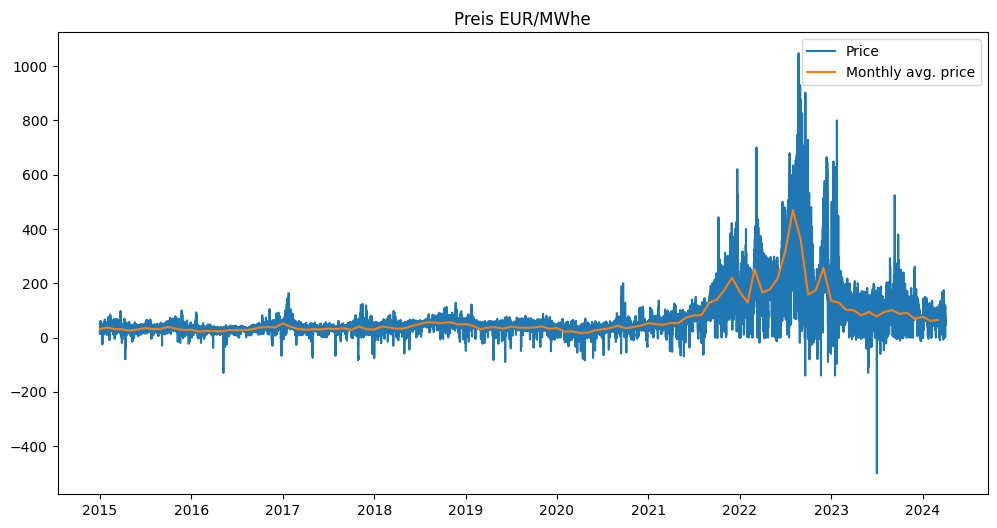

However, at this scale, the data might not be very indicative. To gain further insight, a simple decomposition is done on the span of the last four weeks.
Here, the seasonal window clearly shows each day, with 28 distinct repeating patterns, showcasing the individual days and indicating a strong dailiy cycle. The trend window on the other hand, indicates a lowered prices on weekends.
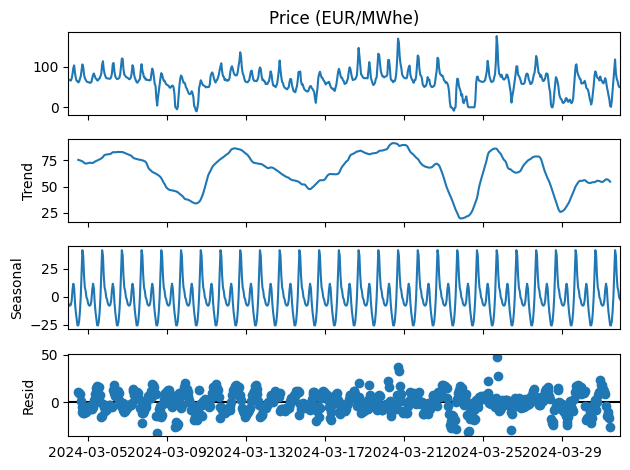

A plot of the electricity price throughout the course of the day reveals two peaks, occurring at approximately 6 a.m. and 5 p.m., respectively. Additionally, the price reaches its lowest point during the night, at 2 a.m. This indicates a pronounced decline in energy consumption, as the production of energy from solar sources is also reduced during nocturnal hours. Conversely, solar production is most active between the hours of 11 a.m. and 4 p.m.
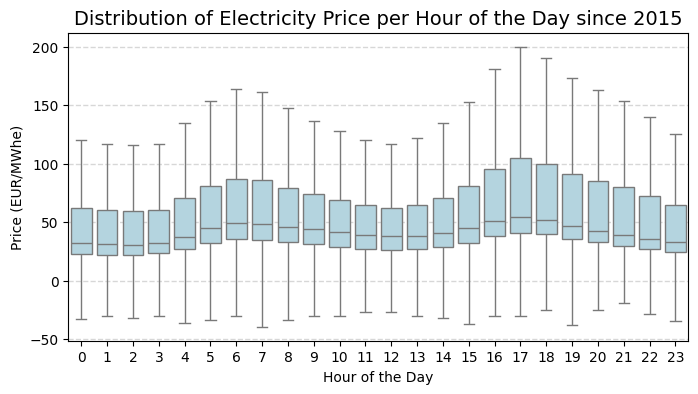

Secondly, let us examine the daily trend over the course of a week. By averaging the values of the entire data set per weekday, it becomes evident that there is a clear downward trend in prices over the weekend, with Sunday in particular being a low point. This can be speculated to be related to lowered consumption.
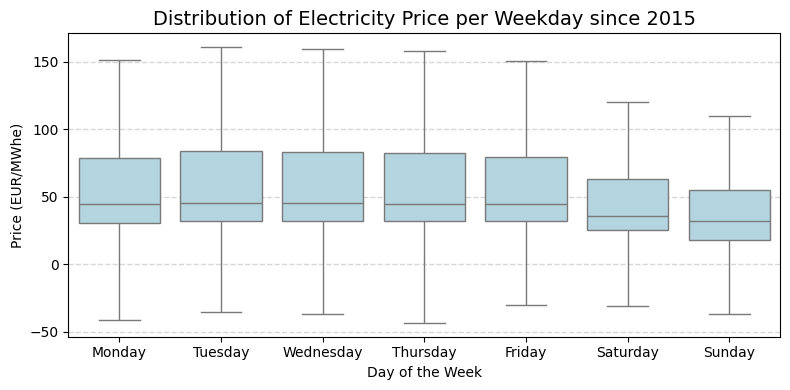

Averaging the months of the year, a further difference is visible. This can be speculated to both pertain to temperatures and therefore heating and weather influences.
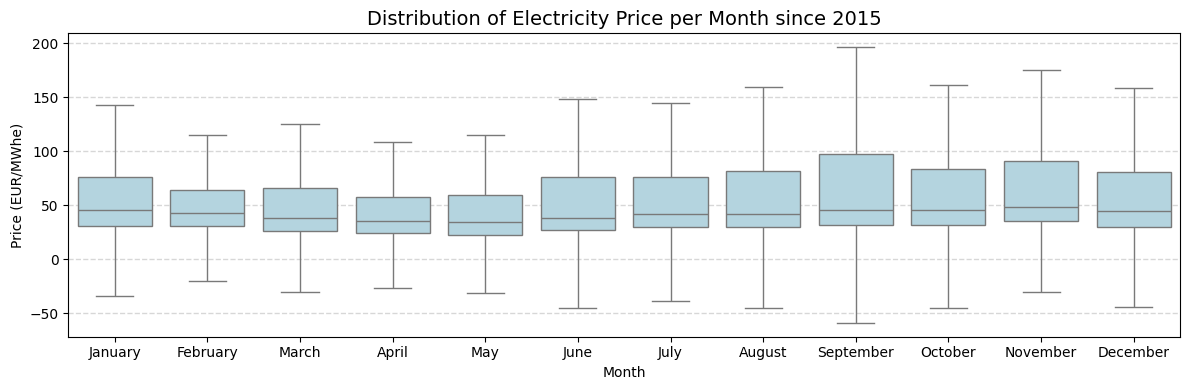

Averaging the individual years, a striking spike during the year 2022 stands out.
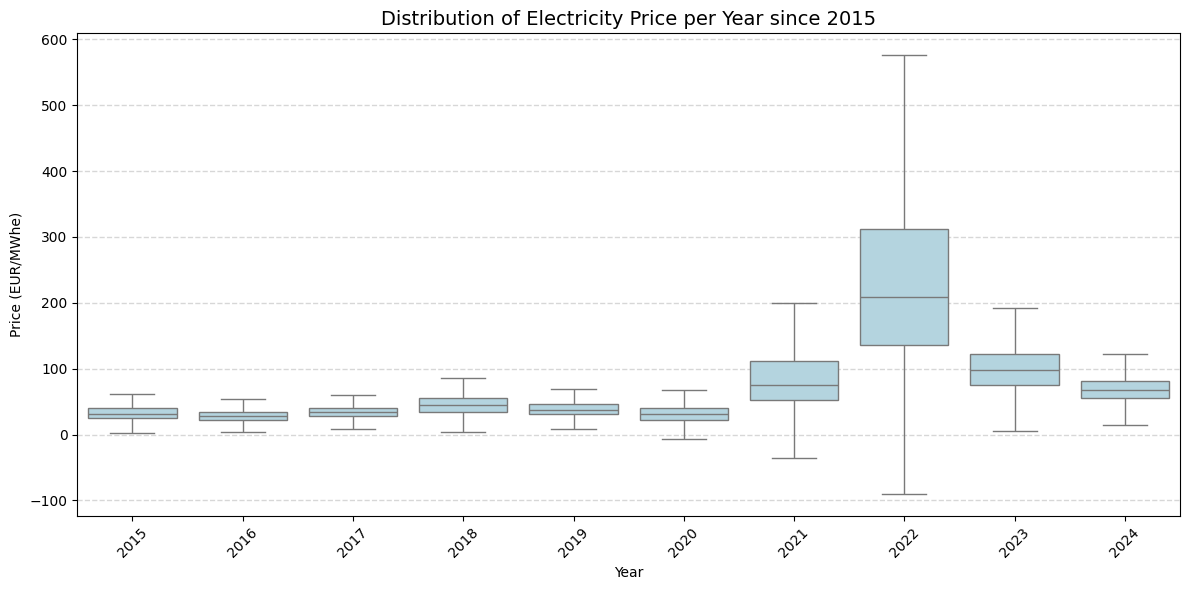
A slight increase due to inflation is to be expected, however the spike clearly superceeds the inflation of 7,9% that year. Inflation data is taken from https://www.finanz-tools.de/inflation/inflationsraten-deutschland
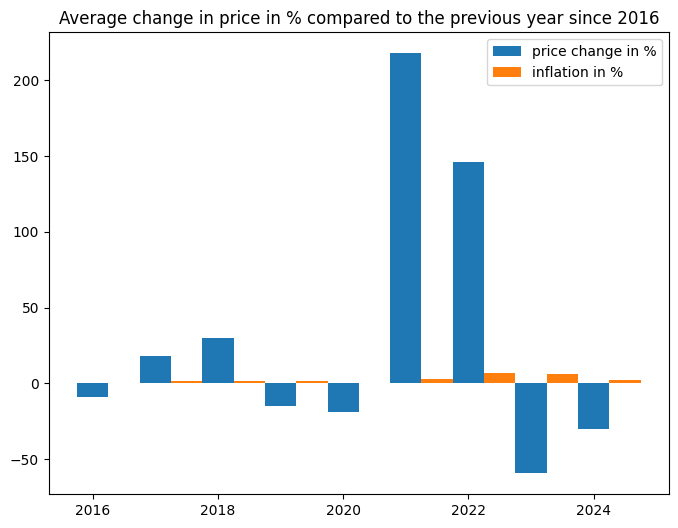



##### Feature Selection
An important step in the process of finding the right features to train the model is to examine the correlation between the variables in the given dataset. Since there are many different features, a heatmap plot is a good way to display them all while still providing a practical overview.

To get a more precise feature selection, the Python library pandas provides a .corr() function which can be used to get the values satisfying a chosen condition, e.g., getting the ten most correlating values relating to 'price'.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#loada dataframe from: /merged_data/data_collection/smard.csv

#for local testing: '/home/user/ai-project/push_to_final_submission/final-submission//merged_data/data_collection/smard.csv'
a_smard_df = pd.read_csv('merged_data/data_collection/smard.csv')
a_smard_df=a_smard_df[a_smard_df.duplicated(keep=False) == False]



#dataslice with fewest NaN entries
a_smard_df_slice = a_smard_df[(pd.to_datetime(a_smard_df['Date'])>=pd.to_datetime('2022-01-31 00:00:00')) & 
(pd.to_datetime(a_smard_df['Date'])<=pd.to_datetime('2022-05-31 00:00:00'))]

a_smard_df = a_smard_df.drop(columns=['Date','End_Date'])
a_smard_df_slice = a_smard_df_slice.drop(columns=['Date','End_Date'])

#plot Abb. 1
a_smard_df_corr=a_smard_df.corr()

plt.figure(figsize=(12, 12))
plt.title("Correlation between features (fig. 1)")
sns.heatmap(a_smard_df_corr, vmin=-1, vmax=1, center=0, cmap='vlag')

plt.show()

This already provides interesting insights into the data and the impact of the variables. Some are shown as an almost complete white line, which means that they do not have significant correlation with any other variable.
This can be caused by multiple reasons, e.g., the variable is missing too many values or the variable has simply no impact on the other ones.
The more saturation the colour of a square has, the more two variables correlate with each other. Blue implies a negative direction (values rise/fall in opposite directions) and red a positive one (values rise/fall in the same direction).

Example variable from SMARD data set on the complete time frame:

In [ ]:
mean_df = a_smard_df.fillna(a_smard_df.mean())
mean_df_slice = a_smard_df_slice.fillna(a_smard_df_slice.mean())

zero_df = a_smard_df.apply(lambda col: col.fillna(0), axis=0)
zero_df_slice = a_smard_df_slice.apply(lambda col: col.fillna(0), axis=0)

fig, axes = plt.subplots(1,2, figsize=(12, 4))
axes[0].scatter(x = mean_df['af_Activation_Price_Minus_EUR_MWh'],y = mean_df['Price_Calculated_EUR_MWh'], alpha=0.5)
axes[0].set_title("Correlation if NaN is filled with mean")

axes[1].scatter(x = zero_df['af_Activation_Price_Minus_EUR_MWh'],y = zero_df['Price_Calculated_EUR_MWh'], alpha=0.5)
axes[1].set_title("Correlation if NaN is filled with zero")
#plt.savefig('corr_full.png')
plt.show()

Example variable from SMARD data set on a smaller selected time frame:

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))
axes[0].scatter(x = mean_df_slice['af_Activation_Price_Minus_EUR_MWh'],y = mean_df_slice['Price_Calculated_EUR_MWh'], alpha=0.5)
axes[0].set_title("Correlation if NaN is filled with mean")

axes[1].scatter(x = zero_df_slice['af_Activation_Price_Minus_EUR_MWh'],y = zero_df_slice['Price_Calculated_EUR_MWh'], alpha=0.5)
axes[1].set_title("Correlation if NaN is filled with zero")
#plt.savefig('corr_slice.png')
plt.show()

In [14]:
#just source for table content below doesn't need to be generated again
#print(a_smard_df.corr().abs().nlargest(5,'Price_Calculated_EUR_MWh').index)
#print(mean_df.corr().abs().nlargest(5,'Price_Calculated_EUR_MWh').index)
#print(zero_df.corr().abs().nlargest(5,'Price_Calculated_EUR_MWh').index)

Another method to compare the two methods is to print out the variables with the highest correlation after the corresponding changes to the dataset. This comparison was made on the complete time frame.

| Ranking (descending) | Dataset with NaN values            | Dataset with NaN values replaced by mean | Dataset with NaN values replaced by 0      |
|----------------------|------------------------------------|------------------------------------------|--------------------------------------------|
| 1                    | af_​Activation_​Price_​Plus_​EUR_​MWh   | af_​Activation_​Price_​Plus_​EUR_​MWh         | Net_​Income_​EUR                           |
| 2                    | af_​Activation_​Price_​Minus_​EUR_​MWh  | Net_​Income_​EUR                           | Balancing_​Services_​Calculated_​EUR       |
| 3                    | mf_​Activation_​Price_​Plus_​EUR_​MWh   | af_​Activation_​Price_​Minus_​EUR_​MWh        | E_​NorwayImport_​MWh                       |
| 4                    | Net_​Income_​EUR                     | af_​E_​Volume_​Activated_​Minus_​MWh          | E_​NorwayImport_​corssBorderPhysical_​MWh  |

The results show that the choice between filling with zero or filling with the mean can have an impact on the data.

However, more significant is the difference between the usage of a certain smaller section containing much less empty values instead of just using everything that is available. 
Therefore, the priority should be to use less but complete data instead of a dataset with big gaps.

#### Correlation analysis (all data)
- compare/evaluate corr() with methods=spearman/kendall/pearson
- crosscorrelation
- rolling correlation

#### Seasonal Periods with ARIMA
influence of different observations per seasonal cycle (daily, weekly, monthly, yearly)

### Missing Data 

For analysis purposes, the separate columns of the final data frame were checked for missing data, or more accurately, empty entries. These empty entries can have various causes. For example, in the stock market data, there are no values for weekends or holidays. Other columns, like Superbowl or Holidays, have no empty entries as these events are known in advance. This check was done to prevent empty columns in the data frame. In the end, the columns with the highest percentage of missing values were, as expected, the stock market data, with missing values ranging from nearly 50% for uranium to almost 31% for coal. Fortunately, the other columns were more complete, with data points for special occasions and calendar observations (e.g., day of the week) having 0% missing values.

### Comparing Feature Importances

#### AutoGluon

AutoGluon provides feature importance for the best model after training. In the table below, the feature importance for our best model is shown. In this model, the most important features are the generated resources in MWh, while weather and stock market values seem to have lower significance, with some even showing negative importance.

Feature importance is calculated by shuffling the values of a feature and observing whether the model’s performance declines. A negative feature importance value indicates that the feature has a detrimental effect on the model’s performance.

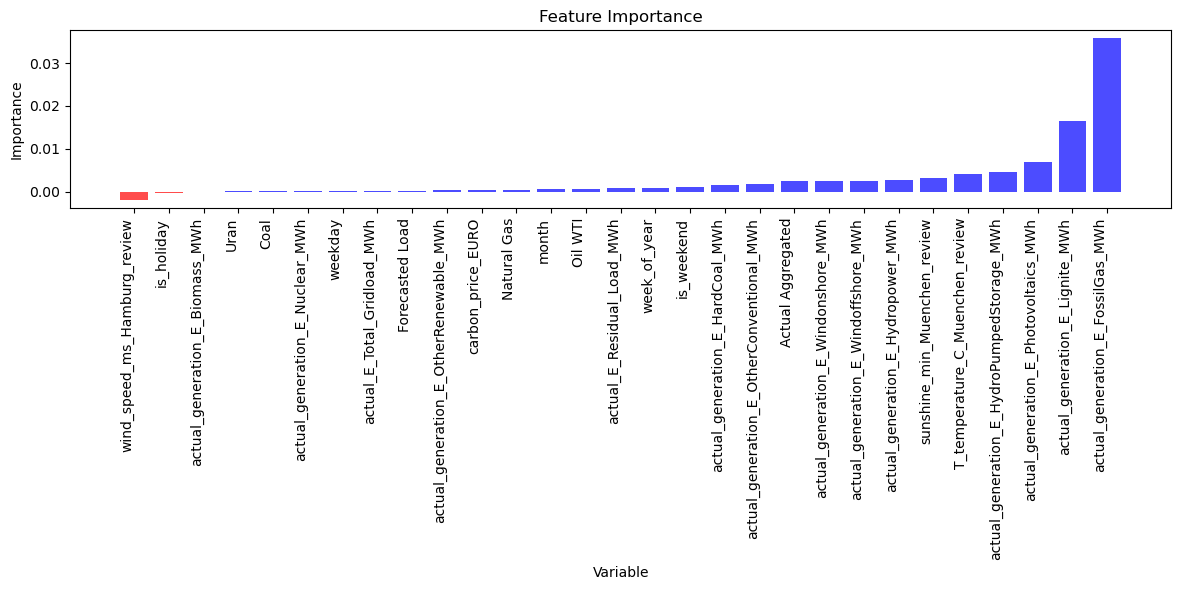

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "temp/feature_importance.csv"
df = pd.read_csv(file_path)

# Sort the DataFrame by 'importance' from lowest to highest
df = df.sort_values(by='importance')

# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Determine colors: red for negative values, blue for positive values
colors = ['red' if val < 0 else 'blue' for val in df['importance']]

# Plot the 'importance' column with the first column as x labels
plt.bar(df.iloc[:, 0], df['importance'], color=colors, alpha=0.7)

# Set labels and title
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Feature Importance')

# Rotate the x labels for better readability
plt.xticks(rotation=90, ha='right')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


#### Temporal Fusion Transformer

One of the benefits of the TFT model for time series forecasting is the fact that it allows for interpretation mostly in the form of feature importance for both encoder and decoder. Moreover, given its embedded multi-head attention mechanism, the level of attention as a function of the time index for the pastime horizon can also be analyzed.

##### Attention

<img src="src/attention.png" alt="Alt text" title="Title" width="500" />
 It can be observed that most of the model attention takes place at the morning and evening times of the past horizon (typically higher electricity prices), as well as in the midday (typically lowest electricity prices).

##### Encoder importance

<img src="src/encoder_variables_importance.png" alt="Alt text" title="Title" width="500" />

Intuitively, electricity prices themselves represent the most important variable to be considered by the model at the time of prediction, namely when encoding the input data. Moreover, considering the fact that besides renewable sources, coal has the largest generation capacity in Germany, the price of this fossil fuel constitutes the second-largest importance for variable encoding.

##### Decoder importance
 <img src="src/decoder_variables_importance.png" alt="Alt text" title="Title" width="500" />
 Finally, at the decoding stage, most importance is regarded towards natural gas prices probably given its higher volatity in comparison with coal prices. Moreover, as is typical for system electricity demand, the time of day has also a high importance at the time of forecast generation.

##### Partial Dependency Plots
partial dependency plots with selected features



### Conclusion

In this chapter, the different sources of data used were explained. Weather, stock market prices, holidays, special events, and COVID-19 pandemic data were sourced, and their usage and possible improvements for future work were discussed. The data was analyzed from different perspectives, such as correlation, missing values, and feature importance in the models used.

## Visualization & Story Telling

The topic of this chapter is the models used for forecasting. The theory behind the models—Linear Regression, Long-Term Short-Term Memory (LSTM), Chronos, and Temporal Fusion Transformer—is explained in detail. At the end, the framework AutoGluon is introduced, where multiple models are trained simultaneously. Approaches for improving the AutoGluon forecasts are also described.

### Baseline Models Benchmark

### LSTM Based Models

At first the dataset which is used by all the upcomming LSTM models is loaded. After loading it is splitted into three intervalls: training, testing and validation. 

In [ ]:
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(lstm_df, target_column='day_ahead_prices_EURO', 
                                                                      train_interval=[pd.Timestamp('2015-01-05 00:00:00'),
                                                                                      pd.Timestamp('2023-11-30 23:00:00')], 
                                                                      test_interval=[pd.Timestamp('2024-06-01 00:00:00'),
                                                                                     pd.Timestamp('2024-11-30 23:00:00')],
                                                                      val_interval=[pd.Timestamp('2023-12-01 00:00:00'),
                                                                                    pd.Timestamp('2024-05-31 23:00:00')])

#### LSTM

An LSTM (Long Short-Term Memory)[Hochreiter et al. 1997] is a type of RNN (Recurrent Neural Network) designed to address the limitations of traditional RNNs, particularly in handling long-term dependencies in sequential data[Bengio et al. 1993]. Unlike standard RNNs, which suffer from issues like vanishing or exploding gradients [Schmidhuber et al. 2003]. When trying to learn relationships over extended sequences, LSTMs incorporate mechanisms that allow them to retain information over long periods. This makes them especially well-suited for tasks like time series forecasting, where understanding patterns and dependencies over time is crucial. 
To also incorparate multiple input features which might contribute to the day ahead prices, a multivariate LSTM is used. It takes a for each feature an input sequence and outputs a fixed length target sequence.

In [ ]:
# define model
MultiLSTM = MultivariateBiLSTM(features=list(X_train.columns), target='day_ahead_prices_EURO')
# train model
training_history = MultiLSTM.train(X_train=X_train, y_train=y_train,
                                X_val=X_val, y_val=y_val,
                                X_test=X_test, y_test=y_test,
                                n_epochs=200, batch_size=1024, learning_rate=0.001)
# predict
prediction_MultiLSTM = multiLSTM.run_prediction(X_test).set_index('timestamp')

#### Encoder Decoder LSTM

Regular multilayer LSTM face several challenges, particularly in tasks that require a variable length in- or output sequence[Hochreiter et al. 1997]. In time series forecasting this is the case when the steps ahead which need to be predicted differ. Additionally standard multilayer LSTM can suffer from information bottlenecks. This is because the entire input needs to be compressed to a fixed-sized context vector before generating the output which might lead to information loss especially for long input sequences[Sutskever et al. 2014]. Even though LSTM have the ability to handle the vanishing gradient problem better than normal RNN, very long sequences can still lead to a performance decrease[Zhao et al. 2020] [Kandadi et al. 2025].

To address these issues, Seq2Seq (Sequence-to-sequence) models[Sutskever et al. 2014] were introduced. These models consist of two multilayer LSTM's. The first one, the Encoder, processes an entire sequence of input features at each timestamp. Meaning each block in the first layer handles one feature. Encoder output and hidden states are then passes to the second multilayer LSTM, the Decoder. Whose output is then passed through a linear layer to transform the output dimension to match the required output sequence length. As a final step and to ensure the data is in a range between 0 and 1 an sigmoid activation is applied.

In the below code the Encoder Decoder LSTM is created. For this the use_attention is set to False, which applies equal weights to the encoder output.

In [ ]:
# define model
encdecLSTM = EncoderDecoderAttentionLSTM(target_length=24, features=list(X_train.columns), target='day_ahead_prices_EURO',
                                         hidden_size=256, num_layers=6, use_attention=False)
# train model
training_history = encdecLSTM.train(X_train=X_train, y_train=y_train,
                                    X_val=X_val, y_val=y_val,
                                    X_test=X_test, y_test=y_test,
                                    n_epochs=1000, batch_size=2048, learning_rate=0.001)
# predict
prediction_encdecLSTM = encdecLSTM.predict(X=X_train, exp_dir=None).set_index('timestamp')

#### Incorparate Bahdanau Attention

Seq2Seq models without attention faces challenges like limited context representation and difficulty in capturing long-range dependencies. Instead of relying on a single fixed-length context vector, Bahdanau attention [Bahdanau et al. 2014] computes a weighted combination of input sequence elements for each output time step. 

| Steps         |   Graphic |
|:--------------|:----------|
| ![Attention Mechanism description](src/attention_graphic_description.png "Attention Mechanism description") | ![Attention Mechanism](src/attention_graphic.png "Attention Mechanism") |
|  |  |

![Encoder Decoder Attention LSTM](src/enc_dec_att_LSTM_autoreg.png "Encoder Decoder Attention LSTM")

When using the attention mechanism, the context vector is created by calculating a weighted sum of the encoder's output, while without attention only the encoder’s output is used. This context vector then gets processed by the decoder to generate the output sequence step-by-step. Which allows the model to focus on the most relevant parts of the input sequence when predicting each target value. By leveraging this mechanism, the model can better handle complex temporal relationships. This significantly improves performance, especially for long sequences, as the model does not have to compress all information into a single bottleneck.

In [ ]:
# define model
encdecattLSTM = EncoderDecoderAttentionLSTM(target_length=24, features=list(X_train.columns), target='day_ahead_prices_EURO',
                                            hidden_size=256, num_layers=6, use_attention=True)
# train model
training_history = encdecattLSTM.train(X_train=X_train, y_train=y_train,
                                       X_val=X_val, y_val=y_val,
                                       X_test=X_test, y_test=y_test,
                                       n_epochs=1000, batch_size=2048, learning_rate=0.001)
# predict
prediction_encdecattLSTM = encdecattLSTM.predict(X=X_train, exp_dir=None).set_index('timestamp')

#### Compare LSTM models

To evaluate which LSTM based model from the above three performs the best, MAE and RMSE are used as metrics. 

In [ ]:
# compare LSTM based models on test data
BenchMaker = BenchmarkMaker(export_dir='result')
BenchMaker.load_dataframes(predictions={'MultivarLSTM': prediction_MultiLSTM,
                                        'EncDecAttLSTM': prediction_encdecLSTM,
                                        'EncDecLSTM': prediction_encdecattLSTM}, prices=y_test)
BenchMaker.calc_errors()

BenchMaker.plot_compare_mae()
BenchMaker.plot_compare_rmse()

### Chronos

Chronos is a framework for pre-trained probabilistic time series models introduced by Ansari et al (2024). It tokenizes time series values into a fixed vocabulary through scaling and quantization and trains transformer-based large language models on these tokens. Chronos is designed without time-series-specific architecture except from the tokenization technique, resulting in a minimalistic yet effective approach. Still, the framework achieved remarkable results in in-domain experiments and demonstrated competitive zero-shot performance, comparable to models specifically trained on similar tasks.

![alt text](src/Chronos_Process.png "Title")

High-level depiction of Chronos copied from Ansari et al.


Chronos is built on Google's T5 architecture, which was introduced by Vaswani et al. (2017) and has gained significant popularity since then. However, a key difference between Chronos and the original T5 architecture is the reduced vocabulary size of 4096 compared to 32128 of the original T5 architecture, which results in varying parameter counts. Chronos offers five distinct models, with sizes ranging from 8 million to 710 million parameters.

Chronos can further be optimized by fine-tuning it on additional data. To improve its performance in forecasting the electricity marked we used the day-ahead electricity prices from ENTSO-E as a domain-specific dataset. The tiny model was chosen for its practicality, as it can be fine-tuned and utilized for forecasting tasks even on a standard laptop. To gain deeper insights into the impact of the dataset size and training steps on model performance, we conducted fine-tuning experiments in four distinct ways.

As explained in <a id="Gathering Domain Knowledge">Gathering Domain Knowledge</a> the day-ahead-prices for energy has experienced heightened volatility in recent years. To evaluate the impact of dataset characteristics on model performance, we divided the data into two subsets. The first dataset contains day-ahead prices from January 2022 to December 2023, and the second one data spanning from January 2015 to December 2023. The smaller dataset focuses primarily on recent, highly volatile market conditions, reflecting current dynamics. In contrast, the larger dataset spans a longer historical period, capturing a broader range of market scenarios. This approach enables a direct comparison to determine whether the smaller, more focused dataset enhances adaptability to recent volatility or if the larger dataset provides a more comprehensive foundation due to its diversity. Ansari et al. propose fine-tuning for 1000 steps and achieved remarkable results. In a single training step, a batch of sequences from the dataset is processed to optimize the model’s weights. The input consists of 32 sequences - the batch size and each sequence contains 512 tokens - the context length. Additionally, to the proposed 1000 training steps we investigated results for 10000 training steps. To determine which configuration performs best for the challenge of predicting 24-hour day-ahead energy prices, we conducted forecasts for a full year, from the beginning of December 2023 to the end of November 2024. For each forecasted day, the context data consisted of the most recent 512 hourly day-ahead prices.

The results are computes as following. For each 24 values of one day we calculated the root mean squared error and the absolute error. For each day the mean of these values are calculated and over the whole year the mean is created again. The yearly Results of the Chronos-T5 (Tiny) model and its fine-tuned versions are presented in the table below.

|Chronos-T5 (Tiny)    |1. Zero-Shot  |2. Fine-Tuned Data: 2015 Steps: 1000|3. Fine-Tuned Data: 2015 Steps: 10000|4. Fine-Tuned Data: 2022 Steps: 1000|5. Fine-Tuned Data: 2022 Steps: 10000|
|------------|------------|------------|------------|------------|------------|
| RMSE              | 25.817  | <b>22.739</b>    | 23.501 | 24.552 | 26.413 |
| RMSE %   | <b>117.48%</b> | 120.92%   | 146.55% | 128.25% | 137.28% |
| MAE               | 20.127  | <b>17.254</b>    | 17.969 | 18.59 | 20.263 |
| MAE %    | 2637.80% | <b>2484.01%</b> | 3311.03% | 3168.22% | 4038.85% |

As can be seen in the results not all fine-tuned models outperform the baseline. Models fine-tuned on the larger dataset, which includes data from 2015, tend to perform better than those fine-tuned on the smaller, more recent dataset. This may be due to the fact that, although the energy market is currently highly volatile, less volatile days dominate the market, making the larger dataset, with its broader range of scenarios, more beneficial. Furthermore, the models trained with 1000 steps, rather than 10000, tend to perform better, likely due to overfitting.

Interesting is that model three and four have still a better performance in the MAE and RMSE, but its corresponding percentage value are outperformed by the baseline. A reason might be that with the pretraining the overall error is reduced, but the models are getting worse in predicting extreme scenarios like energy prices close to zero euros.

We can observe that the MAE percentage and RMSE percentage values are unexpectedly high. This occurs because these metrics are dominated by a few days, where the actual day-ahead price is close to zero, resulting in extremely high values. Therefore, for further evaluation, we focus on the RMSE and MAE values instead.

The model which was fine-tuned on the large dataset with 1000 training steps performs the best. This model has the lowest RMSE and MAE. On average the difference between the predicted hourly day-ahead price and its actual value is 17.254 Euros.

Model five is outperformed by the baseline in all metrics.

We use both the uploaded fine-tuned models and a pretrained model to forecast a defined period. A comparison of Model One and Model Two is visualized in the following two graphs. Each model forecasts the period from February 14, 2024, to February 23, 2024, which includes the challenge date—February 18—exactly one year earlier.

In [5]:

start_time = "2024-02-14 00:00:00"
end_time = "2024-02-22 23:00:00"

model1 = "amazon/chronos-t5-tiny"
forecast1 = chronosForecast(model1, start_time, end_time)

model2 = "juliushanusch/chronos-tiny-fine-tuned-day-ahead-prices"
forecast2 = chronosForecast(model2, start_time, end_time)


In [ ]:

# Set up the figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for model1 (forecast1)
axs[0].plot(forecast1['timestamp'], forecast1['actual_value'], label='Actual', color='blue', linestyle='-', linewidth=2)
axs[0].plot(forecast1['timestamp'], forecast1['forecasted_values'], label='Forecasted', color='orange', linestyle='--', linewidth=2)
axs[0].plot(forecast1['timestamp'], forecast1['absolute_error'], label='Absolute Error', color='red', linestyle=':', linewidth=2)

axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Value')
axs[0].set_title(f'Actual vs Forecasted Values with Absolute Error \n Model: {model1}')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)

# Plot for model2 (forecast2)
axs[1].plot(forecast2['timestamp'], forecast2['actual_value'], label='Actual', color='blue', linestyle='-', linewidth=2)
axs[1].plot(forecast2['timestamp'], forecast2['forecasted_values'], label='Forecasted', color='orange', linestyle='--', linewidth=2)
axs[1].plot(forecast2['timestamp'], forecast2['absolute_error'], label='Absolute Error', color='red', linestyle=':', linewidth=2)

axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Value')
axs[1].set_title(f'Actual vs Forecasted Values with Absolute Error \n Model: {model2}')
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)

axs[0].grid(True, linewidth=0.5, linestyle='--', alpha=0.7)
axs[1].grid(True, linewidth=0.5, linestyle='--', alpha=0.7)


# Adjust the layout to make sure there is no overlap
plt.tight_layout()

# Show the plot
plt.show()

As previously mentioned, several sizes of Chronos models are available. In addition to the Chronos-T5 (Tiny) model, we evaluated the performance of the Chronos-T5 (Large) model. For this model, we applied the same fine-tuning steps as we did for the Chronos-T5 (Tiny) model.
The Chronos-T5 (Large) model contains approximately 88 times more parameters compared to the tiny model and is therefore expected to perform better than the Chronos-T5 (Tiny) model. However, this comes at the cost of significantly higher computational requirements, both in terms of training and forecasting.

The yearly Results of the Chronos-T5 (Large) model and its fine-tuned versions are presented in the table below.

|Chronos-T5 (Large)    |1. Zero-Shot  |2. Fine-Tuned Data: 2015 Steps: 1000|3. Fine-Tuned Data: 2015 Steps: 10000|4. Fine-Tuned Data: 2022 Steps: 1000|5. Fine-Tuned Data: 2022 Steps: 10000|
|------------|------------|------------|------------|------------|------------|
| RMSE | 22.450 | <b>21.052</b> | 22.072 | 22.744 | 22.304 |
| RMSE % | 111.78% | 124.34% | 142.17% | 122.61% | <b>110.01%</b> |
| MAE | 17.142| <b>15.850</b>| 16.747 | 17.183 | 16.952 |
| MAE % | <b>2395.71%</b> | 2577.38% | 3054.47% | 3089.52% | 3153.29% |

As expected, the large model performs better compared to the tiny models. We observe similar results in fine-tuning as seen with the tiny models. Once again, the models trained on the smaller dataset outperform those trained on the larger dataset. Interestingly, the non-fine-tuned Chronos-T5 (Large) model performs quite similarly to the Chronos-T5 (Tiny) model fine-tuned on the larger dataset with 1,000 training steps.

Model two emerges as the best-performing model overall. It achieves an average difference of just 15.85 Euros.

The comparison of the large fine-tuned model number two with model number one is visualized in the graphs below.

In [10]:
model3 = "amazon/chronos-t5-large"
forecast3 = chronosForecast(model1, start_time, end_time)

model4 = "juliushanusch/chronos-large-fine-tuned-day-ahead-prices"
forecast4 = chronosForecast(model2, start_time, end_time)


In [ ]:
    

# Set up the figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for model1 (forecast1)
axs[0].plot(forecast3['timestamp'], forecast3['actual_value'], label='Actual', color='blue', linestyle='-', linewidth=2)
axs[0].plot(forecast3['timestamp'], forecast3['forecasted_values'], label='Forecasted', color='orange', linestyle='--', linewidth=2)
axs[0].plot(forecast3['timestamp'], forecast3['absolute_error'], label='Absolute Error', color='red', linestyle=':', linewidth=2)

axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Value')
axs[0].set_title(f'Actual vs Forecasted Values with Absolute Error \n Model: {model3}')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)

# Plot for model2 (forecast2)
axs[1].plot(forecast4['timestamp'], forecast4['actual_value'], label='Actual', color='blue', linestyle='-', linewidth=2)
axs[1].plot(forecast4['timestamp'], forecast4['forecasted_values'], label='Forecasted', color='orange', linestyle='--', linewidth=2)
axs[1].plot(forecast4['timestamp'], forecast4['absolute_error'], label='Absolute Error', color='red', linestyle=':', linewidth=2)

axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Value')
axs[1].set_title(f'Actual vs Forecasted Values with Absolute Error \n Model: {model4}')
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)

axs[0].grid(True, linewidth=0.5, linestyle='--', alpha=0.7)
axs[1].grid(True, linewidth=0.5, linestyle='--', alpha=0.7)


# Adjust the layout to make sure there is no overlap
plt.tight_layout()

# Show the plot
plt.show()



The two best performing fine-tuned models have been uploaded to huggingface and are available for use.

We demonstrated that fine-tuning the models can significantly improve the performance of certain models. To further enhance the Chronos models, hyperparameter optimization could be a promising approach. By performing such optimization, it may be possible to identify the best-performing configuration for a specific use case.

### Temporal Fusion Transformer

#### Main concepts

Temporal Fusion Transformers (TFT) are a novel framework designed to address the complexities of multi-horizon time series forecasting. First introduced by Lim et al. in 2019 [Lim et al. 2019], TFT bridges the gap between high prediction accuracy and interpretability, making it uniquely suited for real-world applications where both performance and understanding are important. Traditional time series models often struggle to accommodate diverse data types or fail to provide insights into their decision-making processes. TFT resolves these challenges by integrating modern deep learning techniques with interpretable mechanisms.

The model is particularly well-suited for datasets with mixed input types, such as historical data, future known covariates, and static features that do not vary with time. TFT excels in various domains, including finance, energy demand prediction, healthcare forecasting, and supply chain optimization, where data is abundant but understanding the temporal relationships and influences is critical. Its architecture is modular, enabling flexibility and extensibility while maintaining transparency in the decision-making process.

#### Model Architechture

The TFT architecture comprises several components that work together to extract meaningful patterns from complex temporal data. Below is a detailed explanation of its key building blocks:

1. Variable Selection Layers:
Variable selection layers dynamically identify and prioritize relevant features from the input data at each time step. This mechanism allows the model to adapt to changing conditions and reduces noise from irrelevant inputs, improving both accuracy and interpretability.

2. Gating Mechanisms:
To prevent overfitting and enhance robustness, gating mechanisms selectively control the flow of information through the network. By suppressing irrelevant or redundant components, these gates ensure that only the most informative features contribute to the forecast.

3. Sequence-to-Sequence Layer:
TFT employs recurrent layers, such as Long Short-Term Memory (LSTM) networks, to model local temporal dependencies. These layers process sequential data and extract short-term trends, capturing temporal relationships that are critical for accurate forecasting.

4. Static Covariate Encoders:
Static covariate encoders handle time-invariant features, such as demographic information or geographical context, that provide essential context for the forecasts. These encoders integrate static information into the temporal modeling process, ensuring consistency throughout the prediction horizon.

5. Interpretable Multi-Head Attention Layers:
Attention mechanisms allow the model to focus on specific time steps that are most influential for the forecast. By assigning different weights to historical and future inputs, TFT provides insights into the long-term dependencies and temporal dynamics underlying the predictions. This component is especially valuable for the model interpretability, as it highlights which parts of the data significantly impact the results.

6. Fully Connected Output Layers:
The final layers aggregate information from the previous components and produce the multi-step forecasts. These outputs can be tailored for specific objectives, such as point predictions or probabilistic forecasts, depending on the application.

A depiction of all model components and its interactions is shown below

![alt text](src/tft.png "Title")

#### Implementation in the forecasting of day-ahead electricity prices

Given its flexibility to consider multiple types of covariate information, which foremost represent surrogates of supply and demand (i.e. weather forecasts, holidays, generation capacities and outages), TFT is specially well suited for the forecasting of day-ahead electricity prices. For this aim, the following variables are included in the model:

| Data variable                  | Variable type                        | Units             | Source           | Comments                                                                                              |
|:-------------------------------|:-------------------------------------|:------------------|:-----------------|:-----------------------------------------------------------------------------------------------------|
| Electricity price              | target predicted variable            | EUR / MWh         | ENTSO-E          |                                                                                                      |
| Day ahead forecasted system load | time-varying known real input        | MW                | ENTSO-E          | Values are released hours before day ahead gate closure                                              |
| Actual system load             | time-varying unknown real input      | MW                | ENTSO-E          |                                                                                                      |
| Generation capacities          | time-varying known real input        | MW                | ENTSO-E          | Capacities include known generation and production outages                                           |
| Fossil-Fuel prices             | time-varying known real input        | EUR / MWh         | Eikon datastream |                                                                                                      |
| Sunshine hours                 | time-varying unknown real input      | minutes per hour  | DWD              | Stations considered: Brocken, München Flughafen, Hamburg-Fuhlsbüttel, Köln/Bonn, Leipzig/Halle       |
| Wind speed                     | time-varying unknown real input      | m/s               | DWD              | Stations considered: Brocken, München Flughafen, Hamburg-Fuhlsbüttel, Köln/Bonn, Leipzig/Halle       |
| Holidays                       | time-varying known categorical input | NA                | NA               | Holiday considering its name and each federal state                                                  |
| Date features                  | time-varying known real input        | NA                | NA               | Encoded as sine and cosine of hour of day, day of week and month of year                              |



With this data considered, up to date our model has been trained considering the timeframe from October 2018 (stablishment of DE_LU as bidding zone) up to November 2024 (inclusive). Furthermore, day-ahead forecasting tests have been conducted for all days of december 2024 achieving an average MAPE of 60.25 % and an average  MAE of 32.66 EUR/MWh. In this regard, extreme values for electricity prices took place, specially given very low and high values for wind energy generation, which along with solar generation, are indirectly considered as unknown real inputs in this model. Below such forecast results are depicted:

![alt text](src/max_mae.png "Title")
![alt text](src/max_mape.png "Title")

It can be seen for instance, that for the 12th of December 2024, very high electricity prices where experienced given a relative standstill in wind and solar generation (so called Dunkelflaute). In turn, for the 21st of December, large amounts of renewable generation took place, thus driving electricity prices to quite low values.

Interestingly, the TFT model achieved relatively very good prediction results for several days of this month. Below are two of thes cases:

![alt text](src/min_mae.png "Title")
![alt text](src/min_mape.png "Title")




### AutoGluon

For our prediction of the day-ahead prices, we also used the open-source AutoML library AutoGluon. AutoGluon has three modes of operation: Tabular, Multimodal, and Time Series. In our predictions, Time Series Forecasting is used, as it can forecast future values of multiple time series when given previous data. A special feature AutoGluon provides its users is that multiple models are trained simultaneously to predict values, and at the end, the forecast from the best model is the output. This means that AutoGluon offers its users the ability to test multiple models and optimize the results without much prior knowledge or manual testing.

We provided AutoGluon with our data frame and divided our features into three categories: static data, known covariates, and past covariates.

- Static values: Data points like location that do not change over time; there is no such data point in our data frame.

- Known covariates: Data points that are known for the future, e.g., day of the week, weather forecast, and holidays/special occasions.

- Past covariates: Data points that are not known in the future, e.g., stock market values, cross-border energy flows.

As we have collected data from 2015 until now for around 150 data points, it is an enormous amount of data and presents many challenges for processing. Before running with the whole data frame, AutoGluon checks the data for various issues, e.g., too many NULL values or incompatible data types. Since we had already checked our data beforehand, these checks passed without problems. Another test is correlation between data points. If two data points are too closely correlated, AutoGluon removes one from the calculations to avoid spending unnecessary computation time. AG also automatically checks if certain models require longer training time than allocated by the user. In such cases, AG automatically skips training that model and moves on to the next.

As mentioned above, AutoGluon trains many models but can also train models specifically chosen by the user. These models range from naive forecasts (which set the forecast to the last observed value) to Temporal Fusion Models and Chronos Models mentioned above. Since these models do not need to be implemented separately, no decision needs to be made in advance, and models can simply be chosen for their results at the end. AG also provides a forecast using a Weighted Ensemble Model, which takes the best-performing models from the training and combines them for an even better forecast. Additionally, AG offers users the opportunity to use different presets and hyperparameters for each model. Presets range from medium_quality to best_quality, where the duration of training increases significantly. Hyperparameters can be chosen for each model separately, or AG can use default values.

To evaluate these models, AG offers various metrics from which the user can choose: SQL, WGL, MAE, MAPE, MASE, MSE, RMSE, RMSLE, RMSSE, SMAPE, and WAPE. For our purposes, we selected MSE (mean squared error) and MAPE (mean absolute percentage error). We also compared the training duration for the different presets.

#### Start basic Autogluon code

In [ ]:
preset_list = ["high_quality", "best_quality", "fast_training", "medium_quality", "hp1"]
set_time_limit = None
output_folder_autogluon = f"/data/horse/ws/fewa833b-time-series-forecast/AutoGluon/Felix/AllInOne"

#Start baseline
dataset = 'dayhead'
loaded_dataframe, file_path, data = dataset_Setup(dataset)
correlation_output_folder = os.path.join(output_folder_autogluon, "Correlation", "Baseline")
correlation_calculation(data, correlation_output_folder)
provide_known_covariables = None
set_preset = "fast_training"
train_autogluon(set_preset, set_time_limit, dataset, provide_known_covariables, output_folder_autogluon,
                loaded_dataframe, file_path, data)

#start all-data
dataset = 'all'
correlation_output_folder = os.path.join(output_folder_autogluon, "Correlation", "Less-Data")
correlation_calculation(data, correlation_output_folder)
for set_preset in preset_list:
    provide_known_covariables = None
    train_autogluon(set_preset, set_time_limit, dataset, provide_known_covariables, output_folder_autogluon,
                    loaded_dataframe, file_path, data)

    provide_known_covariables = True
    train_autogluon(set_preset, set_time_limit, dataset, provide_known_covariables, output_folder_autogluon,
                    loaded_dataframe, file_path, data)

#start less-data
dataset = "less"
correlation_output_folder = os.path.join(output_folder_autogluon, "Correlation", "Less-Data")
correlation_calculation(data, correlation_output_folder)
for set_preset in preset_list:
    provide_known_covariables = None
    train_autogluon(set_preset, set_time_limit, dataset, provide_known_covariables, output_folder_autogluon,
                    loaded_dataframe, file_path, data)

    provide_known_covariables = True
    train_autogluon(set_preset, set_time_limit, dataset, provide_known_covariables, output_folder_autogluon,
                    loaded_dataframe, file_path, data)

### Tuning AutoGluon

In the AutoGluon group, an attempt was made to optimise the prediction with AutoGluon by using different settings. The aim was to evaluate the performance of different approaches and to analyse the importance of additional data and external influencing factors. For this purpose, different AutoGluon presets were used, including best_quality, fast_training, high_quality, medium_quality and two customised configurations with user-defined hyperparameters (hp1 and hp2).
The models were trained on two distinct datasets:
1. allData.csv: A comprehensive dataset with over 150 data points per hour, providing a detailed basis for more accurate predictions.
2. lessData.csv: A reduced data set with around 30 data points per hour, which represents whether the model can also make good predictions with less data

As part of the investigation of the effects of external factors on the prediction quality, the training runs were carried out in two variants. In the first variant, known covariates such as the day (e.g. weekday or public holiday) and weather conditions (e.g. temperature or precipitation) were included in the modelling. In the second variant, on the other hand, only the time stamps and the target value were used to optimise the models.

To evaluate the effectiveness of the different approaches, a simple baseline was used as a reference point, which only used the time and the day-ahead price as input data. The aim was to determine the potential improvements in forecast accuracy through additional data points.

/var/folders/km/2p9w9k150f7ddl_dd2zttlg00000gn/T/ipykernel_51647/1217455771.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(df['Labels'], rotation=45, ha='right')
/var/folders/km/2p9w9k150f7ddl_dd2zttlg00000gn/T/ipykernel_51647/1217455771.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(df['Labels'], rotation=45, ha='right')


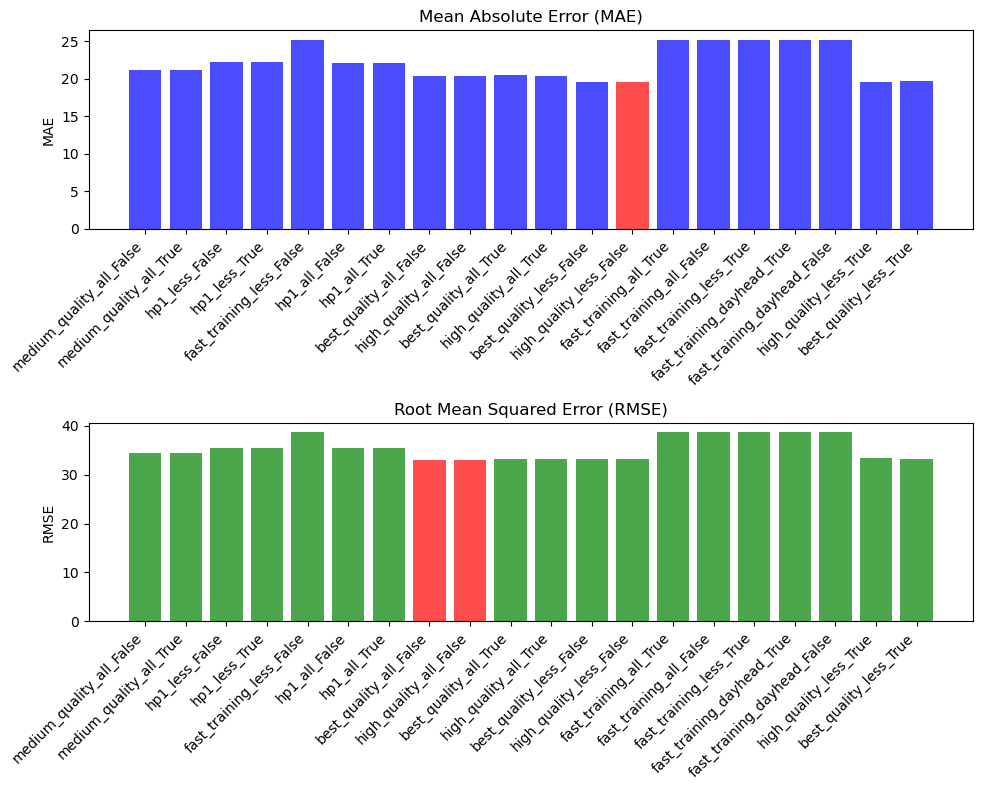

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the CSV file into a pandas DataFrame
file_path = "temp/preset-comparison.csv"
df = pd.read_csv(file_path)

# Ensure 'Knowncoavariables' is treated as a string and replace NaN or empty values with 'False'
df['Knowncoavariables'] = df['Knowncoavariables'].fillna('False').astype(str)

# Create bar labels: Modelpreset_Dataset_Knowncoavariables
df['Labels'] = df['Modelpreset'] + '_' + df['Dataset'] + '_' + df['Knowncoavariables']

# Create the plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# MAE Plot
colors_mae = ['blue' if value != df['MAE SKlearn'].min() else 'red' for value in df['MAE SKlearn']]
ax[0].bar(df['Labels'], df['MAE SKlearn'], color=colors_mae, alpha=0.7)
ax[0].set_title('Mean Absolute Error (MAE)')
ax[0].set_ylabel('MAE')
ax[0].set_xticklabels(df['Labels'], rotation=45, ha='right')


# RMSE Plot
colors_rmse = ['green' if value != df['RMSE SKlearn'].min() else 'red' for value in df['RMSE SKlearn']]
ax[1].bar(df['Labels'], df['RMSE SKlearn'], color=colors_rmse, alpha=0.7)
ax[1].set_title('Root Mean Squared Error (RMSE)')
ax[1].set_ylabel('RMSE')
ax[1].set_xticklabels(df['Labels'], rotation=45, ha='right')

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

The results for the different model variants are represented in the plot above. The red columns represent the best models for the given error metric, MAE and RMSE. Our best model for the MAE metric is "high_quality_less_False", which means that the model used high quality as a preset with the smaller dataset and no known covariants. For RMSE the best models are "best_quality_all_False" and "high_quality_all_False". The full results can be found in the table below.

| Dataset  | Modelpreset   | Knowncovariables | MAE SKlearn         | RMSE SKlearn        | Duration          | Date                 |
|----------|---------------|------------------|---------------------|---------------------|-------------------|----------------------|
| less     | high_quality  |                  | 19.531173           | 33.233518           | 5154.464085        | 2025.01.31-21.42      |
| less     | best_quality  |                  | 19.567993           | 33.270938           | 5080.500499        | 2025.01.31-21.42      |
| less     | high_quality  | True             | 19.576595           | 33.321564           | 7029.284805        | 2025.01.31-21.45      |
| less     | best_quality  | True             | 19.628429           | 33.312971           | 12851.585242       | 2025.01.31-21.45      |
| all      | high_quality  |                  | 20.320766           | 33.080777           | 2983.918289        | 2025.01.31-21.42      |
| all      | best_quality  |                  | 20.320766           | 33.080777           | 3000.135508        | 2025.01.31-21.41      |
| all      | high_quality  | True             | 20.407920           | 33.204833           | 3051.776926        | 2025.01.31-21.45      |
| all      | best_quality  | True             | 20.414214           | 33.201691           | 3009.794860        | 2025.01.31-21.45      |
| all      | medium_quality| True             | 21.115971           | 34.474631           | 1446.240265        | 2025.01.31-21.45      |
| all      | medium_quality|                  | 21.115971           | 34.474631           | 1460.178653        | 2025.01.31-21.42      |
| all      | hp1           |                  | 22.025243           | 35.500407           | 2766.880437        | 2025.01.31-21.42      |
| all      | hp1           | True             | 22.029175           | 35.511421           | 2757.887008        | 2025.01.31-21.45      |
| less     | hp1           | True             | 22.158505           | 35.435223           | 2023.037322        | 2025.01.31-21.45      |
| less     | hp1           |                  | 22.158505           | 35.435223           | 2105.078335        | 2025.01.31-21.42      |
| less     | fast_training |                  | 25.166567           | 38.683682           | 2621.761761        | 2025.01.31-21.42      |
| all      | fast_training | True             | 25.166567           | 38.683682           | 6533.263905        | 2025.01.31-21.45      |
| all      | fast_training |                  | 25.166567           | 38.683682           | 6936.625601        | 2025.01.31-21.42      |
| less     | fast_training | True             | 25.166567           | 38.683682           | 6740.390500        | 2025.01.31-21.45      |
| dayhead  | fast_training | True             | 25.166567           | 38.683682           | 6910.754145        | 2025.01.31-21.45      |
| dayhead  | fast_training |                  | 25.166567           | 38.683682           | 7143.279896        | 2025.01.31-21.41      |



Furthermore, an analysis was conducted to determine the extent to which the selection of presets affects the computing time and the outcomes obtained. The investigation focused on whether less complex presets, such as fast_training, could achieve results in a significantly shorter time while maintaining a marginally lower level of accuracy under specific conditions. This trade-off between computing time and model performance is of particular relevance when models are updated with additional data at a later stage to enhance resource efficiency. However, this hypothesis could not be substantiated within the scope of the present study.

In our results, the preset for fast_training consistently produced worse outcomes and required more training time than other model types. In the plot below, our results are compared to the training duration of each model. While fast_training can be ruled out, the best_quality preset performs better while also having a shorter runtime.

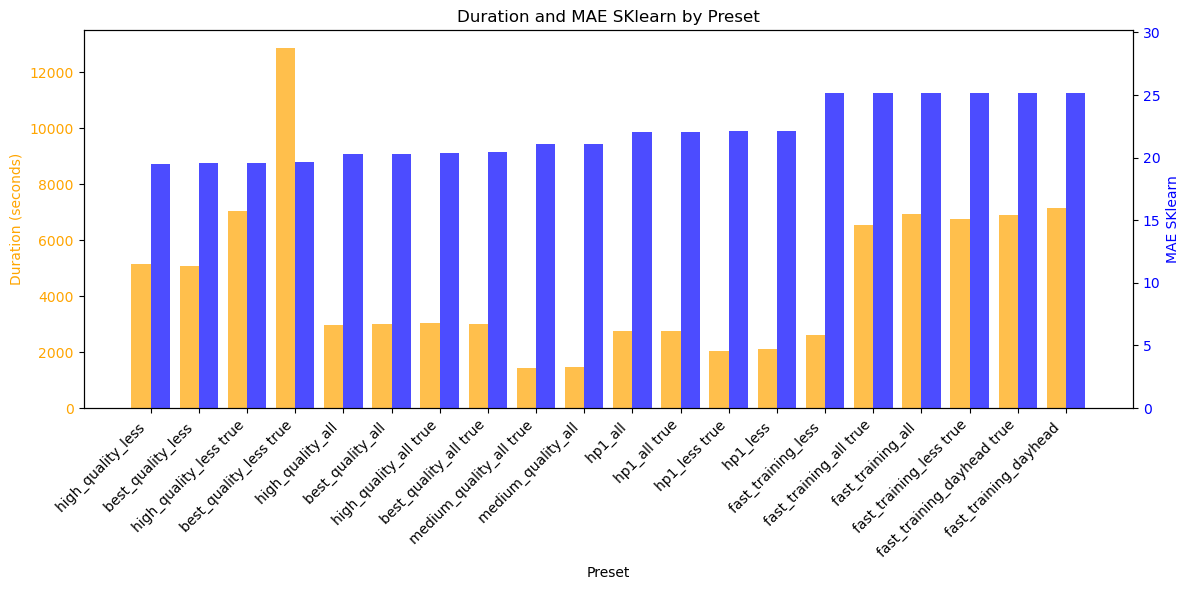

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "temp/preset-comparison.csv"
df = pd.read_csv(file_path)
df['Knowncoavariables'] = df['Knowncoavariables'].apply(lambda x: 'true' if x is True else '')

if df['MAE SKlearn'].dtype == object:  # If the column is of object type (strings)
    df['MAE SKlearn'] = df['MAE SKlearn'].str.replace('%', '').astype(float)

df = df.sort_values(by='MAE SKlearn')

# y- and x-axis
fig, ax1 = plt.subplots(figsize=(12, 6))
x_positions = np.arange(len(df))
ax1.bar(x_positions - 0.2, df['Duration'], color='orange', label='Duration (s)', width=0.4, alpha=0.7)
ax1.set_xlabel('Preset')
ax1.set_ylabel('Duration (seconds)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# y-axis for MAE SKlearn
ax2 = ax1.twinx()
ax2.bar(x_positions + 0.2, df['MAE SKlearn'], color='blue', label='MAE SKlearn', width=0.4, alpha=0.7)
ax2.set_ylabel('MAE SKlearn', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2.set_ylim(0, df['MAE SKlearn'].max() + 5)

# title and labels
ax1.set_xticks(x_positions)
ax1.set_xticklabels(df['Modelpreset'] + "_" + df['Dataset'] + " " + df['Knowncoavariables'], rotation=45, ha="right")

plt.title('Duration and MAE SKlearn by Preset')
fig.tight_layout()
plt.show()


### Innovation / Improving AutoGluon

#### Leveraging News Embeddings

In Germany's energy market, predicting day-ahead electricity prices requires considering multiple market influences. News articles could provide valuable context for these predictions, and embedding models offer a way to utilize this information. Previous research has shown success with news embeddings in financial markets [Picasso et al. 2019] and UK energy markets [Yun Bai et al. 2024].

Day-ahead prices are influenced by factors often reported in news media, including power plant outages, policy changes, international market developments, and geopolitical events. To handle the large volume of daily articles, we proposed generating embeddings to convert this unstructured information into structured vectors.

We used the "all-MiniLM-L6-v2" embedding model, which creates 384-dimensional vectors, later reduced to 8 dimensions using PCA for faster experimentation. For data sources, we evaluated NewsAPI and The Guardian's API, querying articles with energy-related keywords. We tested three configurations over a 30-day period:

| Model Configuration | Validation RMSE |
|---|---|
| NewsAPI embeddings + day-ahead + target | 28.82 |
| Guardian embeddings + day-ahead + target | 27.36 |
| Day-ahead + target (baseline) | 27.86 |

Using The Guardian's historical data, we extended the experiment to 10 years:

| Model Configuration | Test RMSE |
|---|---|
| Guardian embeddings + day-ahead (386 dimensions) | 73.88 |
| Guardian embeddings + day-ahead (PCA 8 dimensions) | 29.09 |
| Day-ahead + target (baseline) | 22.18 |

The results show that news embeddings did not improve the prediction of German day-ahead prices. Future work should focus on finding more relevant news sources for the German market and exploring more complex model architectures that can better handle the embedding data.

In [ ]:
# Inspection of embeddings

guardian_embeddings = pd.read_csv('merged_data/data_collection/guardian_embeddings.csv', parse_dates=['timestamp'])
newsapi_embeddings = pd.read_csv('merged_data/data_collection/newsapi_embeddings.csv', parse_dates=['timestamp'])
day_ahead_prices = pd.read_csv('merged_data/data_collection/day_ahead_prices.csv', parse_dates=['timestamp'])

print("Guardian embeddings:")
print(guardian_embeddings[10:20])

print("NewsApi embeddings:")
print(newsapi_embeddings[10:20])


In [ ]:
# Example inference

guardian_embeddings_day_ahead, newsapi_embeddings_day_ahead, day_ahead_prices_for_prediction, ground_truth = prepare_embedding_data(guardian_embeddings, newsapi_embeddings, day_ahead_prices)

guardian_predictor_path =  "models/models/guardian_embedding_model"
newsapi_predictor_path = "models/models/newsapi_embedding_model"
no_embeddings_predictor_path = "models/models/no_embeddings_model"

guardian_predictions = predict_embedding_data(guardian_predictor_path, guardian_embeddings_day_ahead)
newsapi_predictions = predict_embedding_data(newsapi_predictor_path, newsapi_embeddings_day_ahead)
no_embeddings_predictions = predict_embedding_data(no_embeddings_predictor_path, day_ahead_prices_for_prediction)

visualize_embedding_model_results(guardian_predictions, ground_truth, "Guardian Embeddings")
visualize_embedding_model_results(newsapi_predictions, ground_truth, "NewsAPI Embedddings")
visualize_embedding_model_results(no_embeddings_predictions, ground_truth, "No Embeddings")

#### Predicting Intraday-Prices as additional feature

Besides day-ahead prices, which are the target value of this time series forecast, electric energy is also traded on the more short-term Intraday market.
While in general a high correlation of these prices can be assumed, as they refer to the same underlying product, there are cases in which the prices of day-ahead and intraday trades differ significantly, as the intraday market will react more short-term to unforeseen changes in supply and demand.
These short-term differences can for example be induced by
- extreme weather conditions offsetting forecasted and actual generation of renewables affecting supply
- extreme weather conditions generating an unforeseen surge or decline in demand
- unplanned power plant outages creating a lack of supply
- short-term changes in balancing affecting supply

As Germany saw their share of renewables in power generation rise, the role of intraday prices for demand regulation became increasingly important.
Therefore the "gate closure" of intraday trades, meaning the time between end of trading and delivery, got shortened significantly.
In July 2015 it was changed from 45 to 30 minutes, whereas nowadays it's down to 5 minutes, and allows for a high reactivity to changes in supply and demand. [Smard, Großhandelspreise 15.12.2024]

Given our time series dataset with all features that resulted from data gathering, we tried to predict the intraday price to use as an additional feature in predicting the day-ahead price.
If we were to predict the intraday prices with high accuracy, this could possibly be an important feature for improving the day-ahead prediction.

Data Sources:
The open data sources for intraday electric energy prices are unfortunately very limited, as in many cases stock market data are sold for commercial data analysis.
"Netztransparenz", which is an information transparency platform by the four German transmission grid operators, publishes a dataset with quarter-hourly intraday price indices from 30th June 2020 to date.
These values are calculated as volume-weighted average of the last stock market orders over 500MW for quarter-hourly electricity [Netztransparenz, Index-Ausgleichspreis 16.12.2024].
The dataset of Netztransparenz is to our knowledge the only freely available dataset for German intraday electricity prices.

To investigate the potential of using intraday prices as an additional feature for day-ahead price prediction, a systematic approach was followed, involving the prediction of intraday prices and their integration into the day-ahead prediction.

Following table contains the original quarter-hourly intraday electricity price data as downloaded from the source.

In [ ]:
pd.read_csv('../final-submission/merged_data/data_collection/Intraday_prices_2020_2025_quarter_hourly.csv').head()

To maintain consistency with the day-ahead price data and simplify analysis, the quarter-hourly intraday price data was aggregated into hourly values. This was achieved by calculating the mean of the four quarter-hourly values for each hour, resulting in a manageable dataset with hourly intraday prices that could be used for model training and prediction.

In [ ]:
pd.read_csv('../final-submission/merged_data/data_collection/Intraday_prices_2020_2025_hourly.csv').head()

When examining the data, some strong outliers were clearly visible. Outliers in time series data can distort trends and affect model performance. To address this, we used the z-score method, identifying values exceeding three standard deviations from the mean. This approach effectively detects anomalies while preserving the overall data distribution.
A total of 539 outliers were detected and replaced using a forward-fill approach to maintain data continuity. The plot below illustrates these detected anomalies over time, highlighting significant fluctuations in intraday electricity prices throughout 2024.

![alt text](src/Intraday_price_outliers_2024_plot.png "Intraday price outliers in 2024")

Intraday prices were predicted for the same test set time intervals as used for the day-ahead forecast. The models were trained using only the "timestamp" and "intraday_price_EURO" columns. After testing various configurations, the best results were obtained with the "best_quality" preset using weighted_ensemble.

![alt text](src/Intraday_price_comparison_plots.png "Dayahead price with predicted intraday price comparison")


The left chart above, labeled "MAE Comparison (BASELINE)", shows the Mean Absolute Error (MAE) for three different scenarios: the baseline model, the model utilizing historical intraday data (assuming perfect predictions of intraday prices), and the model combining both historical and predicted intraday data.
The baseline model shows the highest MAE, while both additional features reduce the error, with predicted intraday data yielding the lowest MAE in this comparison.

It is suggested that the slight decrease in prediction accuracy when including historic intraday data compared to predicted intraday data is caused by less outlying predicted values in average which have less negative impact on the prediction accuracy but might not represent the actual reality.

After showcasing the improvement in day-ahead predictions by integrating intraday data into the baseline model, we investigated its impact on the full dataset, which includes all available features, to evaluate its relevance for the project. As demonstrated in the chart "MAE Comparison (ALL Features)", contrary to the earlier findings, this approach led to a slight decrease in prediction accuracy when both predicted and/or historical intraday data were added as additional features.

As a result, this approach that investigated the potential of using predicted intraday prices as an additional feature for day-ahead price prediction, was not incorporated into the final model.

### Conclusion

In this chapter all the models are explained and the analysis of the results are presented.
-> TODO Fertig machen mit Ergebnissen

With the rapid expansion of renewable energy sources, day-ahead electricity prices have become increasingly volatile. The availability of solar and wind power plays a crucial role in determining these prices, leading to significant fluctuations.

When renewable energy production is high, electricity prices can plummet, sometimes even falling below zero. This phenomenon has become more frequent in recent years: in 2022, there were 69 hours of negative pricing, but this number surged to 301 hours in 2023 and further increased to 459 hours in 2024.

Conversely, during periods of low renewable output—such as in winter when sunlight and wind are scarce—electricity prices can soar to extreme levels. This was evident in early November and mid-December 2024, when day-ahead prices exceeded 800 euros per megawatt-hour (MWh).

These extreme price swings present a fundamental challenge for large language models. Since such rare events occur infrequently, they are underrepresented in historical data. As a result, even advanced models struggle to anticipate these anomalies with precision. The absence of comparable training data means that models can recognize general trends but remain unreliable when predicting rare, high-impact events in energy markets.

## Predictive Modeling

The results of the final benchmark are presented in this chapter. The best models are loaded and predictions for the Data Challenge are made and written as an output.

### Final Benchmark

In [6]:
start_time = "2024-02-17 00:00:00"
end_time = "2024-02-18 23:00:00"

model = "juliushanusch/chronos-tiny-fine-tuned-day-ahead-prices"
forecastChronos = finalBenchmarkChronos(model, start_time, end_time)

In [41]:
import os
import inspect

data_path = 'C:\\Users\\Hannes\\Desktop\\BTW_time_seeries_project\\final-submission\\temp\\small_subset_lstm_cleaned.csv'
lstm_small_subset_df = pd.read_csv(data_path)
features = ['Generation Forecast', 'Forecasted Load', 'Actual Load', 'Solar', 'Wind Offshore', 'Wind Onshore',
            'holiday', 'hour', 'month', 'day_of_week', 'prev_range_prices', 'hour_sin', 'hour_cos',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'renew_total', 'delta_renew_load']
target = 'day_ahead_prices'

# split into train, test, val
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(lstm_small_subset_df, target_column=target,
                                                                      train_interval=[pd.Timestamp('2018-10-02 00:00:00'),
                                                                                      pd.Timestamp('2023-11-30 23:00:00')], 
                                                                      test_interval=[pd.Timestamp('2024-06-01 00:00:00'),
                                                                                     pd.Timestamp('2024-11-30 23:00:00')],
                                                                      val_interval=[pd.Timestamp('2023-12-01 00:00:00'),
                                                                                    pd.Timestamp('2024-05-31 23:00:00')])

# define model
encdecattLSTM = EncoderDecoderAttentionLSTM(target_length=24, features=list(X_train.columns), target='day_ahead_prices',
                                            hidden_size=64, num_layers=3, use_attention=True)

encdecattLSTM.create_scalers(X_train, y_train)
# load pre-trained model
m = encdecattLSTM.custom_load(filename='C:\\Users\\Hannes\\Desktop\\BTW_time_seeries_project\\final-submission\\models\\models\\LSTM_models\\BiEncDecAttLSTM_small_dataset.pth')

X_val.index.names = ['timestamp']

# predict
prediction_encdecattLSTM = encdecattLSTM.predict(X=X_val, exp_dir=None).set_index('timestamp')
predicted_valuesLSTM = prediction_encdecattLSTM[['day_ahead_price_predicted']]      # this will be used in benchmark maker
predicted_valuesLSTM.to_csv('C:\\Users\\Hannes\\Desktop\\BTW_time_seeries_project\\final-submission\\temp\\lstm_final_benchmark_results.csv')
print(prediction_encdecattLSTM.head())

                     day_ahead_price_predicted    pred_min    pred_max
timestamp                                                             
2023-12-01 00:00:00                 117.603564  117.603564  117.603564
2023-12-01 01:00:00                 113.163725  112.909643  113.417806
2023-12-01 02:00:00                 110.062970  109.894945  110.342759
2023-12-01 03:00:00                 113.248252  111.701647  114.560591
2023-12-01 04:00:00                 126.766265  121.996068  131.941267


C:\Users\Hannes\AppData\Local\Temp\ipykernel_17584\1813704548.py:646: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start_timestamp, end_timestamp, freq='1H')


In [7]:
import pandas as pd  
import numpy as np  
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

file_path = "temp/foreCastAllData.csv"
columns_to_load = [
            "Date","Forecasted Load" ,"day_ahead_prices_EURO",'Actual Aggregated', "Oil WTI", 
            "Natural Gas", "Coal", "Uran", "actual_E_Total_Gridload_MWh", "actual_E_Residual_Load_MWh", 
            "actual_generation_E_Biomass_MWh", "actual_generation_E_Hydropower_MWh", "actual_generation_E_Windoffshore_MWh", 
            "actual_generation_E_Windonshore_MWh", "actual_generation_E_Photovoltaics_MWh", "actual_generation_E_OtherRenewable_MWh", 
            "actual_generation_E_Nuclear_MWh", "actual_generation_E_Lignite_MWh", "actual_generation_E_HardCoal_MWh", 
            "actual_generation_E_FossilGas_MWh", "actual_generation_E_HydroPumpedStorage_MWh", "actual_generation_E_OtherConventional_MWh", 
            "carbon_price_EURO", "wind_speed_ms_Hamburg_review", "T_temperature_C_Muenchen_review", 
            "sunshine_min_Muenchen_review", "month", "weekday", "week_of_year", "is_weekend", "is_holiday"
        ]        
data = pd.read_csv(file_path, usecols=columns_to_load)
test_data = data[(data['Date'] >= '2024-06-01') & (data['Date'] < '2025-02-05')]
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.rename(columns={'Date': 'timestamp'}, inplace=True)
test_data.to_csv("temp/dataAG.csv")
test_data['item_id'] = 'item'
miau = TimeSeriesDataFrame.from_data_frame(test_data)
#problem:model is too large for github, only works locally at the moment
modelAG = TimeSeriesPredictor.load("/Users/clarahuefner/Downloads/2025.01.31-21.42_high_quality_less/AutogluonModels")
predictorBench = modelAG.predict(miau)
agResults = predictorBench.to_data_frame()
print(agResults['mean'])
agResults["mean"].to_csv("temp/resAG.csv")

/var/folders/km/2p9w9k150f7ddl_dd2zttlg00000gn/T/ipykernel_14760/1931335799.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Date'] = pd.to_datetime(test_data['Date'])
/var/folders/km/2p9w9k150f7ddl_dd2zttlg00000gn/T/ipykernel_14760/1931335799.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.rename(columns={'Date': 'timestamp'}, inplace=True)
/var/folders/km/2p9w9k150f7ddl_dd2zttlg00000gn/T/ipykernel_14760/1931335799.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

item_id  timestamp          
item     2025-02-05 00:00:00     96.324076
         2025-02-05 01:00:00     88.827840
         2025-02-05 02:00:00     86.490125
         2025-02-05 03:00:00     88.397849
         2025-02-05 04:00:00     98.372664
         2025-02-05 05:00:00    116.105296
         2025-02-05 06:00:00    120.987502
         2025-02-05 07:00:00    107.922588
         2025-02-05 08:00:00     92.485799
         2025-02-05 09:00:00     78.816263
         2025-02-05 10:00:00     69.090652
         2025-02-05 11:00:00     62.033019
         2025-02-05 12:00:00     60.567310
         2025-02-05 13:00:00     63.890802
         2025-02-05 14:00:00     73.960389
         2025-02-05 15:00:00     92.785096
         2025-02-05 16:00:00    114.998086
         2025-02-05 17:00:00    129.535749
         2025-02-05 18:00:00    131.983012
         2025-02-05 19:00:00    121.708260
         2025-02-05 20:00:00    106.894816
         2025-02-05 21:00:00     94.150894
         2025-02-05 22:00

In [ ]:
BenchMaker = BenchmarkMaker(export_dir=None)
BenchMaker.load_dataframes(predictions={'Chronos': forecastChronos,
                                       'EncDecAtt LSTM': predicted_valuesLSTM}, prices=y_test)
BenchMaker.calc_errors()

BenchMaker.plot_compare_mae()
BenchMaker.plot_compare_rmse()
BenchMaker.plot_compare_predictions_hourly()

### Final Forecast

In [ ]:
# Define the cutoff date in UTC

#add if needed
#cutoff_date_utc = pd.Timestamp("2025-02-03 22:00", tz="UTC")

# Load the data
file_path = 'merged_data/data_collection/day_ahead_prices.csv'
data = pd.read_csv(file_path)

#add if needed
# Convert timestamp column to datetime (ensure it's in UTC)
data['Date'] = pd.to_datetime(data['timestamp'], utc=True)

# Filter data to include only timestamps **before** the cutoff date
#data = data[data['Date'] <= cutoff_date_utc]

# Set the index to Date
data.set_index('Date', inplace=True)

# Load the model
finalmodeldir = "juliushanusch/chronos-tiny-fine-tuned-day-ahead-prices"
model_type = "Chronos"
model_name = finalmodeldir

model = ChronosModel(model_name=model_name, model_type=model_type)
model.model = model.custom_load(finalmodeldir)

# Forecast based on the filtered dataset
finalForecastChronos = model.run_prediction(data)

# Convert forecast timestamps to Berlin time (CET/CEST)
finalForecastChronos['timestamp'] = pd.to_datetime(finalForecastChronos['timestamp'], utc=True)
finalForecastChronos['timestamp'] = finalForecastChronos['timestamp'].dt.tz_convert('Europe/Berlin')

# TODO: Write to file if needed


### Conclusion

-> TODO wenn Ergebnisse da sind

## Summary

### Self-Organization in Academic Projects

Team Structure and Initial Organization:
The BTW25 Data Science challenge presented a unique opportunity to work in a large-scale collaborative environment with twelve team members. To effectively manage this substantial team size, we implemented a strategic division into three specialized groups, each focusing on critical aspects of the project:

- XAI and Data Preparation Group: Focused on explainable AI approaches and foundational data analysis
- AutoGluon and Preprocessing Group: Concentrated on implementing solutions using AutoGluon and gathering data
- Deep Learning Models Group: Dedicated to the development and application of complex neural network architectures

Challenges of Interdependent Workflows:
One of the primary challenges we faced was managing the interdependencies between these groups. Each team's output served as essential input for others, creating a complex web of dependencies. For example, the data fetching and preparation team's work directly impacted both the XAIs ability to explore the data and the deep learning team's capacity to develop their architectures. This interconnected structure meant that delays or changes in one group could create ripple effects throughout the entire project.

Cross-Team Communication and Coordination:
To address these challenges, we implemented an "ambassador" system. Members of the AutoGluon team were designated as visitors to other groups, attending their meetings and serving as communication bridges. This approach proved invaluable for several reasons:

- Real-time awareness of progress and challenges across all teams
- Immediate feedback on compatibility issues between different components
- Rapid dissemination of important updates or changes
- Prevention of duplicate efforts across groups

Standardization and Technical Integration:
A crucial aspect of our success was the implementation of strict technical standards:

Data Format Guidelines:

- Standardized CSV formats for time series data
- Consistent datetime formatting across all datasets
- Uniform naming conventions for features and target variables
- Desired range of data
- Clear separation of train/val/test splits

Model Wrapper Standardization:

- Common interface for all models regardless of underlying implementation
- Standardized prediction output formats
- Unified evaluation metrics and reporting structures

Effective Project Management Practices
To maintain coherence across the large team, we established several key management practices:

- Regular all-hands meetings for high-level coordination
- Dedicated communication channels for each subgroup

Learning Outcomes and Best Practices
This experience provided valuable insights into managing large-scale ML projects:

- The importance of clear communication channels and protocols
- The value of standardized interfaces between different components
- The effectiveness of cross-team ambassadors in maintaining project coherence
- The necessity of flexible yet structured organization in academic projects

Impact on Project Success
These organizational strategies significantly contributed to our project's success by:

- Minimizing integration issues between different components
- Reducing redundant work across teams
- Enabling rapid problem identification and resolution
- Fostering knowledge sharing across specialization boundaries
- Creating a cohesive final product despite the complexity of multiple approaches

The experience demonstrated that effective organization and communication structures are as crucial to project success as technical expertise, particularly in large-scale academic collaborations.


## Future Work

## Conclusion 

## Bibliography
|                                                  |                                                                                                                                                                                                                                                                                                                |
|--------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| [Ansari et al. 2024]                             | Abdul Fatir Ansari et al. 2024: Chronos: Learning the Language of Time Series https://doi.org/10.48550/arXiv.2403.07815                                                                                                                                                                                        |
| [Bosch et al. 2023]                              | Bosch, S., Schlenker, F., Bohn, J., Kupies, S., & Schmidt, M. (2023). Deutschland–Pionierland der Energiewende. In Energie-Weltatlas: Transformation des Energiesystems in globaler Perspektive (pp. 81-91). Wiesbaden: Springer Fachmedien Wiesbaden                                                          |
| [Contreras et al. 2003]                          | Contreras, J., Espinola, R., Nogales, F. J., & Conejo, A. J. (2003). ARIMA models to predict next-day electricity prices. IEEE transactions on power systems, 18(3), 1014-1020                                                                                                                                 |
| [Dumancic 2024]                                  | Dumancic, M. (2024, March). Marktmacht in der Stromwirtschaft: Mehr Wettbewerb durch Zukunftstechnologien?. In Kartellrecht und Zukunftstechnologien (pp. 105-128). Nomos Verlagsgesellschaft mbH & Co. KG.                                                                                                    |
| [Hein et al. 2020]                               | Hein, F., & Hermann, H. (2020). Agorameter–Dokumentation. Agora Energiewende: Berlin, Germany.                                                                                                                                                                                                                 |
| [Horáček 2010]                                   | Horáček, P. (2010). Power balance control in electrical grids. Seminary Textbooks, Faculty of Electrical Engineering.                                                                                                                                                                                          |
| [Lago et al. 2018]                               | Lago, J., De Ridder, F., & De Schutter, B. (2018). Forecasting spot electricity prices: Deep learning approaches and empirical comparison of traditional algorithms. Applied Energy, 221, 386-405.                                                                                                             |
| [Nestle et al. 2009]                             | Nestle, D., Ringelstein, J., & Selzam, P. (2009). Integration dezentraler und erneuerbarer Energien durch variable Strompreise im liberalisierten Energiemarkt. uwf UmweltWirtschaftsForum, 17, 361-365.                                                                                                       |
| [Niedermeier 2023]                               | Niedermeier, T. (2023). Auswertung der Stromerzeugung in Deutschland von 2015–2022 und Abgleich mit den Ausbauzielen des EEG 2023 (Doctoral dissertation, Hochschule für angewandte Wissenschaften München).                                                                                                   |
| [Nunes et al. 2008]                              | Nunes, C., Pacheco, A., & Silva, T. (2008, May). Statistical models to predict electricity prices. In 2008 5th International Conference on the European Electricity Market (pp. 1-6). IEEE.                                                                                                                    |
| [Ortner and Totschnig 2019]                      | Ortner, A., & Totschnig, G. (2019). The future relevance of electricity balancing markets in Europe-A 2030 case study. Energy Strategy Reviews, 24, 111-120.                                                                                                                                                   |
| [Picasso et al. 2019]                            | Picasso et al., 2019: Technical analysis and sentiment embeddings for market trend prediction                                                                                                                                                                                                                  |
| [Schumacher et al. 2015]                         | Schumacher, Ingrid, et al. "Der strommarkt und die strompreisbildung." Strategien zur Strombeschaffung in Unternehmen: Energieeinkauf optimieren, Kosten senken (2015): 9-37.                                                                                                                                  |
| [Steinmetz et al. 2022]                          | Steinmetz, H., Batzdorfer, V., Scherhag, J., & Bosnjak, M. (2022). The ZPID Lockdown Measures Dataset for Germany [Data set]. PsychArchives. https://doi.org/10.23668/PSYCHARCHIVES.6676                                                                                                                       |
| [Hochreiter et al. 1997]                         | Hochreiter, Sepp & Schmidhuber, Jürgen. (1997). Long Short-Term Memory. Neural Computation. 9. 1735-1780. 10.1162/neco.1997.9.8.1735.                                                                                                                                                                          |
| [Schmidhuber et al. 2003]                        | Fakultät Informatik & Bengio, Y. & Frasconi, Paolo & Schmidhuber, Jürgen. (2003). Gradient Flow in Recurrent Nets: the Difficulty of Learning Long-Term Dependencies. A Field Guide to Dynamical Recurrent Neural Networks.                                                                                    |
| [Bengio et al. 1993]                             | Y. Bengio, P. Frasconi and P. Simard, "The problem of learning long-term dependencies in recurrent networks," IEEE International Conference on Neural Networks, San Francisco, CA, USA, 1993, pp. 1183-1188 vol.3, doi: 10.1109/ICNN.1993.298725.                                                              |
| [Parthipan et al. 2024]                          | Parthipan, R., Anand, M., Christensen, H. M., Hosking, J. S., & Wischik, D. J. (2024). Defining error accumulation in ML atmospheric simulators. arXiv preprint arXiv:2405.14714.                                                                                                                              |
| [Bahdanau et al. 2014]                           | Bahdanau, D. (2014). Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473.                                                                                                                                                                                    |
| [Hochreiter et al. 1997]                         | Hochreiter, Sepp & Schmidhuber, Jürgen. (1997). Long Short-Term Memory. Neural Computation. 9. 1735-1780. 10.1162/neco.1997.9.8.1735.                                                                                                                                                                          |
| [Schmidhuber et al. 2003]                        | Informatik, Fakultit & Bengio, Y. & Frasconi, Paolo & Schmidhuber, Jfirgen. (2003). Gradient Flow in Recurrent Nets: the Difficulty of Learning Long-Term Dependencies. A Field Guide to Dynamical Recurrent Neural Networks.                                                                                  |
| [Bengio et al. 1993]                             | Y. Bengio, P. Frasconi and P. Simard, "The problem of learning long-term dependencies in recurrent networks," IEEE International Conference on Neural Networks, San Francisco, CA, USA, 1993, pp. 1183-1188 vol.3, doi: 10.1109/ICNN.1993.298725.                                                              |
| [Sutskever et al. 2014]                          | Sutskever, I. (2014). Sequence to Sequence Learning with Neural Networks. arXiv preprint arXiv:1409.3215.                                                                                                                                                                                                      |
| [Zhao et al. 2020]                               | Zhao, J., Huang, F., Lv, J., Duan, Y., Qin, Z., Li, G., & Tian, G. (2020, November). Do RNN and LSTM have long memory?. In International Conference on Machine Learning (pp. 11365-11375). PMLR.                                                                                                               |
| [Kandadi et al. 2025]                            | Kandadi, T., & Shankarlingam, G. (2025). DRAWBACKS OF LSTM ALGORITHM: A CASE STUDY. Available at SSRN 5080605.                                                                                                                                                                                                 |
| [Bahdanau et al. 2014]                           | Bahdanau, D. (2014). Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473.                                                                                                                                                                                    |
| [Tschora et al. 2022]                            | Tschora, L., Pierre, E., Plantevit, M., & Robardet, C. (2022). Electricity price forecasting on the day-ahead market using machine learning. Applied Energy, 313, 118752.                                                                                                                                      |
| [Vaswani et al. 2017]                            | Attention is all you need. Advances in Neural Information Processing Systems.                                                                                                                                                                                                                                  |
| [Yun Bai et al. 2024]                            | Yun Bai et al., 2024: News and Load: A Quantitative Exploration of Natural Language Processing Applications for Forecasting Day-Ahead Electricity System Demand                                                                                                                                                |
| [Netztransparenz, Index-Ausgleichspreis 16.12.2024]        | Netztransparenz.de, 50Hertz Transmission GmbH; Amprion GmbH; TenneT TSO GmbH; TransnetBW GmbH, 16.12.2024, URL: https://www.netztransparenz.de/de-de/Regelenergie/Ausgleichsenergiepreis/Index-Ausgleichsenergiepreis                                                                                          |
| [Smard, Großhandelspreise 15.12.2024]            | Smard.de, Bundesnetzagentur, 15.12.2024, URL: https://www.smard.de/page/home/wiki-article/446/562                                                                                                                                                                                                              |
| [Smard user guide 15.12.2024]                    | Smard.de, Bundesnetzagentur, 15.12.2024, URL: https://www.smard.de/resource/blob/205652/63fcff2c9813096fa2229d769da164ef/​smard-user-guide-09-2021-data.pdf                                                                                                                                                    |
| [European Commission, EU ETS 16.12.2024]         | commission.europa.eu, European Commission, 16.12.2024, URL: https://climate.ec.europa.eu/eu-action/eu-emissions-trading-system-eu-ets_en  |
| [Investing, Carbon Emissions Futures 16.12.2024] | Investing.com, Fusion Media Limited, 16.12.2024, URL: https://www.investing.com/commodities/carbon-emissions-historical-data  |

### Acknowledgement
The authors gratefully acknowledge the computing time made available to them on the high-performance computer at the NHR Center of TU Dresden. This center is jointly supported by the Federal Ministry of Education and Research and the state governments participating in the NHR (www.nhr-verein.de/unsere-partner).
